> **Note:** This notebook has been superseded by the comprehensive SGR tutorial series
> in `examples/sgr/`. See `examples/sgr/README.md` for the full 6-notebook set covering
> all rheological protocols with real data and Bayesian inference.

# Soft Glassy Rheology (SGR) Models

This notebook demonstrates Soft Glassy Rheology (SGR) models for soft glassy materials including foams, emulsions, pastes, and colloidal suspensions through a statistical mechanics framework.

## Learning Objectives

After completing this notebook, you will be able to:
- Understand SGR physics and the trap model with exponential density of states
- Fit SGRConventional and SGRGeneric models to oscillation and relaxation data
- Interpret noise temperature x and classify material phase regimes
- Apply Bayesian inference for uncertainty quantification of SGR parameters
- Distinguish between glass, power-law fluid, and Newtonian regimes
- Compare conventional SGR vs GENERIC thermodynamic framework

## Prerequisites

- Understanding of viscoelasticity basics (Maxwell model recommended)
- Familiarity with power-law behavior in complex fluids
- Basic knowledge of statistical mechanics (helpful but not required)

**Estimated Time:** 45-50 minutes

## Google Colab Setup - Run this cell first!

If running on Google Colab, this cell will install RheoJAX and configure the environment.

In [1]:
# Google Colab Setup - Run this cell first!
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q rheojax
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    print("✓ RheoJAX installed successfully!")

## Setup and Imports

We start by importing necessary libraries and verifying float64 precision.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Import SGR models - always use explicit imports
from rheojax.models import SGRConventional
from rheojax.models import SGRGeneric

from rheojax.core.jax_config import safe_import_jax

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("✓ Setup complete - SGR models loaded with float64 precision")

✓ Setup complete - SGR models loaded with float64 precision


## 1. Theory: Soft Glassy Rheology

### Physical Background

Soft glassy materials (foams, emulsions, pastes, colloidal suspensions) exhibit complex rheological behavior that classical viscoelastic models cannot capture. The SGR model (Sollich 1998) provides a statistical mechanics framework based on:

**Trap Model:**
- Material consists of mesoscopic elements trapped in energy wells
- Exponential density of states: $\rho(E) \sim \exp(-E)$
- Elements undergo thermally activated hopping between traps

**Noise Temperature x:**

The effective noise temperature $x$ (dimensionless) controls material phase:

- **x < 1:** Glass phase with yield stress (solid-like, aging, non-ergodic)
- **1 < x < 2:** Power-law viscoelastic fluid (SGM regime)
  - $G' \sim G'' \sim \omega^{x-1}$ (characteristic power-law scaling)
- **x ≥ 2:** Newtonian liquid (constant viscosity)

**Model Parameters:**
- `x`: Noise temperature (dimensionless), range (0.5, 3.0)
- `G0`: Modulus scale (Pa), sets absolute magnitude
- `tau0`: Attempt time (s), microscopic relaxation timescale

**Physical Interpretation:**

The noise temperature $x$ quantifies the ratio of thermal fluctuations to the energy scale of structural rearrangements. At $x = 1$, the material undergoes a glass transition from solid-like to fluid-like behavior.

### SGRConventional vs SGRGeneric

RheoJAX provides two SGR implementations:

**1. SGRConventional (Sollich 1998):**
- Standard formulation from original SGR papers
- Supports oscillation, relaxation, creep, steady shear, and LAOS
- Efficient for most applications

**2. SGRGeneric (Fuereder & Ilg 2013):**
- Thermodynamically consistent GENERIC framework
- Explicit entropy production tracking
- Guarantees second law (entropy production ≥ 0)
- Splits dynamics into reversible (Hamiltonian) and irreversible (dissipative) parts
- Same predictions as SGRConventional in linear regime

**When to use each:**
- Use **SGRConventional** for standard rheological fitting
- Use **SGRGeneric** when thermodynamic consistency is critical or for nonequilibrium systems

## 2. Data Generation: Synthetic SGR Material

We generate synthetic frequency-sweep data for a soft glassy material in the power-law regime.

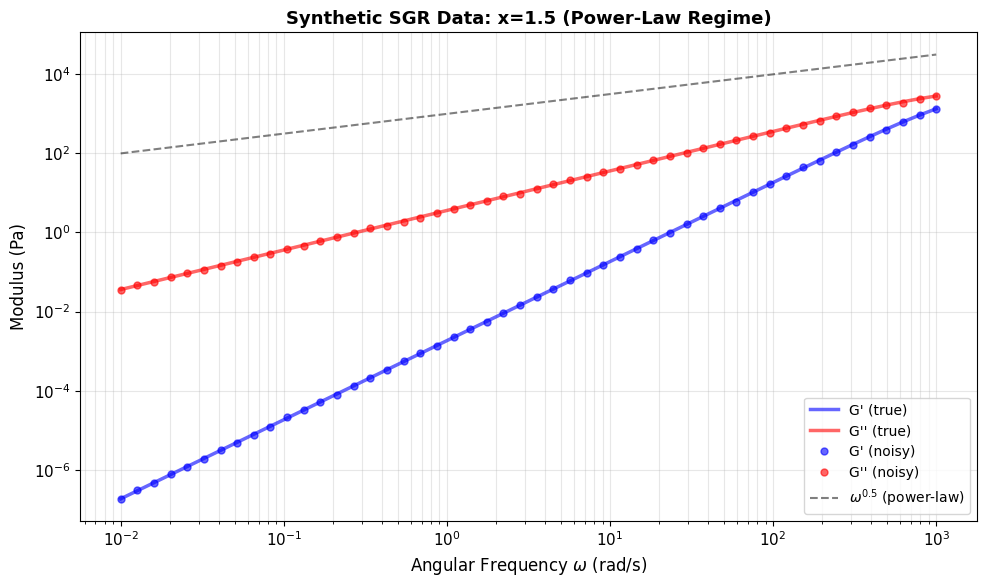

Generated synthetic SGR data:
  True parameters: x=1.5, G0=1.00e+04 Pa, tau0=1.00e-03 s
  Data points: 50
  Frequency range: 1.00e-02 - 1.00e+03 rad/s
  Noise level: 3.0% relative
  Phase regime: Power-law fluid (1 < x < 2)


In [3]:
# True parameters for a soft glassy material (1 < x < 2, power-law fluid regime)
x_true = 1.5  # Power-law fluid (balanced viscoelastic)
G0_true = 1e4  # Pa (typical soft paste/emulsion)
tau0_true = 1e-3  # s (millisecond timescale)

# Generate frequency sweep data
omega = np.logspace(-2, 3, 50)  # rad/s, 5 decades

# Create model with true parameters
model_true = SGRConventional()
model_true.parameters.set_value('x', x_true)
model_true.parameters.set_value('G0', G0_true)
model_true.parameters.set_value('tau0', tau0_true)

# Generate G*(omega) = [G', G'']
model_true._test_mode = 'oscillation'
G_star_true = model_true.predict(omega)

# Add realistic noise (3% relative noise)
noise_level = 0.03
noise = noise_level * G_star_true * np.random.randn(*G_star_true.shape)
G_star_noisy = G_star_true + noise

# Separate G' and G''
G_prime_true = G_star_true[:, 0]
G_double_prime_true = G_star_true[:, 1]
G_prime_noisy = G_star_noisy[:, 0]
G_double_prime_noisy = G_star_noisy[:, 1]

# Visualize synthetic data
fig = plt.figure(figsize=(10, 6))
plt.loglog(omega, G_prime_true, 'b-', linewidth=2.5, alpha=0.6, label="G' (true)")
plt.loglog(omega, G_double_prime_true, 'r-', linewidth=2.5, alpha=0.6, label="G'' (true)")
plt.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.6, label="G' (noisy)")
plt.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.6, label="G'' (noisy)")

# Add power-law reference
power_law_ref = 1e3 * (omega / 1.0) ** (x_true - 1)
plt.loglog(omega, power_law_ref, 'k--', linewidth=1.5, alpha=0.5, 
           label=rf'$\omega^{{{x_true-1:.1f}}}$ (power-law)')

plt.xlabel(r'Angular Frequency $\omega$ (rad/s)', fontsize=12)
plt.ylabel('Modulus (Pa)', fontsize=12)
plt.title(f'Synthetic SGR Data: x={x_true} (Power-Law Regime)', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated synthetic SGR data:")
print(f"  True parameters: x={x_true}, G0={G0_true:.2e} Pa, tau0={tau0_true:.2e} s")
print(f"  Data points: {len(omega)}")
print(f"  Frequency range: {omega.min():.2e} - {omega.max():.2e} rad/s")
print(f"  Noise level: {noise_level*100}% relative")
print(f"  Phase regime: Power-law fluid (1 < x < 2)")

## 3. Model Fitting: SGRConventional

Fit the conventional SGR model to frequency-domain data using NLSQ optimization.

In [4]:
# Create SGRConventional model
sgr_conv = SGRConventional()

# Fit to oscillation data
print("Fitting SGRConventional model...")
sgr_conv.fit(omega, G_star_noisy, test_mode='oscillation')

# Extract fitted parameters
x_fit = sgr_conv.parameters.get_value('x')
G0_fit = sgr_conv.parameters.get_value('G0')
tau0_fit = sgr_conv.parameters.get_value('tau0')

# Predict with fitted model
G_star_pred = sgr_conv.predict(omega)
G_prime_pred = G_star_pred[:, 0]
G_double_prime_pred = G_star_pred[:, 1]

# Calculate R² for G' and G''
def calc_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

r2_prime = calc_r2(G_prime_noisy, G_prime_pred)
r2_double_prime = calc_r2(G_double_prime_noisy, G_double_prime_pred)

# Get phase regime
phase_regime = sgr_conv.get_phase_regime()

print("\nFitted SGRConventional parameters:")
print(f"  x       = {x_fit:.4f} (true: {x_true:.4f})")
print(f"  G0      = {G0_fit:.2e} Pa (true: {G0_true:.2e} Pa)")
print(f"  tau0    = {tau0_fit:.2e} s (true: {tau0_true:.2e} s)")
print(f"\nFit quality:")
print(f"  R² (G')  = {r2_prime:.6f}")
print(f"  R² (G'') = {r2_double_prime:.6f}")
print(f"\nMaterial classification:")
print(f"  Phase regime: {phase_regime}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting SGRConventional model...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.661661s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.0215 | elapsed=2.662s | final_gradient_norm=2519.0783



Fitted SGRConventional parameters:
  x       = 1.4123 (true: 1.5000)
  G0      = 1.01e+04 Pa (true: 1.00e+04 Pa)
  tau0    = 1.03e-03 s (true: 1.00e-03 s)

Fit quality:
  R² (G')  = 0.999904
  R² (G'') = 0.999488

Material classification:
  Phase regime: power-law


### Visualize Fit Quality

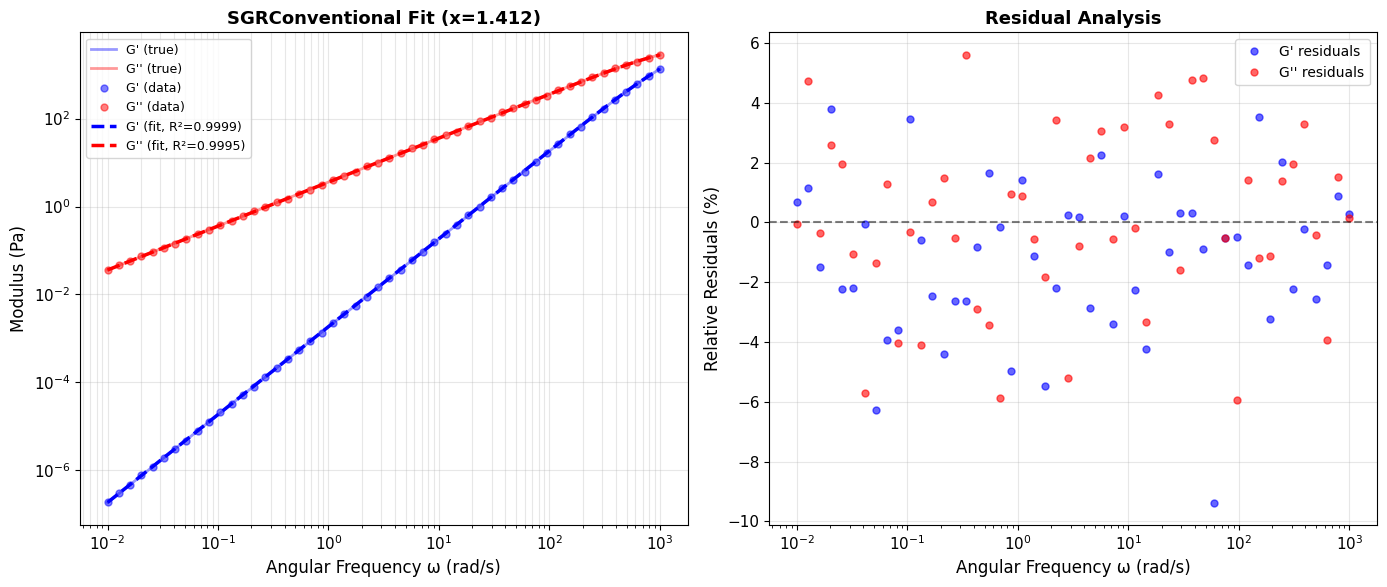

In [5]:
# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Data vs fit
ax1.loglog(omega, G_prime_true, 'b-', linewidth=2, alpha=0.4, label="G' (true)")
ax1.loglog(omega, G_double_prime_true, 'r-', linewidth=2, alpha=0.4, label="G'' (true)")
ax1.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.5, label="G' (data)")
ax1.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.5, label="G'' (data)")
ax1.loglog(omega, G_prime_pred, 'b--', linewidth=2.5, label=f"G' (fit, R²={r2_prime:.4f})")
ax1.loglog(omega, G_double_prime_pred, 'r--', linewidth=2.5, label=f"G'' (fit, R²={r2_double_prime:.4f})")
ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel('Modulus (Pa)', fontsize=12)
ax1.set_title(f'SGRConventional Fit (x={x_fit:.3f})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which='both')

# Right: Residuals
residuals_prime = (G_prime_noisy - G_prime_pred) / G_prime_noisy * 100
residuals_double_prime = (G_double_prime_noisy - G_double_prime_pred) / G_double_prime_noisy * 100
ax2.semilogx(omega, residuals_prime, 'bo', markersize=5, alpha=0.6, label="G' residuals")
ax2.semilogx(omega, residuals_double_prime, 'ro', markersize=5, alpha=0.6, label="G'' residuals")
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('Relative Residuals (%)', fontsize=12)
ax2.set_title('Residual Analysis', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Exploring Material Phase Regimes

Demonstrate how noise temperature x controls the phase transition.

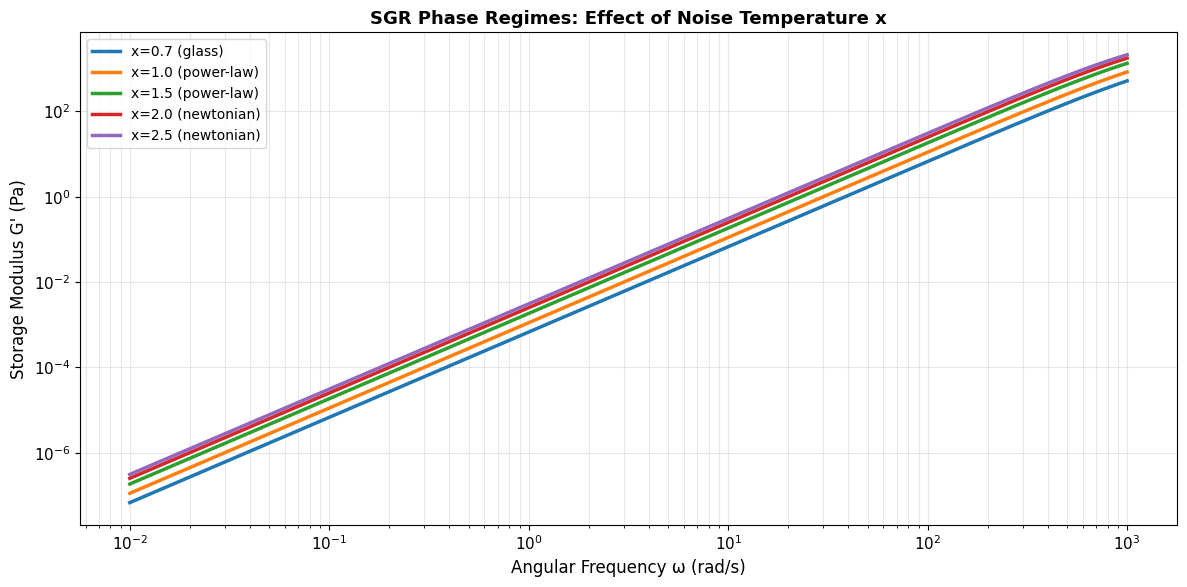

Physical interpretation of x:
  x < 1.0:  Glass phase (yield stress, solid-like, aging)
  x = 1.0:  Glass transition point (critical behavior)
  1 < x < 2: Power-law fluid (G' ~ G'' ~ ω^(x-1), viscoelastic)
  x ≥ 2.0:  Newtonian liquid (constant viscosity, fluid-like)

Application guide:
  Concentrated emulsions/foams:  x ∈ [0.6, 1.0] (near glass transition)
  Soft pastes/gels:              x ∈ [1.2, 1.8] (power-law regime)
  Dilute suspensions:            x ∈ [2.0, 2.5] (approaching Newtonian)


In [6]:
# Explore different x values
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
omega_demo = np.logspace(-2, 3, 100)

fig = plt.figure(figsize=(12, 6))

for x_val in x_values:
    # Create model with specific x
    model_demo = SGRConventional()
    model_demo.parameters.set_value('x', x_val)
    model_demo.parameters.set_value('G0', 1e4)
    model_demo.parameters.set_value('tau0', 1e-3)
    model_demo._test_mode = 'oscillation'
    
    # Predict
    G_star_demo = model_demo.predict(omega_demo)
    
    # Classify phase
    phase = model_demo.get_phase_regime()
    
    # Plot G' (similar behavior for G'')
    plt.loglog(omega_demo, G_star_demo[:, 0], linewidth=2.5, 
               label=f"x={x_val} ({phase})")

plt.xlabel('Angular Frequency ω (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('SGR Phase Regimes: Effect of Noise Temperature x', fontsize=13, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Physical interpretation of x:")
print("  x < 1.0:  Glass phase (yield stress, solid-like, aging)")
print("  x = 1.0:  Glass transition point (critical behavior)")
print("  1 < x < 2: Power-law fluid (G' ~ G'' ~ ω^(x-1), viscoelastic)")
print("  x ≥ 2.0:  Newtonian liquid (constant viscosity, fluid-like)")
print("\nApplication guide:")
print("  Concentrated emulsions/foams:  x ∈ [0.6, 1.0] (near glass transition)")
print("  Soft pastes/gels:              x ∈ [1.2, 1.8] (power-law regime)")
print("  Dilute suspensions:            x ∈ [2.0, 2.5] (approaching Newtonian)")

## 5. SGRGeneric: Thermodynamically Consistent Framework

Compare SGRConventional with the GENERIC thermodynamic framework.

In [7]:
# Fit SGRGeneric to same data
sgr_gen = SGRGeneric()

print("Fitting SGRGeneric model...")
sgr_gen.fit(omega, G_star_noisy, test_mode='oscillation')

# Extract fitted parameters
x_gen = sgr_gen.parameters.get_value('x')
G0_gen = sgr_gen.parameters.get_value('G0')
tau0_gen = sgr_gen.parameters.get_value('tau0')

# Predict
G_star_gen = sgr_gen.predict(omega)

# Calculate R²
r2_prime_gen = calc_r2(G_prime_noisy, G_star_gen[:, 0])
r2_double_prime_gen = calc_r2(G_double_prime_noisy, G_star_gen[:, 1])

print("\nFitted SGRGeneric parameters:")
print(f"  x    = {x_gen:.4f}")
print(f"  G0   = {G0_gen:.2e} Pa")
print(f"  tau0 = {tau0_gen:.2e} s")
print(f"\nFit quality:")
print(f"  R² (G')  = {r2_prime_gen:.6f}")
print(f"  R² (G'') = {r2_double_prime_gen:.6f}")

# Check thermodynamic consistency
state_test = np.array([100.0, 0.5])  # [stress (Pa), structural parameter]
consistency = sgr_gen.verify_thermodynamic_consistency(state_test)

print("\nThermodynamic consistency checks:")
print(f"  Poisson bracket antisymmetric: {consistency['poisson_antisymmetric']}")
print(f"  Friction matrix symmetric: {consistency['friction_symmetric']}")
print(f"  Friction matrix PSD: {consistency['friction_positive_semidefinite']}")
print(f"  Entropy production ≥ 0: {consistency['entropy_production_nonnegative']}")
print(f"  Overall: {consistency['thermodynamically_consistent']}")
print(f"\nEntropy production rate: {consistency['entropy_production']:.6e} (must be ≥ 0)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting SGRGeneric model...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.043200s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.0215 | elapsed=1.043s | final_gradient_norm=2519.0783



Fitted SGRGeneric parameters:
  x    = 1.4123
  G0   = 1.01e+04 Pa
  tau0 = 1.03e-03 s

Fit quality:
  R² (G')  = 0.999904
  R² (G'') = 0.999488

Thermodynamic consistency checks:
  Poisson bracket antisymmetric: True
  Friction matrix symmetric: True
  Friction matrix PSD: True
  Entropy production ≥ 0: True
  Overall: True

Entropy production rate: 2.509780e+03 (must be ≥ 0)


### Compare Conventional vs GENERIC Predictions

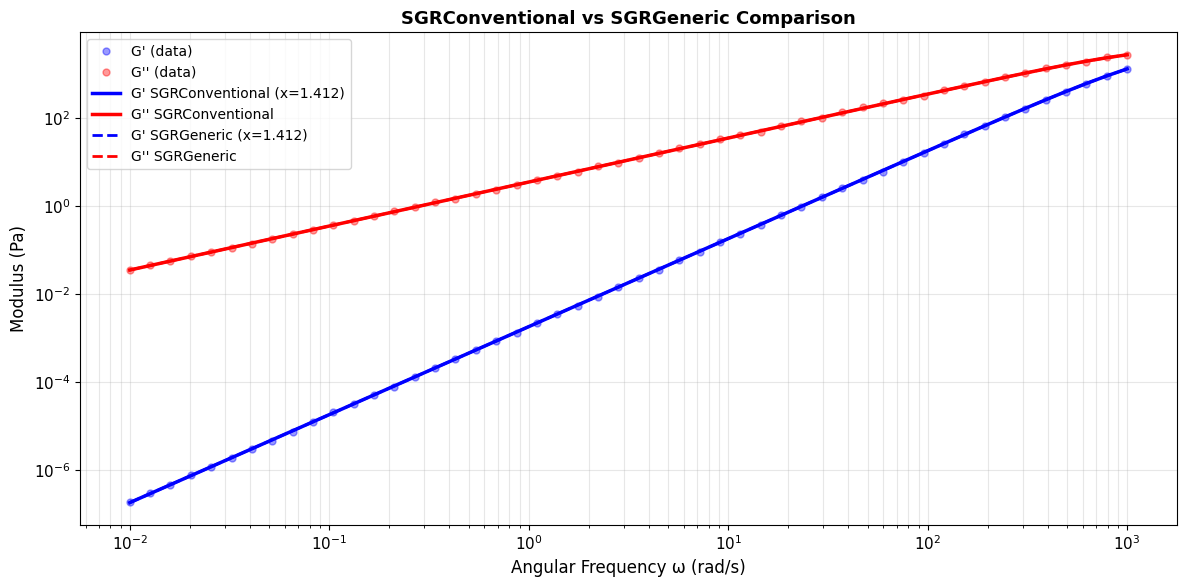

Comparison summary:
  SGRConventional: x=1.4123, R²(G')=0.999904, R²(G'')=0.999488
  SGRGeneric:      x=1.4123, R²(G')=0.999904, R²(G'')=0.999488

Conclusion: Both models provide excellent fits with nearly identical predictions.
Use SGRGeneric when thermodynamic consistency is critical.


In [8]:
# Compare predictions
fig = plt.figure(figsize=(12, 6))

plt.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.4, label="G' (data)")
plt.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.4, label="G'' (data)")
plt.loglog(omega, G_prime_pred, 'b-', linewidth=2.5, 
           label=f"G' SGRConventional (x={x_fit:.3f})")
plt.loglog(omega, G_double_prime_pred, 'r-', linewidth=2.5, 
           label=f"G'' SGRConventional")
plt.loglog(omega, G_star_gen[:, 0], 'b--', linewidth=2, 
           label=f"G' SGRGeneric (x={x_gen:.3f})")
plt.loglog(omega, G_star_gen[:, 1], 'r--', linewidth=2, 
           label=f"G'' SGRGeneric")

plt.xlabel('Angular Frequency ω (rad/s)', fontsize=12)
plt.ylabel('Modulus (Pa)', fontsize=12)
plt.title('SGRConventional vs SGRGeneric Comparison', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Comparison summary:")
print(f"  SGRConventional: x={x_fit:.4f}, R²(G')={r2_prime:.6f}, R²(G'')={r2_double_prime:.6f}")
print(f"  SGRGeneric:      x={x_gen:.4f}, R²(G')={r2_prime_gen:.6f}, R²(G'')={r2_double_prime_gen:.6f}")
print("\nConclusion: Both models provide excellent fits with nearly identical predictions.")
print("Use SGRGeneric when thermodynamic consistency is critical.")

## 6. Relaxation Mode: Time-Domain Fitting

Demonstrate SGR fitting to relaxation modulus data.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting SGR to relaxation data...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.621108s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=0.0215 | elapsed=0.621s | final_gradient_norm=0.0320



Fitted parameters (relaxation mode):
  x    = 1.4978 (true: 1.5000)
  G0   = 9.50e+03 Pa (true: 1.00e+04 Pa)
  tau0 = 1.14e-03 s (true: 1.00e-03 s)
  R²   = 0.999107


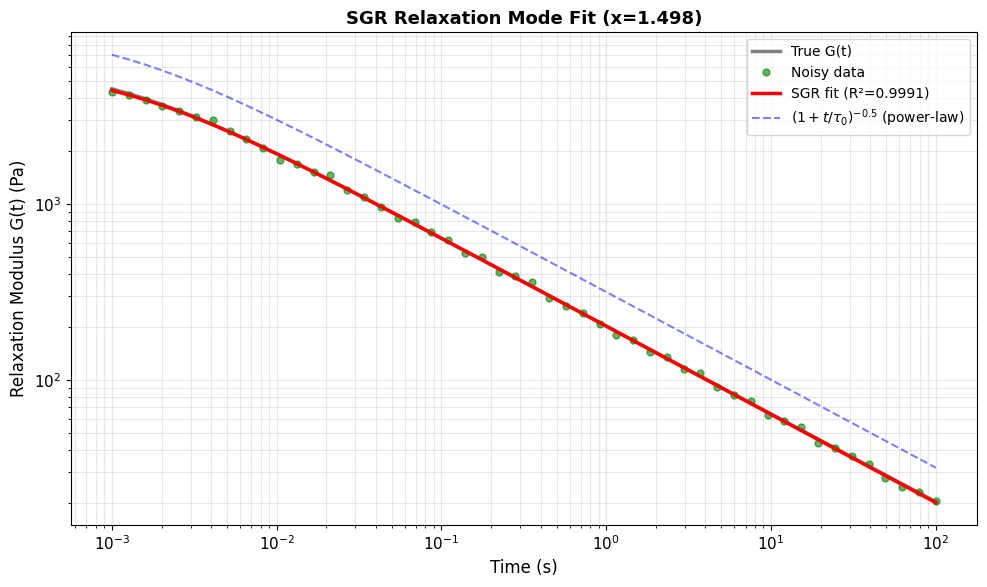


Relaxation behavior:
  Short time (t << tau0): G(t) ≈ G0 (plateau)
  Long time (t >> tau0):  G(t) ~ t^(x-2) = t^-0.50 (power-law decay)
  For x < 2: relaxation, x ≥ 2: approaches constant


In [9]:
# Generate relaxation data
t = np.logspace(-3, 2, 50)  # Time (s)

# Use same true parameters
model_relax_true = SGRConventional()
model_relax_true.parameters.set_value('x', x_true)
model_relax_true.parameters.set_value('G0', G0_true)
model_relax_true.parameters.set_value('tau0', tau0_true)
model_relax_true._test_mode = 'relaxation'

# Generate G(t)
G_t_true = model_relax_true.predict(t)

# Add noise (3% relative)
G_t_noisy = G_t_true * (1 + noise_level * np.random.randn(len(t)))

# Fit SGRConventional in relaxation mode
sgr_relax = SGRConventional()
print("Fitting SGR to relaxation data...")
sgr_relax.fit(t, G_t_noisy, test_mode='relaxation')

# Predict
G_t_pred = sgr_relax.predict(t)

# R²
r2_relax = calc_r2(G_t_noisy, G_t_pred)

# Extract parameters
x_relax = sgr_relax.parameters.get_value('x')
G0_relax = sgr_relax.parameters.get_value('G0')
tau0_relax = sgr_relax.parameters.get_value('tau0')

print(f"\nFitted parameters (relaxation mode):")
print(f"  x    = {x_relax:.4f} (true: {x_true:.4f})")
print(f"  G0   = {G0_relax:.2e} Pa (true: {G0_true:.2e} Pa)")
print(f"  tau0 = {tau0_relax:.2e} s (true: {tau0_true:.2e} s)")
print(f"  R²   = {r2_relax:.6f}")

# Plot
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2.5, alpha=0.5, label='True G(t)')
plt.loglog(t, G_t_noisy, 'go', markersize=5, alpha=0.6, label='Noisy data')
plt.loglog(t, G_t_pred, 'r-', linewidth=2.5, label=f'SGR fit (R²={r2_relax:.4f})')

# Power-law reference
power_law_t = G0_true * (1 + t/tau0_true)**(x_true - 2)
plt.loglog(t, power_law_t, 'b--', linewidth=1.5, alpha=0.5, 
           label=f'$(1+t/\\tau_0)^{{{x_true-2:.1f}}}$ (power-law)')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
plt.title(f'SGR Relaxation Mode Fit (x={x_relax:.3f})', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nRelaxation behavior:")
print(f"  Short time (t << tau0): G(t) ≈ G0 (plateau)")
print(f"  Long time (t >> tau0):  G(t) ~ t^(x-2) = t^{x_relax-2:.2f} (power-law decay)")
print(f"  For x < 2: relaxation, x ≥ 2: approaches constant")

## 7. Bayesian Inference: Uncertainty Quantification

Use Bayesian inference to quantify uncertainty in fitted SGR parameters.

In [10]:
# Bayesian inference with warm-start from NLSQ
print("Running Bayesian inference (NUTS with warm-start)...")
print("This may take 30-60 seconds...\n")

# Use SGRConventional fitted model as warm-start
result_bayes = sgr_conv.fit_bayesian(
    omega, 
    G_star_noisy, 
    test_mode='oscillation',
    num_samples=2000, 
    num_warmup=1000,
    num_chains=2
)

# Get credible intervals (returns dict[str, tuple[float, float]] = (lower, upper))
intervals = sgr_conv.get_credible_intervals(result_bayes.posterior_samples, credibility=0.95)

print("\nBayesian inference results (95% credible intervals):")
for param_name, (lower, upper) in intervals.items():
    # Compute median from posterior samples
    samples = result_bayes.posterior_samples[param_name]
    median = np.median(samples)
    
    # Get true value for comparison
    true_val = {'x': x_true, 'G0': G0_true, 'tau0': tau0_true}[param_name]
    
    print(f"  {param_name:5s}: {median:.4e} [{lower:.4e}, {upper:.4e}] (true: {true_val:.4e})")

# Get diagnostics
diagnostics = result_bayes.diagnostics

print("\nMCMC Diagnostics:")
print(f"  R-hat (all params):  {diagnostics['r_hat']}")
print(f"  ESS (all params):    {diagnostics['ess']}")
print(f"  Divergences:         {diagnostics['divergences']}")

# Check convergence criteria
r_hat_ok = all(r < 1.01 for r in diagnostics['r_hat'].values())
ess_ok = all(e > 400 for e in diagnostics['ess'].values())
div_ok = diagnostics['divergences'] < 10

print(f"\nConvergence checks:")
print(f"  R-hat < 1.01: {'PASS' if r_hat_ok else 'FAIL'}")
print(f"  ESS > 400:    {'PASS' if ess_ok else 'FAIL'}")
print(f"  Divergences < 1%: {'PASS' if div_ok else 'FAIL'}")

Running Bayesian inference (NUTS with warm-start)...
This may take 30-60 seconds...



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:03<2:35:00,  3.10s/it]

warmup:   0%|          | 2/3000 [00:05<2:08:44,  2.58s/it]

warmup:   0%|          | 8/3000 [00:05<22:22,  2.23it/s]  

warmup:   0%|          | 11/3000 [00:05<14:38,  3.40it/s]

warmup:   0%|          | 14/3000 [00:05<10:06,  4.92it/s]

warmup:   1%|          | 17/3000 [00:05<07:18,  6.80it/s]

warmup:   1%|          | 20/3000 [00:05<06:08,  8.09it/s]

warmup:   1%|          | 23/3000 [00:06<04:47, 10.34it/s]

warmup:   1%|          | 26/3000 [00:06<04:16, 11.58it/s]

warmup:   1%|          | 30/3000 [00:06<03:57, 12.49it/s]

warmup:   1%|          | 32/3000 [00:06<04:06, 12.05it/s]

warmup:   1%|          | 34/3000 [00:06<04:21, 11.35it/s]

warmup:   1%|▏         | 39/3000 [00:07<02:50, 17.35it/s]

warmup:   1%|▏         | 42/3000 [00:07<03:54, 12.59it/s]

warmup:   1%|▏         | 44/3000 [00:07<04:10, 11.80it/s]

warmup:   2%|▏         | 46/3000 [00:07<04:01, 12.24it/s]

warmup:   2%|▏         | 48/3000 [00:08<04:10, 11.78it/s]

warmup:   2%|▏         | 50/3000 [00:08<04:59,  9.86it/s]

warmup:   2%|▏         | 52/3000 [00:08<05:40,  8.66it/s]

warmup:   2%|▏         | 54/3000 [00:08<05:08,  9.56it/s]

warmup:   2%|▏         | 56/3000 [00:09<05:44,  8.53it/s]

warmup:   2%|▏         | 57/3000 [00:09<05:42,  8.60it/s]

warmup:   2%|▏         | 60/3000 [00:09<05:21,  9.16it/s]

warmup:   2%|▏         | 62/3000 [00:09<05:40,  8.64it/s]

warmup:   2%|▏         | 65/3000 [00:09<04:41, 10.44it/s]

warmup:   2%|▏         | 67/3000 [00:10<05:18,  9.22it/s]

warmup:   2%|▏         | 69/3000 [00:10<05:29,  8.90it/s]

warmup:   2%|▏         | 70/3000 [00:10<05:56,  8.23it/s]

warmup:   2%|▏         | 72/3000 [00:10<05:26,  8.97it/s]

warmup:   2%|▎         | 75/3000 [00:11<04:45, 10.24it/s]

warmup:   3%|▎         | 77/3000 [00:11<05:05,  9.57it/s]

warmup:   3%|▎         | 78/3000 [00:11<05:51,  8.32it/s]

warmup:   3%|▎         | 81/3000 [00:11<04:51, 10.01it/s]

warmup:   3%|▎         | 84/3000 [00:11<04:28, 10.87it/s]

warmup:   3%|▎         | 86/3000 [00:12<04:49, 10.06it/s]

warmup:   3%|▎         | 88/3000 [00:12<05:43,  8.47it/s]

warmup:   3%|▎         | 89/3000 [00:12<06:28,  7.49it/s]

warmup:   3%|▎         | 90/3000 [00:12<06:34,  7.37it/s]

warmup:   3%|▎         | 91/3000 [00:13<06:40,  7.27it/s]

warmup:   3%|▎         | 93/3000 [00:13<05:21,  9.04it/s]

warmup:   3%|▎         | 95/3000 [00:13<04:39, 10.39it/s]

warmup:   3%|▎         | 99/3000 [00:13<03:40, 13.13it/s]

warmup:   3%|▎         | 101/3000 [00:13<03:56, 12.28it/s]

warmup:   3%|▎         | 103/3000 [00:13<04:36, 10.49it/s]

warmup:   4%|▎         | 105/3000 [00:14<04:55,  9.79it/s]

warmup:   4%|▎         | 107/3000 [00:14<04:57,  9.72it/s]

warmup:   4%|▎         | 108/3000 [00:14<04:58,  9.68it/s]

warmup:   4%|▎         | 109/3000 [00:14<04:58,  9.67it/s]

warmup:   4%|▎         | 111/3000 [00:14<04:09, 11.59it/s]

warmup:   4%|▍         | 113/3000 [00:14<04:12, 11.42it/s]

warmup:   4%|▍         | 115/3000 [00:15<06:12,  7.74it/s]

warmup:   4%|▍         | 116/3000 [00:15<06:49,  7.05it/s]

warmup:   4%|▍         | 117/3000 [00:15<06:52,  6.99it/s]

warmup:   4%|▍         | 118/3000 [00:15<06:49,  7.03it/s]

warmup:   4%|▍         | 119/3000 [00:15<06:19,  7.59it/s]

warmup:   4%|▍         | 120/3000 [00:16<06:06,  7.86it/s]

warmup:   4%|▍         | 122/3000 [00:16<04:31, 10.61it/s]

warmup:   4%|▍         | 124/3000 [00:16<04:23, 10.91it/s]

warmup:   4%|▍         | 126/3000 [00:16<05:20,  8.98it/s]

warmup:   4%|▍         | 129/3000 [00:16<03:44, 12.78it/s]

warmup:   4%|▍         | 131/3000 [00:16<03:35, 13.33it/s]

warmup:   4%|▍         | 133/3000 [00:17<05:17,  9.04it/s]

warmup:   4%|▍         | 135/3000 [00:17<05:08,  9.29it/s]

warmup:   5%|▍         | 137/3000 [00:17<04:27, 10.69it/s]

warmup:   5%|▍         | 139/3000 [00:17<04:57,  9.61it/s]

warmup:   5%|▍         | 141/3000 [00:18<05:39,  8.41it/s]

warmup:   5%|▍         | 143/3000 [00:18<05:21,  8.89it/s]

warmup:   5%|▍         | 145/3000 [00:18<05:18,  8.97it/s]

warmup:   5%|▍         | 147/3000 [00:18<05:01,  9.46it/s]

warmup:   5%|▍         | 149/3000 [00:19<06:34,  7.23it/s]

warmup:   5%|▌         | 150/3000 [00:19<06:32,  7.27it/s]

warmup:   5%|▌         | 151/3000 [00:19<06:36,  7.18it/s]

warmup:   5%|▌         | 153/3000 [00:19<05:50,  8.13it/s]

warmup:   5%|▌         | 154/3000 [00:19<06:39,  7.12it/s]

warmup:   5%|▌         | 157/3000 [00:20<05:46,  8.20it/s]

warmup:   5%|▌         | 158/3000 [00:20<06:25,  7.38it/s]

warmup:   5%|▌         | 159/3000 [00:20<07:09,  6.61it/s]

warmup:   5%|▌         | 160/3000 [00:20<07:54,  5.98it/s]

warmup:   5%|▌         | 161/3000 [00:21<08:49,  5.36it/s]

warmup:   5%|▌         | 162/3000 [00:21<09:05,  5.21it/s]

warmup:   5%|▌         | 163/3000 [00:21<09:28,  4.99it/s]

warmup:   5%|▌         | 164/3000 [00:21<09:26,  5.01it/s]

warmup:   6%|▌         | 165/3000 [00:21<09:37,  4.91it/s]

warmup:   6%|▌         | 166/3000 [00:22<09:38,  4.90it/s]

warmup:   6%|▌         | 167/3000 [00:22<09:31,  4.96it/s]

warmup:   6%|▌         | 168/3000 [00:22<08:17,  5.69it/s]

warmup:   6%|▌         | 169/3000 [00:22<08:52,  5.32it/s]

warmup:   6%|▌         | 170/3000 [00:22<09:05,  5.18it/s]

warmup:   6%|▌         | 171/3000 [00:23<09:49,  4.80it/s]

warmup:   6%|▌         | 172/3000 [00:23<08:31,  5.53it/s]

warmup:   6%|▌         | 173/3000 [00:23<08:20,  5.64it/s]

warmup:   6%|▌         | 175/3000 [00:23<06:43,  6.99it/s]

warmup:   6%|▌         | 176/3000 [00:23<07:31,  6.26it/s]

warmup:   6%|▌         | 177/3000 [00:23<08:02,  5.85it/s]

warmup:   6%|▌         | 178/3000 [00:24<08:45,  5.37it/s]

warmup:   6%|▌         | 179/3000 [00:24<09:02,  5.20it/s]

warmup:   6%|▌         | 180/3000 [00:24<08:59,  5.23it/s]

warmup:   6%|▌         | 181/3000 [00:24<08:16,  5.68it/s]

warmup:   6%|▌         | 182/3000 [00:24<07:18,  6.43it/s]

warmup:   6%|▌         | 183/3000 [00:24<06:40,  7.03it/s]

warmup:   6%|▌         | 184/3000 [00:25<07:31,  6.24it/s]

warmup:   6%|▌         | 185/3000 [00:25<08:09,  5.76it/s]

warmup:   6%|▌         | 187/3000 [00:25<06:37,  7.08it/s]

warmup:   6%|▋         | 189/3000 [00:25<05:41,  8.24it/s]

warmup:   6%|▋         | 190/3000 [00:25<05:53,  7.94it/s]

warmup:   6%|▋         | 192/3000 [00:26<05:03,  9.26it/s]

warmup:   6%|▋         | 193/3000 [00:26<05:57,  7.86it/s]

warmup:   6%|▋         | 194/3000 [00:26<06:07,  7.63it/s]

warmup:   6%|▋         | 195/3000 [00:26<06:07,  7.62it/s]

warmup:   7%|▋         | 196/3000 [00:26<05:47,  8.07it/s]

warmup:   7%|▋         | 197/3000 [00:26<05:40,  8.24it/s]

warmup:   7%|▋         | 200/3000 [00:26<04:29, 10.38it/s]

warmup:   7%|▋         | 201/3000 [00:27<04:54,  9.52it/s]

warmup:   7%|▋         | 206/3000 [00:27<03:22, 13.82it/s]

warmup:   7%|▋         | 208/3000 [00:27<03:23, 13.74it/s]

warmup:   7%|▋         | 210/3000 [00:27<03:26, 13.50it/s]

warmup:   7%|▋         | 212/3000 [00:27<03:19, 13.94it/s]

warmup:   7%|▋         | 215/3000 [00:27<03:00, 15.45it/s]

warmup:   7%|▋         | 217/3000 [00:28<03:07, 14.82it/s]

warmup:   7%|▋         | 219/3000 [00:28<02:54, 15.91it/s]

warmup:   7%|▋         | 221/3000 [00:28<02:49, 16.39it/s]

warmup:   7%|▋         | 223/3000 [00:28<03:30, 13.17it/s]

warmup:   8%|▊         | 225/3000 [00:28<04:05, 11.28it/s]

warmup:   8%|▊         | 227/3000 [00:29<05:02,  9.15it/s]

warmup:   8%|▊         | 229/3000 [00:29<04:29, 10.29it/s]

warmup:   8%|▊         | 231/3000 [00:29<05:14,  8.79it/s]

warmup:   8%|▊         | 233/3000 [00:29<05:49,  7.93it/s]

warmup:   8%|▊         | 234/3000 [00:29<05:39,  8.16it/s]

warmup:   8%|▊         | 235/3000 [00:30<06:05,  7.56it/s]

warmup:   8%|▊         | 236/3000 [00:30<07:25,  6.20it/s]

warmup:   8%|▊         | 237/3000 [00:30<07:05,  6.49it/s]

warmup:   8%|▊         | 239/3000 [00:30<05:41,  8.08it/s]

warmup:   8%|▊         | 241/3000 [00:30<04:39,  9.88it/s]

warmup:   8%|▊         | 243/3000 [00:31<04:52,  9.44it/s]

warmup:   8%|▊         | 245/3000 [00:31<05:38,  8.15it/s]

warmup:   8%|▊         | 246/3000 [00:31<05:32,  8.27it/s]

warmup:   8%|▊         | 247/3000 [00:31<07:02,  6.52it/s]

warmup:   8%|▊         | 248/3000 [00:31<06:31,  7.04it/s]

warmup:   8%|▊         | 249/3000 [00:32<07:18,  6.28it/s]

warmup:   8%|▊         | 250/3000 [00:32<08:10,  5.60it/s]

warmup:   8%|▊         | 253/3000 [00:32<05:16,  8.68it/s]

warmup:   8%|▊         | 254/3000 [00:32<06:19,  7.23it/s]

warmup:   8%|▊         | 255/3000 [00:32<07:10,  6.38it/s]

warmup:   9%|▊         | 256/3000 [00:33<08:12,  5.57it/s]

warmup:   9%|▊         | 257/3000 [00:33<07:53,  5.79it/s]

warmup:   9%|▊         | 258/3000 [00:33<07:54,  5.78it/s]

warmup:   9%|▊         | 259/3000 [00:33<08:46,  5.20it/s]

warmup:   9%|▊         | 260/3000 [00:33<07:35,  6.02it/s]

warmup:   9%|▊         | 261/3000 [00:34<08:16,  5.51it/s]

warmup:   9%|▊         | 262/3000 [00:34<08:55,  5.11it/s]

warmup:   9%|▉         | 263/3000 [00:34<09:21,  4.88it/s]

warmup:   9%|▉         | 264/3000 [00:34<09:49,  4.64it/s]

warmup:   9%|▉         | 265/3000 [00:34<10:12,  4.46it/s]

warmup:   9%|▉         | 267/3000 [00:35<08:05,  5.63it/s]

warmup:   9%|▉         | 269/3000 [00:35<06:50,  6.65it/s]

warmup:   9%|▉         | 270/3000 [00:35<06:44,  6.75it/s]

warmup:   9%|▉         | 271/3000 [00:35<07:00,  6.49it/s]

warmup:   9%|▉         | 274/3000 [00:35<04:52,  9.33it/s]

warmup:   9%|▉         | 276/3000 [00:36<04:47,  9.47it/s]

warmup:   9%|▉         | 277/3000 [00:36<05:17,  8.59it/s]

warmup:   9%|▉         | 278/3000 [00:36<05:42,  7.95it/s]

warmup:   9%|▉         | 280/3000 [00:36<05:10,  8.75it/s]

warmup:   9%|▉         | 281/3000 [00:36<06:01,  7.52it/s]

warmup:   9%|▉         | 283/3000 [00:37<06:09,  7.36it/s]

warmup:   9%|▉         | 284/3000 [00:37<06:41,  6.76it/s]

warmup:  10%|▉         | 285/3000 [00:37<07:12,  6.28it/s]

warmup:  10%|▉         | 286/3000 [00:37<07:44,  5.84it/s]

warmup:  10%|▉         | 288/3000 [00:37<05:47,  7.80it/s]

warmup:  10%|▉         | 289/3000 [00:38<06:34,  6.88it/s]

warmup:  10%|▉         | 290/3000 [00:38<07:04,  6.39it/s]

warmup:  10%|▉         | 291/3000 [00:38<06:54,  6.53it/s]

warmup:  10%|▉         | 292/3000 [00:38<08:01,  5.62it/s]

warmup:  10%|▉         | 294/3000 [00:38<07:10,  6.29it/s]

warmup:  10%|▉         | 295/3000 [00:39<07:58,  5.65it/s]

warmup:  10%|▉         | 297/3000 [00:39<06:23,  7.05it/s]

warmup:  10%|▉         | 298/3000 [00:39<06:35,  6.84it/s]

warmup:  10%|█         | 300/3000 [00:39<05:14,  8.58it/s]

warmup:  10%|█         | 302/3000 [00:39<05:29,  8.19it/s]

warmup:  10%|█         | 305/3000 [00:40<05:28,  8.21it/s]

warmup:  10%|█         | 307/3000 [00:40<05:22,  8.34it/s]

warmup:  10%|█         | 309/3000 [00:40<04:34,  9.82it/s]

warmup:  10%|█         | 311/3000 [00:40<04:23, 10.19it/s]

warmup:  10%|█         | 313/3000 [00:41<04:38,  9.65it/s]

warmup:  10%|█         | 315/3000 [00:41<05:52,  7.63it/s]

warmup:  11%|█         | 316/3000 [00:41<06:25,  6.96it/s]

warmup:  11%|█         | 317/3000 [00:41<07:08,  6.27it/s]

warmup:  11%|█         | 318/3000 [00:42<07:09,  6.25it/s]

warmup:  11%|█         | 320/3000 [00:42<05:49,  7.66it/s]

warmup:  11%|█         | 321/3000 [00:42<05:47,  7.71it/s]

warmup:  11%|█         | 322/3000 [00:42<06:31,  6.84it/s]

warmup:  11%|█         | 323/3000 [00:42<06:54,  6.46it/s]

warmup:  11%|█         | 324/3000 [00:42<06:46,  6.58it/s]

warmup:  11%|█         | 325/3000 [00:43<08:01,  5.55it/s]

warmup:  11%|█         | 326/3000 [00:43<07:03,  6.31it/s]

warmup:  11%|█         | 327/3000 [00:43<08:13,  5.42it/s]

warmup:  11%|█         | 328/3000 [00:43<09:34,  4.65it/s]

warmup:  11%|█         | 329/3000 [00:43<08:26,  5.28it/s]

warmup:  11%|█         | 330/3000 [00:44<08:19,  5.34it/s]

warmup:  11%|█         | 331/3000 [00:44<07:52,  5.65it/s]

warmup:  11%|█         | 332/3000 [00:44<07:55,  5.61it/s]

warmup:  11%|█         | 334/3000 [00:44<06:19,  7.02it/s]

warmup:  11%|█         | 335/3000 [00:44<07:40,  5.79it/s]

warmup:  11%|█         | 336/3000 [00:45<07:37,  5.82it/s]

warmup:  11%|█         | 337/3000 [00:45<08:56,  4.97it/s]

warmup:  11%|█▏        | 338/3000 [00:45<08:50,  5.02it/s]

warmup:  11%|█▏        | 339/3000 [00:45<08:55,  4.97it/s]

warmup:  11%|█▏        | 340/3000 [00:45<07:59,  5.55it/s]

warmup:  11%|█▏        | 341/3000 [00:45<07:11,  6.16it/s]

warmup:  11%|█▏        | 342/3000 [00:46<06:32,  6.77it/s]

warmup:  11%|█▏        | 344/3000 [00:46<07:16,  6.08it/s]

warmup:  12%|█▏        | 346/3000 [00:46<05:49,  7.58it/s]

warmup:  12%|█▏        | 347/3000 [00:46<07:23,  5.98it/s]

warmup:  12%|█▏        | 348/3000 [00:46<06:48,  6.50it/s]

warmup:  12%|█▏        | 350/3000 [00:47<05:55,  7.45it/s]

warmup:  12%|█▏        | 351/3000 [00:47<05:55,  7.45it/s]

warmup:  12%|█▏        | 353/3000 [00:47<05:17,  8.33it/s]

warmup:  12%|█▏        | 354/3000 [00:47<06:50,  6.44it/s]

warmup:  12%|█▏        | 355/3000 [00:47<06:24,  6.88it/s]

warmup:  12%|█▏        | 356/3000 [00:48<06:48,  6.48it/s]

warmup:  12%|█▏        | 357/3000 [00:48<06:51,  6.43it/s]

warmup:  12%|█▏        | 358/3000 [00:48<06:20,  6.95it/s]

warmup:  12%|█▏        | 359/3000 [00:48<06:39,  6.61it/s]

warmup:  12%|█▏        | 360/3000 [00:48<07:32,  5.84it/s]

warmup:  12%|█▏        | 361/3000 [00:48<07:59,  5.50it/s]

warmup:  12%|█▏        | 362/3000 [00:49<08:26,  5.21it/s]

warmup:  12%|█▏        | 363/3000 [00:49<10:08,  4.34it/s]

warmup:  12%|█▏        | 364/3000 [00:49<08:42,  5.05it/s]

warmup:  12%|█▏        | 366/3000 [00:49<07:42,  5.69it/s]

warmup:  12%|█▏        | 367/3000 [00:50<07:33,  5.81it/s]

warmup:  12%|█▏        | 368/3000 [00:50<07:42,  5.69it/s]

warmup:  12%|█▏        | 371/3000 [00:50<05:42,  7.68it/s]

warmup:  12%|█▏        | 372/3000 [00:50<06:11,  7.07it/s]

warmup:  12%|█▏        | 373/3000 [00:50<06:52,  6.37it/s]

warmup:  12%|█▏        | 374/3000 [00:51<07:34,  5.78it/s]

warmup:  12%|█▎        | 375/3000 [00:51<09:00,  4.86it/s]

warmup:  13%|█▎        | 376/3000 [00:51<09:29,  4.61it/s]

warmup:  13%|█▎        | 377/3000 [00:51<09:24,  4.65it/s]

warmup:  13%|█▎        | 378/3000 [00:52<10:29,  4.17it/s]

warmup:  13%|█▎        | 379/3000 [00:52<10:17,  4.25it/s]

warmup:  13%|█▎        | 380/3000 [00:52<10:36,  4.12it/s]

warmup:  13%|█▎        | 382/3000 [00:52<08:39,  5.04it/s]

warmup:  13%|█▎        | 383/3000 [00:53<09:31,  4.58it/s]

warmup:  13%|█▎        | 384/3000 [00:53<08:15,  5.28it/s]

warmup:  13%|█▎        | 385/3000 [00:53<08:14,  5.29it/s]

warmup:  13%|█▎        | 386/3000 [00:53<09:15,  4.70it/s]

warmup:  13%|█▎        | 387/3000 [00:54<08:48,  4.95it/s]

warmup:  13%|█▎        | 388/3000 [00:54<09:11,  4.74it/s]

warmup:  13%|█▎        | 389/3000 [00:54<09:19,  4.67it/s]

warmup:  13%|█▎        | 391/3000 [00:54<07:23,  5.88it/s]

warmup:  13%|█▎        | 393/3000 [00:54<06:40,  6.50it/s]

warmup:  13%|█▎        | 394/3000 [00:55<06:56,  6.25it/s]

warmup:  13%|█▎        | 396/3000 [00:55<05:52,  7.39it/s]

warmup:  13%|█▎        | 397/3000 [00:55<06:40,  6.50it/s]

warmup:  13%|█▎        | 398/3000 [00:55<06:44,  6.43it/s]

warmup:  13%|█▎        | 401/3000 [00:56<05:58,  7.24it/s]

warmup:  13%|█▎        | 403/3000 [00:56<05:15,  8.24it/s]

warmup:  13%|█▎        | 404/3000 [00:56<05:34,  7.77it/s]

warmup:  14%|█▎        | 405/3000 [00:56<06:43,  6.44it/s]

warmup:  14%|█▎        | 407/3000 [00:56<05:02,  8.56it/s]

warmup:  14%|█▎        | 409/3000 [00:57<05:21,  8.06it/s]

warmup:  14%|█▎        | 410/3000 [00:57<06:16,  6.87it/s]

warmup:  14%|█▍        | 413/3000 [00:57<05:12,  8.29it/s]

warmup:  14%|█▍        | 414/3000 [00:57<06:16,  6.87it/s]

warmup:  14%|█▍        | 415/3000 [00:58<06:42,  6.42it/s]

warmup:  14%|█▍        | 416/3000 [00:58<07:28,  5.76it/s]

warmup:  14%|█▍        | 418/3000 [00:58<06:36,  6.52it/s]

warmup:  14%|█▍        | 419/3000 [00:58<07:34,  5.68it/s]

warmup:  14%|█▍        | 421/3000 [00:59<06:55,  6.21it/s]

warmup:  14%|█▍        | 422/3000 [00:59<06:37,  6.49it/s]

warmup:  14%|█▍        | 423/3000 [00:59<07:19,  5.86it/s]

warmup:  14%|█▍        | 424/3000 [00:59<07:19,  5.87it/s]

warmup:  14%|█▍        | 425/3000 [00:59<08:30,  5.04it/s]

warmup:  14%|█▍        | 426/3000 [00:59<07:31,  5.71it/s]

warmup:  14%|█▍        | 428/3000 [01:00<06:21,  6.74it/s]

warmup:  14%|█▍        | 429/3000 [01:00<05:54,  7.26it/s]

warmup:  14%|█▍        | 430/3000 [01:00<05:49,  7.34it/s]

warmup:  14%|█▍        | 432/3000 [01:00<04:38,  9.23it/s]

warmup:  14%|█▍        | 434/3000 [01:00<04:20,  9.85it/s]

warmup:  15%|█▍        | 436/3000 [01:00<04:38,  9.21it/s]

warmup:  15%|█▍        | 437/3000 [01:01<04:52,  8.75it/s]

warmup:  15%|█▍        | 438/3000 [01:01<04:50,  8.82it/s]

warmup:  15%|█▍        | 440/3000 [01:01<04:32,  9.40it/s]

warmup:  15%|█▍        | 441/3000 [01:01<05:24,  7.89it/s]

warmup:  15%|█▍        | 443/3000 [01:01<04:24,  9.66it/s]

warmup:  15%|█▍        | 445/3000 [01:02<05:59,  7.11it/s]

warmup:  15%|█▍        | 447/3000 [01:02<05:11,  8.19it/s]

warmup:  15%|█▍        | 449/3000 [01:02<04:54,  8.67it/s]

warmup:  15%|█▌        | 451/3000 [01:02<05:04,  8.38it/s]

warmup:  15%|█▌        | 453/3000 [01:02<04:16,  9.92it/s]

warmup:  15%|█▌        | 455/3000 [01:03<04:33,  9.31it/s]

warmup:  15%|█▌        | 457/3000 [01:03<04:53,  8.68it/s]

warmup:  15%|█▌        | 458/3000 [01:03<05:21,  7.91it/s]

warmup:  15%|█▌        | 459/3000 [01:03<06:45,  6.26it/s]

warmup:  15%|█▌        | 460/3000 [01:04<06:47,  6.23it/s]

warmup:  15%|█▌        | 461/3000 [01:04<07:19,  5.77it/s]

warmup:  15%|█▌        | 463/3000 [01:04<06:39,  6.36it/s]

warmup:  15%|█▌        | 464/3000 [01:04<07:17,  5.79it/s]

warmup:  16%|█▌        | 465/3000 [01:04<07:17,  5.79it/s]

warmup:  16%|█▌        | 466/3000 [01:05<06:45,  6.26it/s]

warmup:  16%|█▌        | 468/3000 [01:05<06:03,  6.96it/s]

warmup:  16%|█▌        | 470/3000 [01:05<05:29,  7.68it/s]

warmup:  16%|█▌        | 471/3000 [01:05<05:55,  7.12it/s]

warmup:  16%|█▌        | 472/3000 [01:05<06:11,  6.81it/s]

warmup:  16%|█▌        | 473/3000 [01:06<06:59,  6.03it/s]

warmup:  16%|█▌        | 474/3000 [01:06<07:08,  5.90it/s]

warmup:  16%|█▌        | 475/3000 [01:06<08:10,  5.15it/s]

warmup:  16%|█▌        | 476/3000 [01:06<08:00,  5.25it/s]

warmup:  16%|█▌        | 478/3000 [01:06<07:03,  5.96it/s]

warmup:  16%|█▌        | 479/3000 [01:07<08:11,  5.13it/s]

warmup:  16%|█▌        | 480/3000 [01:07<07:30,  5.60it/s]

warmup:  16%|█▌        | 481/3000 [01:07<07:50,  5.36it/s]

warmup:  16%|█▌        | 482/3000 [01:07<08:00,  5.25it/s]

warmup:  16%|█▌        | 483/3000 [01:07<07:47,  5.39it/s]

warmup:  16%|█▌        | 484/3000 [01:08<07:36,  5.51it/s]

warmup:  16%|█▌        | 485/3000 [01:08<07:02,  5.95it/s]

warmup:  16%|█▌        | 486/3000 [01:08<07:18,  5.73it/s]

warmup:  16%|█▋        | 488/3000 [01:08<06:08,  6.82it/s]

warmup:  16%|█▋        | 490/3000 [01:08<04:59,  8.39it/s]

warmup:  16%|█▋        | 491/3000 [01:08<04:54,  8.51it/s]

warmup:  16%|█▋        | 492/3000 [01:09<04:44,  8.82it/s]

warmup:  16%|█▋        | 493/3000 [01:09<05:58,  6.99it/s]

warmup:  16%|█▋        | 494/3000 [01:09<06:57,  6.01it/s]

warmup:  16%|█▋        | 495/3000 [01:09<06:20,  6.59it/s]

warmup:  17%|█▋        | 496/3000 [01:09<07:47,  5.36it/s]

warmup:  17%|█▋        | 497/3000 [01:10<06:56,  6.01it/s]

warmup:  17%|█▋        | 498/3000 [01:10<06:08,  6.78it/s]

warmup:  17%|█▋        | 499/3000 [01:10<07:00,  5.95it/s]

warmup:  17%|█▋        | 500/3000 [01:10<06:34,  6.34it/s]

warmup:  17%|█▋        | 501/3000 [01:10<06:04,  6.85it/s]

warmup:  17%|█▋        | 504/3000 [01:10<04:16,  9.74it/s]

warmup:  17%|█▋        | 506/3000 [01:11<04:29,  9.24it/s]

warmup:  17%|█▋        | 510/3000 [01:11<03:08, 13.23it/s]

warmup:  17%|█▋        | 512/3000 [01:11<03:02, 13.66it/s]

warmup:  17%|█▋        | 514/3000 [01:11<04:22,  9.48it/s]

warmup:  17%|█▋        | 516/3000 [01:12<05:45,  7.18it/s]

warmup:  17%|█▋        | 518/3000 [01:12<05:32,  7.47it/s]

warmup:  17%|█▋        | 520/3000 [01:12<05:25,  7.62it/s]

warmup:  17%|█▋        | 522/3000 [01:12<04:35,  8.99it/s]

warmup:  17%|█▋        | 524/3000 [01:13<04:29,  9.17it/s]

warmup:  18%|█▊        | 526/3000 [01:13<04:16,  9.63it/s]

warmup:  18%|█▊        | 528/3000 [01:13<04:07,  9.98it/s]

warmup:  18%|█▊        | 530/3000 [01:13<05:18,  7.76it/s]

warmup:  18%|█▊        | 532/3000 [01:14<05:36,  7.33it/s]

warmup:  18%|█▊        | 533/3000 [01:14<05:56,  6.92it/s]

warmup:  18%|█▊        | 535/3000 [01:14<04:55,  8.34it/s]

warmup:  18%|█▊        | 536/3000 [01:14<04:54,  8.38it/s]

warmup:  18%|█▊        | 537/3000 [01:14<06:24,  6.40it/s]

warmup:  18%|█▊        | 538/3000 [01:15<06:55,  5.93it/s]

warmup:  18%|█▊        | 539/3000 [01:15<06:17,  6.52it/s]

warmup:  18%|█▊        | 541/3000 [01:15<05:24,  7.58it/s]

warmup:  18%|█▊        | 542/3000 [01:15<07:06,  5.76it/s]

warmup:  18%|█▊        | 544/3000 [01:15<05:49,  7.04it/s]

warmup:  18%|█▊        | 546/3000 [01:15<05:00,  8.17it/s]

warmup:  18%|█▊        | 547/3000 [01:16<05:10,  7.90it/s]

warmup:  18%|█▊        | 549/3000 [01:16<04:05,  9.97it/s]

warmup:  18%|█▊        | 552/3000 [01:16<02:58, 13.74it/s]

warmup:  18%|█▊        | 554/3000 [01:16<03:59, 10.20it/s]

warmup:  19%|█▊        | 556/3000 [01:16<04:08,  9.82it/s]

warmup:  19%|█▊        | 558/3000 [01:17<03:57, 10.28it/s]

warmup:  19%|█▊        | 560/3000 [01:17<04:04,  9.97it/s]

warmup:  19%|█▊        | 562/3000 [01:17<05:03,  8.02it/s]

warmup:  19%|█▉        | 563/3000 [01:17<05:40,  7.16it/s]

warmup:  19%|█▉        | 564/3000 [01:18<05:42,  7.11it/s]

warmup:  19%|█▉        | 567/3000 [01:18<04:31,  8.97it/s]

warmup:  19%|█▉        | 568/3000 [01:18<05:11,  7.80it/s]

warmup:  19%|█▉        | 570/3000 [01:18<05:27,  7.42it/s]

warmup:  19%|█▉        | 571/3000 [01:18<05:30,  7.34it/s]

warmup:  19%|█▉        | 572/3000 [01:19<05:23,  7.52it/s]

warmup:  19%|█▉        | 574/3000 [01:19<04:36,  8.77it/s]

warmup:  19%|█▉        | 575/3000 [01:19<04:40,  8.64it/s]

warmup:  19%|█▉        | 576/3000 [01:19<05:06,  7.91it/s]

warmup:  19%|█▉        | 578/3000 [01:19<05:00,  8.05it/s]

warmup:  19%|█▉        | 579/3000 [01:19<04:55,  8.19it/s]

warmup:  19%|█▉        | 580/3000 [01:19<04:44,  8.50it/s]

warmup:  19%|█▉        | 581/3000 [01:20<06:40,  6.05it/s]

warmup:  19%|█▉        | 582/3000 [01:20<06:23,  6.31it/s]

warmup:  19%|█▉        | 583/3000 [01:20<05:44,  7.01it/s]

warmup:  20%|█▉        | 585/3000 [01:20<05:18,  7.58it/s]

warmup:  20%|█▉        | 586/3000 [01:20<05:44,  7.00it/s]

warmup:  20%|█▉        | 588/3000 [01:21<04:32,  8.86it/s]

warmup:  20%|█▉        | 589/3000 [01:21<05:24,  7.43it/s]

warmup:  20%|█▉        | 590/3000 [01:21<05:38,  7.11it/s]

warmup:  20%|█▉        | 591/3000 [01:21<05:43,  7.01it/s]

warmup:  20%|█▉        | 593/3000 [01:21<05:42,  7.02it/s]

warmup:  20%|█▉        | 594/3000 [01:21<05:38,  7.10it/s]

warmup:  20%|█▉        | 595/3000 [01:22<06:11,  6.47it/s]

warmup:  20%|█▉        | 597/3000 [01:22<04:50,  8.28it/s]

warmup:  20%|█▉        | 598/3000 [01:22<06:39,  6.01it/s]

warmup:  20%|██        | 600/3000 [01:22<05:20,  7.48it/s]

warmup:  20%|██        | 601/3000 [01:23<07:06,  5.62it/s]

warmup:  20%|██        | 604/3000 [01:23<05:05,  7.84it/s]

warmup:  20%|██        | 605/3000 [01:23<05:00,  7.96it/s]

warmup:  20%|██        | 606/3000 [01:23<05:12,  7.66it/s]

warmup:  20%|██        | 608/3000 [01:23<04:38,  8.59it/s]

warmup:  20%|██        | 609/3000 [01:23<04:34,  8.72it/s]

warmup:  20%|██        | 611/3000 [01:24<03:39, 10.89it/s]

warmup:  20%|██        | 613/3000 [01:24<05:20,  7.46it/s]

warmup:  20%|██        | 614/3000 [01:24<06:16,  6.33it/s]

warmup:  21%|██        | 616/3000 [01:24<05:08,  7.73it/s]

warmup:  21%|██        | 618/3000 [01:25<04:40,  8.49it/s]

warmup:  21%|██        | 619/3000 [01:25<04:55,  8.07it/s]

warmup:  21%|██        | 620/3000 [01:25<04:50,  8.20it/s]

warmup:  21%|██        | 622/3000 [01:25<04:40,  8.47it/s]

warmup:  21%|██        | 625/3000 [01:25<04:04,  9.73it/s]

warmup:  21%|██        | 627/3000 [01:25<03:35, 11.01it/s]

warmup:  21%|██        | 629/3000 [01:26<03:51, 10.24it/s]

warmup:  21%|██        | 631/3000 [01:26<04:01,  9.81it/s]

warmup:  21%|██        | 633/3000 [01:26<04:16,  9.22it/s]

warmup:  21%|██        | 636/3000 [01:26<04:05,  9.63it/s]

warmup:  21%|██        | 637/3000 [01:26<04:06,  9.59it/s]

warmup:  21%|██▏       | 638/3000 [01:27<04:33,  8.64it/s]

warmup:  21%|██▏       | 639/3000 [01:27<04:38,  8.49it/s]

warmup:  21%|██▏       | 642/3000 [01:27<03:22, 11.62it/s]

warmup:  21%|██▏       | 644/3000 [01:27<03:36, 10.86it/s]

warmup:  22%|██▏       | 646/3000 [01:28<04:51,  8.09it/s]

warmup:  22%|██▏       | 647/3000 [01:28<04:45,  8.23it/s]

warmup:  22%|██▏       | 649/3000 [01:28<04:20,  9.04it/s]

warmup:  22%|██▏       | 650/3000 [01:28<05:14,  7.47it/s]

warmup:  22%|██▏       | 651/3000 [01:28<05:42,  6.85it/s]

warmup:  22%|██▏       | 652/3000 [01:28<05:56,  6.59it/s]

warmup:  22%|██▏       | 654/3000 [01:29<04:48,  8.14it/s]

warmup:  22%|██▏       | 655/3000 [01:29<05:21,  7.29it/s]

warmup:  22%|██▏       | 657/3000 [01:29<04:14,  9.21it/s]

warmup:  22%|██▏       | 659/3000 [01:29<03:48, 10.24it/s]

warmup:  22%|██▏       | 661/3000 [01:29<04:50,  8.04it/s]

warmup:  22%|██▏       | 662/3000 [01:30<05:29,  7.09it/s]

warmup:  22%|██▏       | 664/3000 [01:30<05:08,  7.58it/s]

warmup:  22%|██▏       | 665/3000 [01:30<06:20,  6.13it/s]

warmup:  22%|██▏       | 666/3000 [01:30<07:37,  5.11it/s]

warmup:  22%|██▏       | 669/3000 [01:31<06:00,  6.46it/s]

warmup:  22%|██▏       | 670/3000 [01:31<06:14,  6.22it/s]

warmup:  22%|██▏       | 672/3000 [01:31<04:56,  7.85it/s]

warmup:  22%|██▏       | 673/3000 [01:31<05:03,  7.66it/s]

warmup:  22%|██▏       | 674/3000 [01:31<05:01,  7.70it/s]

warmup:  23%|██▎       | 676/3000 [01:31<03:49, 10.11it/s]

warmup:  23%|██▎       | 678/3000 [01:32<03:40, 10.55it/s]

warmup:  23%|██▎       | 680/3000 [01:32<04:16,  9.05it/s]

warmup:  23%|██▎       | 682/3000 [01:32<04:35,  8.42it/s]

warmup:  23%|██▎       | 683/3000 [01:32<04:52,  7.93it/s]

warmup:  23%|██▎       | 684/3000 [01:33<05:24,  7.13it/s]

warmup:  23%|██▎       | 685/3000 [01:33<06:09,  6.27it/s]

warmup:  23%|██▎       | 686/3000 [01:33<05:42,  6.76it/s]

warmup:  23%|██▎       | 687/3000 [01:33<06:37,  5.83it/s]

warmup:  23%|██▎       | 689/3000 [01:33<05:11,  7.43it/s]

warmup:  23%|██▎       | 691/3000 [01:34<04:48,  8.01it/s]

warmup:  23%|██▎       | 692/3000 [01:34<05:44,  6.69it/s]

warmup:  23%|██▎       | 693/3000 [01:34<05:18,  7.25it/s]

warmup:  23%|██▎       | 694/3000 [01:34<04:56,  7.78it/s]

warmup:  23%|██▎       | 696/3000 [01:34<04:50,  7.93it/s]

warmup:  23%|██▎       | 698/3000 [01:34<04:16,  8.97it/s]

warmup:  23%|██▎       | 699/3000 [01:35<04:50,  7.91it/s]

warmup:  23%|██▎       | 700/3000 [01:35<05:28,  6.99it/s]

warmup:  23%|██▎       | 702/3000 [01:35<04:18,  8.87it/s]

warmup:  23%|██▎       | 703/3000 [01:35<05:04,  7.55it/s]

warmup:  23%|██▎       | 704/3000 [01:35<05:00,  7.65it/s]

warmup:  24%|██▎       | 706/3000 [01:35<04:48,  7.95it/s]

warmup:  24%|██▎       | 708/3000 [01:36<03:58,  9.62it/s]

warmup:  24%|██▎       | 710/3000 [01:36<03:52,  9.85it/s]

warmup:  24%|██▎       | 712/3000 [01:36<04:17,  8.89it/s]

warmup:  24%|██▍       | 713/3000 [01:36<04:46,  7.98it/s]

warmup:  24%|██▍       | 715/3000 [01:36<03:55,  9.71it/s]

warmup:  24%|██▍       | 717/3000 [01:37<04:44,  8.03it/s]

warmup:  24%|██▍       | 719/3000 [01:37<03:54,  9.72it/s]

warmup:  24%|██▍       | 721/3000 [01:37<03:27, 11.00it/s]

warmup:  24%|██▍       | 723/3000 [01:37<04:23,  8.66it/s]

warmup:  24%|██▍       | 725/3000 [01:38<04:45,  7.97it/s]

warmup:  24%|██▍       | 726/3000 [01:38<05:40,  6.68it/s]

warmup:  24%|██▍       | 728/3000 [01:38<05:03,  7.48it/s]

warmup:  24%|██▍       | 729/3000 [01:38<05:47,  6.54it/s]

warmup:  24%|██▍       | 730/3000 [01:39<06:44,  5.62it/s]

warmup:  24%|██▍       | 732/3000 [01:39<04:59,  7.57it/s]

warmup:  24%|██▍       | 734/3000 [01:39<05:04,  7.43it/s]

warmup:  24%|██▍       | 735/3000 [01:39<05:54,  6.40it/s]

warmup:  25%|██▍       | 736/3000 [01:39<05:51,  6.45it/s]

warmup:  25%|██▍       | 738/3000 [01:40<05:35,  6.73it/s]

warmup:  25%|██▍       | 739/3000 [01:40<05:17,  7.12it/s]

warmup:  25%|██▍       | 740/3000 [01:40<05:58,  6.31it/s]

warmup:  25%|██▍       | 741/3000 [01:40<05:59,  6.29it/s]

warmup:  25%|██▍       | 742/3000 [01:40<06:50,  5.50it/s]

warmup:  25%|██▍       | 747/3000 [01:40<02:58, 12.64it/s]

warmup:  25%|██▍       | 749/3000 [01:41<03:07, 11.99it/s]

warmup:  25%|██▌       | 751/3000 [01:41<03:04, 12.18it/s]

warmup:  25%|██▌       | 753/3000 [01:41<03:44, 10.01it/s]

warmup:  25%|██▌       | 755/3000 [01:41<03:48,  9.83it/s]

warmup:  25%|██▌       | 757/3000 [01:41<03:45,  9.93it/s]

warmup:  25%|██▌       | 759/3000 [01:42<04:42,  7.93it/s]

warmup:  25%|██▌       | 760/3000 [01:42<05:01,  7.43it/s]

warmup:  25%|██▌       | 761/3000 [01:42<05:11,  7.19it/s]

warmup:  25%|██▌       | 763/3000 [01:42<04:33,  8.18it/s]

warmup:  26%|██▌       | 765/3000 [01:43<03:57,  9.40it/s]

warmup:  26%|██▌       | 767/3000 [01:43<04:06,  9.07it/s]

warmup:  26%|██▌       | 768/3000 [01:43<04:23,  8.48it/s]

warmup:  26%|██▌       | 769/3000 [01:43<05:14,  7.10it/s]

warmup:  26%|██▌       | 771/3000 [01:43<05:08,  7.22it/s]

warmup:  26%|██▌       | 772/3000 [01:44<05:00,  7.43it/s]

warmup:  26%|██▌       | 774/3000 [01:44<04:31,  8.19it/s]

warmup:  26%|██▌       | 776/3000 [01:44<04:27,  8.32it/s]

warmup:  26%|██▌       | 777/3000 [01:44<05:28,  6.77it/s]

warmup:  26%|██▌       | 778/3000 [01:44<05:11,  7.14it/s]

warmup:  26%|██▌       | 779/3000 [01:44<05:01,  7.36it/s]

warmup:  26%|██▌       | 780/3000 [01:45<04:44,  7.80it/s]

warmup:  26%|██▌       | 781/3000 [01:45<05:35,  6.62it/s]

warmup:  26%|██▌       | 782/3000 [01:45<05:05,  7.26it/s]

warmup:  26%|██▌       | 784/3000 [01:45<05:20,  6.92it/s]

warmup:  26%|██▌       | 785/3000 [01:45<05:09,  7.15it/s]

warmup:  26%|██▌       | 786/3000 [01:45<05:20,  6.92it/s]

warmup:  26%|██▌       | 787/3000 [01:46<05:26,  6.78it/s]

warmup:  26%|██▋       | 789/3000 [01:46<05:33,  6.64it/s]

warmup:  26%|██▋       | 790/3000 [01:46<05:17,  6.95it/s]

warmup:  26%|██▋       | 792/3000 [01:46<04:21,  8.43it/s]

warmup:  26%|██▋       | 793/3000 [01:46<04:23,  8.37it/s]

warmup:  26%|██▋       | 795/3000 [01:46<03:41,  9.95it/s]

warmup:  27%|██▋       | 797/3000 [01:47<04:01,  9.13it/s]

warmup:  27%|██▋       | 798/3000 [01:47<04:19,  8.49it/s]

warmup:  27%|██▋       | 800/3000 [01:47<03:54,  9.36it/s]

warmup:  27%|██▋       | 803/3000 [01:47<02:56, 12.42it/s]

warmup:  27%|██▋       | 805/3000 [01:48<04:20,  8.43it/s]

warmup:  27%|██▋       | 807/3000 [01:48<03:46,  9.68it/s]

warmup:  27%|██▋       | 809/3000 [01:48<04:25,  8.26it/s]

warmup:  27%|██▋       | 811/3000 [01:48<03:54,  9.33it/s]

warmup:  27%|██▋       | 813/3000 [01:49<05:01,  7.24it/s]

warmup:  27%|██▋       | 815/3000 [01:49<04:10,  8.73it/s]

warmup:  27%|██▋       | 817/3000 [01:49<04:36,  7.89it/s]

warmup:  27%|██▋       | 819/3000 [01:49<04:15,  8.54it/s]

warmup:  27%|██▋       | 821/3000 [01:49<03:40,  9.87it/s]

warmup:  27%|██▋       | 823/3000 [01:50<04:16,  8.50it/s]

warmup:  28%|██▊       | 825/3000 [01:50<04:31,  8.00it/s]

warmup:  28%|██▊       | 828/3000 [01:50<03:55,  9.23it/s]

warmup:  28%|██▊       | 831/3000 [01:50<03:13, 11.22it/s]

warmup:  28%|██▊       | 833/3000 [01:51<03:30, 10.28it/s]

warmup:  28%|██▊       | 835/3000 [01:51<03:59,  9.04it/s]

warmup:  28%|██▊       | 837/3000 [01:51<03:36,  9.97it/s]

warmup:  28%|██▊       | 839/3000 [01:51<03:44,  9.62it/s]

warmup:  28%|██▊       | 841/3000 [01:52<04:26,  8.11it/s]

warmup:  28%|██▊       | 842/3000 [01:52<05:06,  7.05it/s]

warmup:  28%|██▊       | 843/3000 [01:52<05:57,  6.04it/s]

warmup:  28%|██▊       | 847/3000 [01:52<03:23, 10.57it/s]

warmup:  28%|██▊       | 849/3000 [01:53<04:14,  8.47it/s]

warmup:  28%|██▊       | 851/3000 [01:53<03:55,  9.14it/s]

warmup:  28%|██▊       | 853/3000 [01:53<04:55,  7.27it/s]

warmup:  28%|██▊       | 854/3000 [01:53<04:43,  7.58it/s]

warmup:  28%|██▊       | 855/3000 [01:54<04:58,  7.18it/s]

warmup:  29%|██▊       | 856/3000 [01:54<05:48,  6.15it/s]

warmup:  29%|██▊       | 857/3000 [01:54<06:19,  5.64it/s]

warmup:  29%|██▊       | 859/3000 [01:54<05:29,  6.49it/s]

warmup:  29%|██▊       | 860/3000 [01:54<05:52,  6.06it/s]

warmup:  29%|██▊       | 861/3000 [01:55<05:21,  6.65it/s]

warmup:  29%|██▊       | 862/3000 [01:55<05:25,  6.56it/s]

warmup:  29%|██▉       | 863/3000 [01:55<06:38,  5.36it/s]

warmup:  29%|██▉       | 864/3000 [01:55<06:35,  5.40it/s]

warmup:  29%|██▉       | 866/3000 [01:55<04:58,  7.15it/s]

warmup:  29%|██▉       | 867/3000 [01:56<05:33,  6.39it/s]

warmup:  29%|██▉       | 868/3000 [01:56<05:45,  6.18it/s]

warmup:  29%|██▉       | 869/3000 [01:56<06:13,  5.71it/s]

warmup:  29%|██▉       | 870/3000 [01:56<05:31,  6.43it/s]

warmup:  29%|██▉       | 871/3000 [01:56<06:43,  5.28it/s]

warmup:  29%|██▉       | 873/3000 [01:56<04:40,  7.59it/s]

warmup:  29%|██▉       | 874/3000 [01:57<04:24,  8.02it/s]

warmup:  29%|██▉       | 875/3000 [01:57<04:53,  7.25it/s]

warmup:  29%|██▉       | 876/3000 [01:57<05:51,  6.04it/s]

warmup:  29%|██▉       | 878/3000 [01:57<04:59,  7.08it/s]

warmup:  29%|██▉       | 881/3000 [01:57<03:19, 10.63it/s]

warmup:  29%|██▉       | 883/3000 [01:58<03:37,  9.75it/s]

warmup:  30%|██▉       | 885/3000 [01:58<05:31,  6.38it/s]

warmup:  30%|██▉       | 886/3000 [01:58<05:26,  6.48it/s]

warmup:  30%|██▉       | 887/3000 [01:58<05:46,  6.10it/s]

warmup:  30%|██▉       | 888/3000 [01:59<05:20,  6.58it/s]

warmup:  30%|██▉       | 889/3000 [01:59<05:43,  6.15it/s]

warmup:  30%|██▉       | 890/3000 [01:59<05:22,  6.55it/s]

warmup:  30%|██▉       | 892/3000 [01:59<04:58,  7.06it/s]

warmup:  30%|██▉       | 894/3000 [01:59<04:43,  7.43it/s]

warmup:  30%|██▉       | 896/3000 [02:00<04:30,  7.77it/s]

warmup:  30%|██▉       | 897/3000 [02:00<05:19,  6.59it/s]

warmup:  30%|██▉       | 898/3000 [02:00<05:38,  6.20it/s]

warmup:  30%|███       | 901/3000 [02:00<04:20,  8.06it/s]

warmup:  30%|███       | 902/3000 [02:00<04:56,  7.08it/s]

warmup:  30%|███       | 905/3000 [02:01<03:51,  9.04it/s]

warmup:  30%|███       | 907/3000 [02:01<03:25, 10.19it/s]

warmup:  30%|███       | 909/3000 [02:01<03:32,  9.83it/s]

warmup:  30%|███       | 911/3000 [02:01<03:40,  9.46it/s]

warmup:  30%|███       | 913/3000 [02:02<03:41,  9.44it/s]

warmup:  30%|███       | 915/3000 [02:02<04:22,  7.95it/s]

warmup:  31%|███       | 916/3000 [02:02<04:35,  7.56it/s]

warmup:  31%|███       | 918/3000 [02:02<03:51,  8.98it/s]

warmup:  31%|███       | 919/3000 [02:02<04:13,  8.21it/s]

warmup:  31%|███       | 920/3000 [02:03<04:46,  7.26it/s]

warmup:  31%|███       | 921/3000 [02:03<04:57,  6.98it/s]

warmup:  31%|███       | 922/3000 [02:03<05:39,  6.12it/s]

warmup:  31%|███       | 923/3000 [02:03<05:55,  5.84it/s]

warmup:  31%|███       | 926/3000 [02:03<04:44,  7.28it/s]

warmup:  31%|███       | 927/3000 [02:04<05:04,  6.81it/s]

warmup:  31%|███       | 928/3000 [02:04<05:08,  6.73it/s]

warmup:  31%|███       | 929/3000 [02:04<05:16,  6.54it/s]

warmup:  31%|███       | 931/3000 [02:04<03:51,  8.93it/s]

warmup:  31%|███       | 933/3000 [02:04<04:49,  7.15it/s]

warmup:  31%|███       | 934/3000 [02:05<05:20,  6.46it/s]

warmup:  31%|███       | 935/3000 [02:05<06:02,  5.70it/s]

warmup:  31%|███       | 936/3000 [02:05<06:26,  5.33it/s]

warmup:  31%|███▏      | 938/3000 [02:05<04:40,  7.35it/s]

warmup:  31%|███▏      | 939/3000 [02:06<06:01,  5.69it/s]

warmup:  31%|███▏      | 941/3000 [02:06<05:05,  6.73it/s]

warmup:  31%|███▏      | 943/3000 [02:06<04:15,  8.04it/s]

warmup:  31%|███▏      | 944/3000 [02:06<04:35,  7.47it/s]

warmup:  32%|███▏      | 947/3000 [02:06<03:30,  9.74it/s]

warmup:  32%|███▏      | 949/3000 [02:07<03:52,  8.82it/s]

warmup:  32%|███▏      | 950/3000 [02:07<03:53,  8.77it/s]

warmup:  32%|███▏      | 953/3000 [02:07<03:03, 11.14it/s]

warmup:  32%|███▏      | 955/3000 [02:07<03:11, 10.69it/s]

warmup:  32%|███▏      | 957/3000 [02:07<03:44,  9.10it/s]

warmup:  32%|███▏      | 958/3000 [02:08<04:11,  8.11it/s]

warmup:  32%|███▏      | 959/3000 [02:08<05:18,  6.41it/s]

warmup:  32%|███▏      | 961/3000 [02:08<04:45,  7.15it/s]

warmup:  32%|███▏      | 962/3000 [02:08<05:07,  6.64it/s]

warmup:  32%|███▏      | 964/3000 [02:09<04:55,  6.88it/s]

warmup:  32%|███▏      | 965/3000 [02:09<05:38,  6.02it/s]

warmup:  32%|███▏      | 966/3000 [02:09<06:38,  5.11it/s]

warmup:  32%|███▏      | 967/3000 [02:09<06:38,  5.10it/s]

warmup:  32%|███▏      | 968/3000 [02:09<06:41,  5.06it/s]

warmup:  32%|███▏      | 969/3000 [02:10<07:59,  4.24it/s]

warmup:  32%|███▏      | 970/3000 [02:10<07:41,  4.40it/s]

warmup:  32%|███▏      | 971/3000 [02:10<06:59,  4.84it/s]

warmup:  32%|███▏      | 973/3000 [02:10<05:52,  5.75it/s]

warmup:  32%|███▎      | 975/3000 [02:11<04:39,  7.26it/s]

warmup:  33%|███▎      | 976/3000 [02:11<04:57,  6.81it/s]

warmup:  33%|███▎      | 977/3000 [02:11<05:05,  6.62it/s]

warmup:  33%|███▎      | 979/3000 [02:11<04:56,  6.81it/s]

warmup:  33%|███▎      | 980/3000 [02:11<05:22,  6.27it/s]

warmup:  33%|███▎      | 981/3000 [02:12<05:40,  5.93it/s]

warmup:  33%|███▎      | 982/3000 [02:12<06:55,  4.86it/s]

warmup:  33%|███▎      | 983/3000 [02:12<06:13,  5.40it/s]

warmup:  33%|███▎      | 984/3000 [02:12<05:55,  5.67it/s]

warmup:  33%|███▎      | 986/3000 [02:12<05:24,  6.21it/s]

warmup:  33%|███▎      | 987/3000 [02:13<05:54,  5.68it/s]

warmup:  33%|███▎      | 988/3000 [02:13<06:35,  5.09it/s]

warmup:  33%|███▎      | 990/3000 [02:13<05:03,  6.63it/s]

warmup:  33%|███▎      | 991/3000 [02:13<05:28,  6.12it/s]

warmup:  33%|███▎      | 992/3000 [02:14<05:26,  6.15it/s]

warmup:  33%|███▎      | 993/3000 [02:14<05:18,  6.31it/s]

warmup:  33%|███▎      | 994/3000 [02:14<05:16,  6.33it/s]

warmup:  33%|███▎      | 995/3000 [02:14<05:26,  6.13it/s]

warmup:  33%|███▎      | 999/3000 [02:14<02:51, 11.66it/s]

sample:  33%|███▎      | 1001/3000 [02:14<02:59, 11.16it/s]

sample:  33%|███▎      | 1003/3000 [02:15<04:03,  8.21it/s]

sample:  34%|███▎      | 1005/3000 [02:15<03:36,  9.22it/s]

sample:  34%|███▎      | 1007/3000 [02:15<04:05,  8.11it/s]

sample:  34%|███▎      | 1009/3000 [02:15<03:51,  8.60it/s]

sample:  34%|███▎      | 1010/3000 [02:16<04:28,  7.42it/s]

sample:  34%|███▎      | 1011/3000 [02:16<04:14,  7.81it/s]

sample:  34%|███▎      | 1012/3000 [02:16<04:28,  7.39it/s]

sample:  34%|███▍      | 1014/3000 [02:16<03:22,  9.79it/s]

sample:  34%|███▍      | 1016/3000 [02:16<03:58,  8.31it/s]

sample:  34%|███▍      | 1017/3000 [02:16<04:35,  7.21it/s]

sample:  34%|███▍      | 1019/3000 [02:17<03:57,  8.33it/s]

sample:  34%|███▍      | 1021/3000 [02:17<04:14,  7.79it/s]

sample:  34%|███▍      | 1023/3000 [02:17<03:50,  8.56it/s]

sample:  34%|███▍      | 1025/3000 [02:17<03:12, 10.26it/s]

sample:  34%|███▍      | 1027/3000 [02:17<03:19,  9.90it/s]

sample:  34%|███▍      | 1029/3000 [02:18<03:42,  8.87it/s]

sample:  34%|███▍      | 1030/3000 [02:18<03:39,  8.96it/s]

sample:  34%|███▍      | 1032/3000 [02:18<02:59, 10.98it/s]

sample:  34%|███▍      | 1034/3000 [02:18<03:29,  9.38it/s]

sample:  35%|███▍      | 1036/3000 [02:18<03:28,  9.44it/s]

sample:  35%|███▍      | 1038/3000 [02:19<03:12, 10.19it/s]

sample:  35%|███▍      | 1040/3000 [02:19<04:34,  7.13it/s]

sample:  35%|███▍      | 1041/3000 [02:19<04:43,  6.91it/s]

sample:  35%|███▍      | 1043/3000 [02:19<03:58,  8.19it/s]

sample:  35%|███▍      | 1045/3000 [02:20<03:34,  9.10it/s]

sample:  35%|███▍      | 1047/3000 [02:20<03:08, 10.37it/s]

sample:  35%|███▍      | 1049/3000 [02:20<03:26,  9.45it/s]

sample:  35%|███▌      | 1051/3000 [02:20<03:47,  8.57it/s]

sample:  35%|███▌      | 1052/3000 [02:20<04:16,  7.58it/s]

sample:  35%|███▌      | 1053/3000 [02:21<04:27,  7.29it/s]

sample:  35%|███▌      | 1055/3000 [02:21<04:11,  7.72it/s]

sample:  35%|███▌      | 1056/3000 [02:21<04:06,  7.88it/s]

sample:  35%|███▌      | 1059/3000 [02:21<03:31,  9.18it/s]

sample:  35%|███▌      | 1060/3000 [02:21<03:53,  8.30it/s]

sample:  35%|███▌      | 1062/3000 [02:22<03:33,  9.08it/s]

sample:  35%|███▌      | 1063/3000 [02:22<04:34,  7.06it/s]

sample:  35%|███▌      | 1064/3000 [02:22<05:27,  5.91it/s]

sample:  36%|███▌      | 1066/3000 [02:22<04:29,  7.18it/s]

sample:  36%|███▌      | 1067/3000 [02:22<04:46,  6.74it/s]

sample:  36%|███▌      | 1068/3000 [02:23<05:08,  6.27it/s]

sample:  36%|███▌      | 1070/3000 [02:23<04:25,  7.26it/s]

sample:  36%|███▌      | 1071/3000 [02:23<04:50,  6.64it/s]

sample:  36%|███▌      | 1073/3000 [02:23<03:50,  8.35it/s]

sample:  36%|███▌      | 1074/3000 [02:23<03:52,  8.28it/s]

sample:  36%|███▌      | 1076/3000 [02:24<03:51,  8.31it/s]

sample:  36%|███▌      | 1077/3000 [02:24<04:24,  7.26it/s]

sample:  36%|███▌      | 1078/3000 [02:24<04:37,  6.92it/s]

sample:  36%|███▌      | 1080/3000 [02:24<04:27,  7.17it/s]

sample:  36%|███▌      | 1081/3000 [02:24<04:51,  6.58it/s]

sample:  36%|███▌      | 1082/3000 [02:25<05:31,  5.78it/s]

sample:  36%|███▌      | 1084/3000 [02:25<04:42,  6.79it/s]

sample:  36%|███▌      | 1085/3000 [02:25<04:36,  6.93it/s]

sample:  36%|███▌      | 1086/3000 [02:25<04:51,  6.57it/s]

sample:  36%|███▌      | 1087/3000 [02:25<05:17,  6.02it/s]

sample:  36%|███▋      | 1088/3000 [02:26<05:26,  5.86it/s]

sample:  36%|███▋      | 1089/3000 [02:26<05:35,  5.69it/s]

sample:  36%|███▋      | 1090/3000 [02:26<05:06,  6.23it/s]

sample:  36%|███▋      | 1091/3000 [02:26<04:46,  6.67it/s]

sample:  36%|███▋      | 1093/3000 [02:26<03:56,  8.05it/s]

sample:  36%|███▋      | 1095/3000 [02:26<03:09, 10.07it/s]

sample:  37%|███▋      | 1097/3000 [02:26<02:52, 11.03it/s]

sample:  37%|███▋      | 1099/3000 [02:27<02:48, 11.28it/s]

sample:  37%|███▋      | 1101/3000 [02:27<03:38,  8.68it/s]

sample:  37%|███▋      | 1103/3000 [02:27<03:26,  9.17it/s]

sample:  37%|███▋      | 1105/3000 [02:27<04:00,  7.87it/s]

sample:  37%|███▋      | 1106/3000 [02:28<03:56,  8.02it/s]

sample:  37%|███▋      | 1108/3000 [02:28<03:18,  9.55it/s]

sample:  37%|███▋      | 1110/3000 [02:28<03:17,  9.56it/s]

sample:  37%|███▋      | 1112/3000 [02:28<03:13,  9.73it/s]

sample:  37%|███▋      | 1114/3000 [02:28<03:27,  9.11it/s]

sample:  37%|███▋      | 1115/3000 [02:29<04:20,  7.24it/s]

sample:  37%|███▋      | 1117/3000 [02:29<03:47,  8.27it/s]

sample:  37%|███▋      | 1119/3000 [02:29<03:56,  7.94it/s]

sample:  37%|███▋      | 1120/3000 [02:29<04:12,  7.44it/s]

sample:  37%|███▋      | 1121/3000 [02:30<05:02,  6.22it/s]

sample:  37%|███▋      | 1123/3000 [02:30<03:58,  7.88it/s]

sample:  37%|███▋      | 1124/3000 [02:30<04:02,  7.75it/s]

sample:  38%|███▊      | 1125/3000 [02:30<03:51,  8.08it/s]

sample:  38%|███▊      | 1126/3000 [02:30<03:41,  8.47it/s]

sample:  38%|███▊      | 1129/3000 [02:30<02:37, 11.88it/s]

sample:  38%|███▊      | 1131/3000 [02:31<03:29,  8.94it/s]

sample:  38%|███▊      | 1133/3000 [02:31<03:53,  7.99it/s]

sample:  38%|███▊      | 1136/3000 [02:31<03:22,  9.21it/s]

sample:  38%|███▊      | 1137/3000 [02:31<03:28,  8.95it/s]

sample:  38%|███▊      | 1138/3000 [02:31<03:32,  8.77it/s]

sample:  38%|███▊      | 1139/3000 [02:32<04:29,  6.92it/s]

sample:  38%|███▊      | 1141/3000 [02:32<04:38,  6.67it/s]

sample:  38%|███▊      | 1142/3000 [02:32<04:29,  6.90it/s]

sample:  38%|███▊      | 1144/3000 [02:32<04:45,  6.50it/s]

sample:  38%|███▊      | 1145/3000 [02:33<05:05,  6.07it/s]

sample:  38%|███▊      | 1146/3000 [02:33<05:09,  5.99it/s]

sample:  38%|███▊      | 1148/3000 [02:33<03:44,  8.23it/s]

sample:  38%|███▊      | 1149/3000 [02:33<04:21,  7.08it/s]

sample:  38%|███▊      | 1150/3000 [02:33<04:50,  6.36it/s]

sample:  38%|███▊      | 1151/3000 [02:33<04:30,  6.85it/s]

sample:  38%|███▊      | 1153/3000 [02:34<03:46,  8.17it/s]

sample:  39%|███▊      | 1157/3000 [02:34<02:34, 11.96it/s]

sample:  39%|███▊      | 1160/3000 [02:34<02:38, 11.59it/s]

sample:  39%|███▊      | 1162/3000 [02:34<03:08,  9.74it/s]

sample:  39%|███▉      | 1164/3000 [02:35<03:17,  9.31it/s]

sample:  39%|███▉      | 1165/3000 [02:35<03:44,  8.16it/s]

sample:  39%|███▉      | 1166/3000 [02:35<03:42,  8.24it/s]

sample:  39%|███▉      | 1167/3000 [02:35<04:24,  6.93it/s]

sample:  39%|███▉      | 1168/3000 [02:35<04:09,  7.34it/s]

sample:  39%|███▉      | 1170/3000 [02:35<03:36,  8.46it/s]

sample:  39%|███▉      | 1172/3000 [02:36<02:54, 10.45it/s]

sample:  39%|███▉      | 1174/3000 [02:36<02:57, 10.31it/s]

sample:  39%|███▉      | 1176/3000 [02:36<02:41, 11.30it/s]

sample:  39%|███▉      | 1178/3000 [02:36<03:07,  9.70it/s]

sample:  39%|███▉      | 1180/3000 [02:36<02:49, 10.76it/s]

sample:  39%|███▉      | 1182/3000 [02:37<03:25,  8.83it/s]

sample:  39%|███▉      | 1184/3000 [02:37<03:29,  8.67it/s]

sample:  40%|███▉      | 1185/3000 [02:37<03:37,  8.33it/s]

sample:  40%|███▉      | 1187/3000 [02:37<03:26,  8.79it/s]

sample:  40%|███▉      | 1188/3000 [02:37<03:55,  7.70it/s]

sample:  40%|███▉      | 1191/3000 [02:38<03:05,  9.74it/s]

sample:  40%|███▉      | 1192/3000 [02:38<03:13,  9.33it/s]

sample:  40%|███▉      | 1194/3000 [02:38<03:59,  7.54it/s]

sample:  40%|███▉      | 1195/3000 [02:38<04:22,  6.88it/s]

sample:  40%|███▉      | 1196/3000 [02:39<05:06,  5.88it/s]

sample:  40%|███▉      | 1197/3000 [02:39<06:13,  4.83it/s]

sample:  40%|███▉      | 1199/3000 [02:39<05:39,  5.30it/s]

sample:  40%|████      | 1200/3000 [02:39<05:41,  5.27it/s]

sample:  40%|████      | 1201/3000 [02:40<05:38,  5.31it/s]

sample:  40%|████      | 1202/3000 [02:40<05:43,  5.23it/s]

sample:  40%|████      | 1203/3000 [02:40<05:35,  5.36it/s]

sample:  40%|████      | 1204/3000 [02:40<05:09,  5.80it/s]

sample:  40%|████      | 1205/3000 [02:40<05:38,  5.30it/s]

sample:  40%|████      | 1207/3000 [02:40<04:11,  7.14it/s]

sample:  40%|████      | 1209/3000 [02:41<03:33,  8.39it/s]

sample:  40%|████      | 1210/3000 [02:41<04:21,  6.85it/s]

sample:  40%|████      | 1211/3000 [02:41<04:26,  6.72it/s]

sample:  40%|████      | 1214/3000 [02:41<03:05,  9.60it/s]

sample:  40%|████      | 1215/3000 [02:41<03:26,  8.66it/s]

sample:  41%|████      | 1216/3000 [02:42<04:09,  7.16it/s]

sample:  41%|████      | 1217/3000 [02:42<04:40,  6.36it/s]

sample:  41%|████      | 1219/3000 [02:42<04:38,  6.40it/s]

sample:  41%|████      | 1220/3000 [02:42<04:45,  6.24it/s]

sample:  41%|████      | 1222/3000 [02:43<04:04,  7.26it/s]

sample:  41%|████      | 1225/3000 [02:43<03:26,  8.59it/s]

sample:  41%|████      | 1226/3000 [02:43<03:58,  7.44it/s]

sample:  41%|████      | 1227/3000 [02:43<04:15,  6.95it/s]

sample:  41%|████      | 1228/3000 [02:43<04:11,  7.04it/s]

sample:  41%|████      | 1230/3000 [02:43<03:26,  8.57it/s]

sample:  41%|████      | 1232/3000 [02:44<03:16,  9.00it/s]

sample:  41%|████      | 1233/3000 [02:44<03:49,  7.68it/s]

sample:  41%|████      | 1234/3000 [02:44<03:41,  7.98it/s]

sample:  41%|████      | 1235/3000 [02:44<03:30,  8.37it/s]

sample:  41%|████      | 1236/3000 [02:44<03:23,  8.68it/s]

sample:  41%|████      | 1237/3000 [02:44<03:23,  8.67it/s]

sample:  41%|████▏     | 1239/3000 [02:44<02:49, 10.39it/s]

sample:  41%|████▏     | 1241/3000 [02:45<03:22,  8.67it/s]

sample:  41%|████▏     | 1242/3000 [02:45<03:36,  8.11it/s]

sample:  41%|████▏     | 1243/3000 [02:45<03:54,  7.50it/s]

sample:  41%|████▏     | 1244/3000 [02:45<04:03,  7.20it/s]

sample:  42%|████▏     | 1246/3000 [02:46<04:06,  7.13it/s]

sample:  42%|████▏     | 1247/3000 [02:46<04:16,  6.84it/s]

sample:  42%|████▏     | 1248/3000 [02:46<04:41,  6.23it/s]

sample:  42%|████▏     | 1249/3000 [02:46<04:41,  6.22it/s]

sample:  42%|████▏     | 1251/3000 [02:46<03:38,  8.02it/s]

sample:  42%|████▏     | 1252/3000 [02:46<03:51,  7.54it/s]

sample:  42%|████▏     | 1253/3000 [02:47<04:07,  7.06it/s]

sample:  42%|████▏     | 1256/3000 [02:47<03:28,  8.38it/s]

sample:  42%|████▏     | 1258/3000 [02:47<02:59,  9.70it/s]

sample:  42%|████▏     | 1259/3000 [02:47<03:34,  8.11it/s]

sample:  42%|████▏     | 1260/3000 [02:47<04:02,  7.17it/s]

sample:  42%|████▏     | 1261/3000 [02:47<03:55,  7.40it/s]

sample:  42%|████▏     | 1262/3000 [02:48<04:04,  7.12it/s]

sample:  42%|████▏     | 1264/3000 [02:48<04:05,  7.08it/s]

sample:  42%|████▏     | 1266/3000 [02:48<03:35,  8.04it/s]

sample:  42%|████▏     | 1268/3000 [02:48<03:15,  8.87it/s]

sample:  42%|████▏     | 1270/3000 [02:48<03:06,  9.27it/s]

sample:  42%|████▏     | 1272/3000 [02:49<02:51, 10.07it/s]

sample:  42%|████▏     | 1274/3000 [02:49<02:55,  9.82it/s]

sample:  43%|████▎     | 1276/3000 [02:49<02:45, 10.42it/s]

sample:  43%|████▎     | 1278/3000 [02:49<03:06,  9.23it/s]

sample:  43%|████▎     | 1280/3000 [02:49<02:47, 10.29it/s]

sample:  43%|████▎     | 1282/3000 [02:50<02:59,  9.59it/s]

sample:  43%|████▎     | 1284/3000 [02:50<03:34,  8.02it/s]

sample:  43%|████▎     | 1285/3000 [02:50<03:39,  7.82it/s]

sample:  43%|████▎     | 1286/3000 [02:50<04:04,  7.01it/s]

sample:  43%|████▎     | 1289/3000 [02:51<03:11,  8.93it/s]

sample:  43%|████▎     | 1291/3000 [02:51<02:58,  9.55it/s]

sample:  43%|████▎     | 1293/3000 [02:51<03:20,  8.50it/s]

sample:  43%|████▎     | 1294/3000 [02:51<03:44,  7.58it/s]

sample:  43%|████▎     | 1295/3000 [02:51<03:45,  7.58it/s]

sample:  43%|████▎     | 1297/3000 [02:52<03:18,  8.56it/s]

sample:  43%|████▎     | 1299/3000 [02:52<03:13,  8.77it/s]

sample:  43%|████▎     | 1300/3000 [02:52<03:40,  7.71it/s]

sample:  43%|████▎     | 1301/3000 [02:52<04:14,  6.67it/s]

sample:  43%|████▎     | 1303/3000 [02:52<03:59,  7.08it/s]

sample:  44%|████▎     | 1305/3000 [02:53<03:26,  8.22it/s]

sample:  44%|████▎     | 1306/3000 [02:53<03:34,  7.89it/s]

sample:  44%|████▎     | 1307/3000 [02:53<03:36,  7.82it/s]

sample:  44%|████▎     | 1309/3000 [02:53<02:45, 10.21it/s]

sample:  44%|████▎     | 1311/3000 [02:53<03:24,  8.24it/s]

sample:  44%|████▍     | 1313/3000 [02:54<02:59,  9.37it/s]

sample:  44%|████▍     | 1315/3000 [02:54<03:34,  7.84it/s]

sample:  44%|████▍     | 1317/3000 [02:54<03:02,  9.22it/s]

sample:  44%|████▍     | 1319/3000 [02:54<03:10,  8.83it/s]

sample:  44%|████▍     | 1321/3000 [02:54<03:18,  8.44it/s]

sample:  44%|████▍     | 1324/3000 [02:55<02:25, 11.53it/s]

sample:  44%|████▍     | 1326/3000 [02:55<02:37, 10.64it/s]

sample:  44%|████▍     | 1328/3000 [02:55<02:54,  9.60it/s]

sample:  44%|████▍     | 1330/3000 [02:55<03:33,  7.81it/s]

sample:  44%|████▍     | 1331/3000 [02:56<04:07,  6.75it/s]

sample:  44%|████▍     | 1332/3000 [02:56<04:35,  6.04it/s]

sample:  44%|████▍     | 1334/3000 [02:56<04:15,  6.52it/s]

sample:  44%|████▍     | 1335/3000 [02:56<04:06,  6.77it/s]

sample:  45%|████▍     | 1336/3000 [02:57<04:26,  6.23it/s]

sample:  45%|████▍     | 1337/3000 [02:57<04:18,  6.42it/s]

sample:  45%|████▍     | 1339/3000 [02:57<04:22,  6.32it/s]

sample:  45%|████▍     | 1340/3000 [02:57<04:09,  6.66it/s]

sample:  45%|████▍     | 1342/3000 [02:57<03:18,  8.36it/s]

sample:  45%|████▍     | 1344/3000 [02:57<02:45, 10.00it/s]

sample:  45%|████▍     | 1346/3000 [02:58<02:42, 10.18it/s]

sample:  45%|████▍     | 1348/3000 [02:58<03:36,  7.63it/s]

sample:  45%|████▌     | 1351/3000 [02:58<02:32, 10.82it/s]

sample:  45%|████▌     | 1353/3000 [02:58<02:51,  9.60it/s]

sample:  45%|████▌     | 1355/3000 [02:59<03:00,  9.10it/s]

sample:  45%|████▌     | 1357/3000 [02:59<03:02,  9.01it/s]

sample:  45%|████▌     | 1359/3000 [02:59<03:16,  8.34it/s]

sample:  45%|████▌     | 1360/3000 [02:59<03:42,  7.39it/s]

sample:  45%|████▌     | 1361/3000 [02:59<03:35,  7.61it/s]

sample:  45%|████▌     | 1362/3000 [03:00<03:24,  8.01it/s]

sample:  45%|████▌     | 1363/3000 [03:00<04:04,  6.71it/s]

sample:  46%|████▌     | 1365/3000 [03:00<03:29,  7.79it/s]

sample:  46%|████▌     | 1366/3000 [03:00<03:55,  6.94it/s]

sample:  46%|████▌     | 1367/3000 [03:00<04:26,  6.13it/s]

sample:  46%|████▌     | 1368/3000 [03:01<04:15,  6.40it/s]

sample:  46%|████▌     | 1369/3000 [03:01<04:34,  5.95it/s]

sample:  46%|████▌     | 1370/3000 [03:01<05:00,  5.42it/s]

sample:  46%|████▌     | 1371/3000 [03:01<04:23,  6.18it/s]

sample:  46%|████▌     | 1372/3000 [03:01<04:27,  6.08it/s]

sample:  46%|████▌     | 1374/3000 [03:01<03:06,  8.71it/s]

sample:  46%|████▌     | 1376/3000 [03:02<02:40, 10.13it/s]

sample:  46%|████▌     | 1378/3000 [03:02<03:28,  7.77it/s]

sample:  46%|████▌     | 1379/3000 [03:02<04:03,  6.65it/s]

sample:  46%|████▌     | 1381/3000 [03:02<03:37,  7.43it/s]

sample:  46%|████▌     | 1382/3000 [03:02<03:28,  7.78it/s]

sample:  46%|████▌     | 1385/3000 [03:03<02:39, 10.14it/s]

sample:  46%|████▌     | 1387/3000 [03:03<02:57,  9.09it/s]

sample:  46%|████▋     | 1388/3000 [03:03<03:27,  7.77it/s]

sample:  46%|████▋     | 1389/3000 [03:03<03:29,  7.71it/s]

sample:  46%|████▋     | 1390/3000 [03:03<03:46,  7.09it/s]

sample:  46%|████▋     | 1393/3000 [03:04<02:28, 10.86it/s]

sample:  46%|████▋     | 1395/3000 [03:04<03:50,  6.96it/s]

sample:  47%|████▋     | 1396/3000 [03:04<03:45,  7.11it/s]

sample:  47%|████▋     | 1397/3000 [03:04<03:35,  7.45it/s]

sample:  47%|████▋     | 1399/3000 [03:04<02:47,  9.53it/s]

sample:  47%|████▋     | 1401/3000 [03:05<03:07,  8.51it/s]

sample:  47%|████▋     | 1403/3000 [03:05<03:50,  6.93it/s]

sample:  47%|████▋     | 1404/3000 [03:05<03:39,  7.27it/s]

sample:  47%|████▋     | 1405/3000 [03:05<03:37,  7.32it/s]

sample:  47%|████▋     | 1406/3000 [03:05<03:26,  7.72it/s]

sample:  47%|████▋     | 1408/3000 [03:06<03:40,  7.22it/s]

sample:  47%|████▋     | 1409/3000 [03:06<04:24,  6.03it/s]

sample:  47%|████▋     | 1410/3000 [03:06<04:45,  5.56it/s]

sample:  47%|████▋     | 1411/3000 [03:07<05:42,  4.65it/s]

sample:  47%|████▋     | 1412/3000 [03:07<05:47,  4.57it/s]

sample:  47%|████▋     | 1413/3000 [03:07<05:53,  4.49it/s]

sample:  47%|████▋     | 1414/3000 [03:07<05:46,  4.58it/s]

sample:  47%|████▋     | 1416/3000 [03:08<05:29,  4.81it/s]

sample:  47%|████▋     | 1417/3000 [03:08<05:59,  4.41it/s]

sample:  47%|████▋     | 1418/3000 [03:08<05:31,  4.77it/s]

sample:  47%|████▋     | 1421/3000 [03:08<03:12,  8.21it/s]

sample:  47%|████▋     | 1423/3000 [03:08<02:39,  9.92it/s]

sample:  48%|████▊     | 1425/3000 [03:09<02:51,  9.20it/s]

sample:  48%|████▊     | 1427/3000 [03:09<02:46,  9.45it/s]

sample:  48%|████▊     | 1429/3000 [03:09<02:48,  9.31it/s]

sample:  48%|████▊     | 1431/3000 [03:09<03:30,  7.47it/s]

sample:  48%|████▊     | 1432/3000 [03:09<03:25,  7.65it/s]

sample:  48%|████▊     | 1433/3000 [03:10<03:20,  7.82it/s]

sample:  48%|████▊     | 1434/3000 [03:10<03:24,  7.67it/s]

sample:  48%|████▊     | 1435/3000 [03:10<03:34,  7.30it/s]

sample:  48%|████▊     | 1437/3000 [03:10<03:32,  7.34it/s]

sample:  48%|████▊     | 1438/3000 [03:10<03:20,  7.77it/s]

sample:  48%|████▊     | 1440/3000 [03:10<02:43,  9.57it/s]

sample:  48%|████▊     | 1442/3000 [03:11<03:02,  8.53it/s]

sample:  48%|████▊     | 1443/3000 [03:11<03:27,  7.49it/s]

sample:  48%|████▊     | 1445/3000 [03:11<02:40,  9.69it/s]

sample:  48%|████▊     | 1447/3000 [03:11<02:52,  9.02it/s]

sample:  48%|████▊     | 1449/3000 [03:11<02:27, 10.55it/s]

sample:  48%|████▊     | 1451/3000 [03:12<02:49,  9.14it/s]

sample:  48%|████▊     | 1453/3000 [03:12<03:04,  8.37it/s]

sample:  48%|████▊     | 1455/3000 [03:12<02:56,  8.75it/s]

sample:  49%|████▊     | 1456/3000 [03:12<02:53,  8.89it/s]

sample:  49%|████▊     | 1457/3000 [03:12<03:27,  7.45it/s]

sample:  49%|████▊     | 1458/3000 [03:13<03:38,  7.06it/s]

sample:  49%|████▊     | 1460/3000 [03:13<03:38,  7.06it/s]

sample:  49%|████▊     | 1461/3000 [03:13<03:59,  6.42it/s]

sample:  49%|████▊     | 1462/3000 [03:13<04:16,  6.00it/s]

sample:  49%|████▉     | 1463/3000 [03:13<04:05,  6.27it/s]

sample:  49%|████▉     | 1464/3000 [03:14<04:14,  6.04it/s]

sample:  49%|████▉     | 1466/3000 [03:14<03:06,  8.25it/s]

sample:  49%|████▉     | 1467/3000 [03:14<03:48,  6.70it/s]

sample:  49%|████▉     | 1469/3000 [03:14<03:44,  6.82it/s]

sample:  49%|████▉     | 1471/3000 [03:14<02:51,  8.89it/s]

sample:  49%|████▉     | 1473/3000 [03:15<02:54,  8.75it/s]

sample:  49%|████▉     | 1475/3000 [03:15<02:53,  8.77it/s]

sample:  49%|████▉     | 1476/3000 [03:15<02:54,  8.74it/s]

sample:  49%|████▉     | 1477/3000 [03:15<03:06,  8.15it/s]

sample:  49%|████▉     | 1478/3000 [03:15<03:05,  8.22it/s]

sample:  49%|████▉     | 1479/3000 [03:15<02:57,  8.58it/s]

sample:  49%|████▉     | 1481/3000 [03:16<03:02,  8.32it/s]

sample:  49%|████▉     | 1483/3000 [03:16<02:26, 10.32it/s]

sample:  50%|████▉     | 1485/3000 [03:16<03:25,  7.37it/s]

sample:  50%|████▉     | 1486/3000 [03:16<03:35,  7.01it/s]

sample:  50%|████▉     | 1487/3000 [03:16<03:59,  6.31it/s]

sample:  50%|████▉     | 1488/3000 [03:17<03:45,  6.71it/s]

sample:  50%|████▉     | 1489/3000 [03:17<04:10,  6.03it/s]

sample:  50%|████▉     | 1490/3000 [03:17<04:45,  5.29it/s]

sample:  50%|████▉     | 1491/3000 [03:17<04:49,  5.21it/s]

sample:  50%|████▉     | 1492/3000 [03:17<04:13,  5.96it/s]

sample:  50%|████▉     | 1493/3000 [03:17<03:48,  6.60it/s]

sample:  50%|████▉     | 1494/3000 [03:18<04:18,  5.82it/s]

sample:  50%|████▉     | 1496/3000 [03:18<03:25,  7.33it/s]

sample:  50%|████▉     | 1499/3000 [03:18<02:34,  9.73it/s]

sample:  50%|█████     | 1501/3000 [03:18<02:29, 10.05it/s]

sample:  50%|█████     | 1503/3000 [03:18<02:20, 10.62it/s]

sample:  50%|█████     | 1505/3000 [03:19<03:10,  7.86it/s]

sample:  50%|█████     | 1506/3000 [03:19<03:26,  7.25it/s]

sample:  50%|█████     | 1508/3000 [03:19<02:59,  8.31it/s]

sample:  50%|█████     | 1510/3000 [03:19<02:35,  9.61it/s]

sample:  50%|█████     | 1513/3000 [03:20<02:06, 11.80it/s]

sample:  50%|█████     | 1515/3000 [03:20<01:58, 12.57it/s]

sample:  51%|█████     | 1517/3000 [03:20<02:44,  9.03it/s]

sample:  51%|█████     | 1520/3000 [03:20<02:15, 10.91it/s]

sample:  51%|█████     | 1522/3000 [03:21<02:41,  9.18it/s]

sample:  51%|█████     | 1524/3000 [03:21<03:14,  7.59it/s]

sample:  51%|█████     | 1525/3000 [03:21<03:11,  7.72it/s]

sample:  51%|█████     | 1527/3000 [03:21<02:39,  9.22it/s]

sample:  51%|█████     | 1529/3000 [03:21<03:04,  7.96it/s]

sample:  51%|█████     | 1530/3000 [03:22<02:59,  8.20it/s]

sample:  51%|█████     | 1531/3000 [03:22<03:13,  7.61it/s]

sample:  51%|█████     | 1532/3000 [03:22<04:03,  6.02it/s]

sample:  51%|█████     | 1533/3000 [03:22<04:01,  6.08it/s]

sample:  51%|█████     | 1535/3000 [03:22<03:13,  7.56it/s]

sample:  51%|█████     | 1537/3000 [03:22<02:29,  9.82it/s]

sample:  51%|█████▏    | 1539/3000 [03:23<03:07,  7.78it/s]

sample:  51%|█████▏    | 1540/3000 [03:23<03:38,  6.67it/s]

sample:  51%|█████▏    | 1541/3000 [03:23<03:43,  6.52it/s]

sample:  51%|█████▏    | 1542/3000 [03:23<03:58,  6.12it/s]

sample:  51%|█████▏    | 1543/3000 [03:24<03:50,  6.33it/s]

sample:  51%|█████▏    | 1544/3000 [03:24<03:36,  6.74it/s]

sample:  52%|█████▏    | 1545/3000 [03:24<03:19,  7.28it/s]

sample:  52%|█████▏    | 1546/3000 [03:24<03:34,  6.78it/s]

sample:  52%|█████▏    | 1547/3000 [03:24<04:00,  6.05it/s]

sample:  52%|█████▏    | 1549/3000 [03:24<03:48,  6.35it/s]

sample:  52%|█████▏    | 1550/3000 [03:25<03:57,  6.10it/s]

sample:  52%|█████▏    | 1551/3000 [03:25<03:42,  6.50it/s]

sample:  52%|█████▏    | 1553/3000 [03:25<03:24,  7.07it/s]

sample:  52%|█████▏    | 1554/3000 [03:25<03:31,  6.84it/s]

sample:  52%|█████▏    | 1555/3000 [03:25<03:52,  6.22it/s]

sample:  52%|█████▏    | 1556/3000 [03:26<04:07,  5.84it/s]

sample:  52%|█████▏    | 1557/3000 [03:26<04:35,  5.25it/s]

sample:  52%|█████▏    | 1560/3000 [03:26<03:14,  7.39it/s]

sample:  52%|█████▏    | 1562/3000 [03:26<02:42,  8.84it/s]

sample:  52%|█████▏    | 1564/3000 [03:26<02:35,  9.21it/s]

sample:  52%|█████▏    | 1565/3000 [03:27<03:03,  7.81it/s]

sample:  52%|█████▏    | 1566/3000 [03:27<03:15,  7.34it/s]

sample:  52%|█████▏    | 1567/3000 [03:27<03:43,  6.42it/s]

sample:  52%|█████▏    | 1568/3000 [03:27<03:24,  7.01it/s]

sample:  52%|█████▏    | 1569/3000 [03:27<04:08,  5.76it/s]

sample:  52%|█████▏    | 1570/3000 [03:28<04:19,  5.50it/s]

sample:  52%|█████▏    | 1572/3000 [03:28<03:28,  6.84it/s]

sample:  52%|█████▏    | 1573/3000 [03:28<03:35,  6.61it/s]

sample:  52%|█████▏    | 1574/3000 [03:28<03:49,  6.20it/s]

sample:  53%|█████▎    | 1576/3000 [03:28<03:02,  7.81it/s]

sample:  53%|█████▎    | 1578/3000 [03:29<02:55,  8.09it/s]

sample:  53%|█████▎    | 1579/3000 [03:29<03:16,  7.23it/s]

sample:  53%|█████▎    | 1580/3000 [03:29<03:09,  7.49it/s]

sample:  53%|█████▎    | 1582/3000 [03:29<03:03,  7.71it/s]

sample:  53%|█████▎    | 1584/3000 [03:29<02:45,  8.56it/s]

sample:  53%|█████▎    | 1585/3000 [03:29<02:46,  8.52it/s]

sample:  53%|█████▎    | 1586/3000 [03:30<02:58,  7.94it/s]

sample:  53%|█████▎    | 1589/3000 [03:30<02:06, 11.14it/s]

sample:  53%|█████▎    | 1591/3000 [03:30<02:25,  9.66it/s]

sample:  53%|█████▎    | 1593/3000 [03:30<02:03, 11.43it/s]

sample:  53%|█████▎    | 1595/3000 [03:30<02:45,  8.50it/s]

sample:  53%|█████▎    | 1597/3000 [03:31<02:55,  8.01it/s]

sample:  53%|█████▎    | 1598/3000 [03:31<02:52,  8.13it/s]

sample:  53%|█████▎    | 1600/3000 [03:31<02:43,  8.55it/s]

sample:  53%|█████▎    | 1601/3000 [03:31<03:05,  7.53it/s]

sample:  53%|█████▎    | 1602/3000 [03:32<03:32,  6.56it/s]

sample:  53%|█████▎    | 1604/3000 [03:32<02:55,  7.95it/s]

sample:  54%|█████▎    | 1605/3000 [03:32<03:11,  7.27it/s]

sample:  54%|█████▎    | 1607/3000 [03:32<03:02,  7.62it/s]

sample:  54%|█████▎    | 1609/3000 [03:32<02:59,  7.75it/s]

sample:  54%|█████▎    | 1611/3000 [03:33<02:55,  7.94it/s]

sample:  54%|█████▍    | 1613/3000 [03:33<02:22,  9.70it/s]

sample:  54%|█████▍    | 1615/3000 [03:33<02:01, 11.38it/s]

sample:  54%|█████▍    | 1617/3000 [03:33<02:05, 10.98it/s]

sample:  54%|█████▍    | 1619/3000 [03:33<01:59, 11.59it/s]

sample:  54%|█████▍    | 1621/3000 [03:33<02:19,  9.88it/s]

sample:  54%|█████▍    | 1623/3000 [03:34<02:59,  7.67it/s]

sample:  54%|█████▍    | 1626/3000 [03:34<02:26,  9.37it/s]

sample:  54%|█████▍    | 1628/3000 [03:34<02:33,  8.95it/s]

sample:  54%|█████▍    | 1629/3000 [03:34<02:31,  9.04it/s]

sample:  54%|█████▍    | 1630/3000 [03:35<03:03,  7.48it/s]

sample:  54%|█████▍    | 1631/3000 [03:35<03:02,  7.50it/s]

sample:  54%|█████▍    | 1632/3000 [03:35<03:21,  6.80it/s]

sample:  54%|█████▍    | 1633/3000 [03:35<03:21,  6.80it/s]

sample:  54%|█████▍    | 1634/3000 [03:35<03:05,  7.38it/s]

sample:  55%|█████▍    | 1635/3000 [03:35<03:03,  7.44it/s]

sample:  55%|█████▍    | 1636/3000 [03:36<03:34,  6.37it/s]

sample:  55%|█████▍    | 1637/3000 [03:36<03:30,  6.48it/s]

sample:  55%|█████▍    | 1639/3000 [03:36<03:13,  7.05it/s]

sample:  55%|█████▍    | 1640/3000 [03:36<03:35,  6.30it/s]

sample:  55%|█████▍    | 1641/3000 [03:36<04:06,  5.51it/s]

sample:  55%|█████▍    | 1643/3000 [03:37<03:29,  6.49it/s]

sample:  55%|█████▍    | 1644/3000 [03:37<03:45,  6.02it/s]

sample:  55%|█████▍    | 1645/3000 [03:37<03:31,  6.41it/s]

sample:  55%|█████▍    | 1647/3000 [03:37<02:48,  8.02it/s]

sample:  55%|█████▍    | 1648/3000 [03:37<02:41,  8.36it/s]

sample:  55%|█████▍    | 1649/3000 [03:37<02:37,  8.58it/s]

sample:  55%|█████▌    | 1651/3000 [03:38<03:15,  6.92it/s]

sample:  55%|█████▌    | 1652/3000 [03:38<03:37,  6.20it/s]

sample:  55%|█████▌    | 1653/3000 [03:38<03:31,  6.36it/s]

sample:  55%|█████▌    | 1654/3000 [03:38<03:20,  6.72it/s]

sample:  55%|█████▌    | 1656/3000 [03:38<02:47,  8.01it/s]

sample:  55%|█████▌    | 1657/3000 [03:38<02:42,  8.28it/s]

sample:  55%|█████▌    | 1658/3000 [03:39<02:49,  7.94it/s]

sample:  55%|█████▌    | 1659/3000 [03:39<02:57,  7.55it/s]

sample:  55%|█████▌    | 1660/3000 [03:39<03:10,  7.04it/s]

sample:  55%|█████▌    | 1662/3000 [03:39<03:00,  7.39it/s]

sample:  55%|█████▌    | 1663/3000 [03:39<03:25,  6.50it/s]

sample:  55%|█████▌    | 1664/3000 [03:40<03:24,  6.52it/s]

sample:  56%|█████▌    | 1665/3000 [03:40<03:06,  7.16it/s]

sample:  56%|█████▌    | 1666/3000 [03:40<03:00,  7.39it/s]

sample:  56%|█████▌    | 1667/3000 [03:40<02:59,  7.42it/s]

sample:  56%|█████▌    | 1668/3000 [03:40<03:12,  6.93it/s]

sample:  56%|█████▌    | 1669/3000 [03:40<03:37,  6.12it/s]

sample:  56%|█████▌    | 1672/3000 [03:41<02:26,  9.06it/s]

sample:  56%|█████▌    | 1673/3000 [03:41<02:48,  7.87it/s]

sample:  56%|█████▌    | 1674/3000 [03:41<03:07,  7.07it/s]

sample:  56%|█████▌    | 1677/3000 [03:41<02:19,  9.50it/s]

sample:  56%|█████▌    | 1679/3000 [03:41<02:12,  9.96it/s]

sample:  56%|█████▌    | 1680/3000 [03:41<02:41,  8.19it/s]

sample:  56%|█████▌    | 1681/3000 [03:42<03:20,  6.58it/s]

sample:  56%|█████▌    | 1682/3000 [03:42<03:38,  6.02it/s]

sample:  56%|█████▌    | 1683/3000 [03:42<03:17,  6.67it/s]

sample:  56%|█████▌    | 1684/3000 [03:42<03:02,  7.20it/s]

sample:  56%|█████▌    | 1685/3000 [03:42<03:10,  6.89it/s]

sample:  56%|█████▌    | 1687/3000 [03:43<02:46,  7.87it/s]

sample:  56%|█████▋    | 1689/3000 [03:43<02:17,  9.55it/s]

sample:  56%|█████▋    | 1691/3000 [03:43<02:00, 10.90it/s]

sample:  56%|█████▋    | 1693/3000 [03:43<02:31,  8.61it/s]

sample:  56%|█████▋    | 1694/3000 [03:43<02:46,  7.82it/s]

sample:  56%|█████▋    | 1695/3000 [03:44<03:14,  6.70it/s]

sample:  57%|█████▋    | 1696/3000 [03:44<03:28,  6.24it/s]

sample:  57%|█████▋    | 1698/3000 [03:44<03:15,  6.65it/s]

sample:  57%|█████▋    | 1699/3000 [03:44<03:30,  6.19it/s]

sample:  57%|█████▋    | 1700/3000 [03:44<03:18,  6.56it/s]

sample:  57%|█████▋    | 1701/3000 [03:44<03:19,  6.51it/s]

sample:  57%|█████▋    | 1702/3000 [03:45<03:29,  6.21it/s]

sample:  57%|█████▋    | 1705/3000 [03:45<02:02, 10.58it/s]

sample:  57%|█████▋    | 1707/3000 [03:45<02:17,  9.37it/s]

sample:  57%|█████▋    | 1709/3000 [03:45<02:32,  8.47it/s]

sample:  57%|█████▋    | 1710/3000 [03:46<02:57,  7.29it/s]

sample:  57%|█████▋    | 1711/3000 [03:46<02:50,  7.57it/s]

sample:  57%|█████▋    | 1713/3000 [03:46<02:10,  9.89it/s]

sample:  57%|█████▋    | 1715/3000 [03:46<01:54, 11.20it/s]

sample:  57%|█████▋    | 1717/3000 [03:46<01:55, 11.15it/s]

sample:  57%|█████▋    | 1719/3000 [03:47<02:45,  7.72it/s]

sample:  57%|█████▋    | 1721/3000 [03:47<02:46,  7.69it/s]

sample:  57%|█████▋    | 1724/3000 [03:47<02:21,  9.05it/s]

sample:  58%|█████▊    | 1726/3000 [03:47<02:10,  9.79it/s]

sample:  58%|█████▊    | 1728/3000 [03:47<01:56, 10.89it/s]

sample:  58%|█████▊    | 1730/3000 [03:48<02:23,  8.87it/s]

sample:  58%|█████▊    | 1735/3000 [03:48<01:27, 14.40it/s]

sample:  58%|█████▊    | 1737/3000 [03:48<01:33, 13.57it/s]

sample:  58%|█████▊    | 1739/3000 [03:48<01:38, 12.83it/s]

sample:  58%|█████▊    | 1742/3000 [03:48<01:43, 12.17it/s]

sample:  58%|█████▊    | 1744/3000 [03:49<02:10,  9.63it/s]

sample:  58%|█████▊    | 1746/3000 [03:49<02:26,  8.58it/s]

sample:  58%|█████▊    | 1749/3000 [03:49<01:55, 10.85it/s]

sample:  58%|█████▊    | 1751/3000 [03:50<02:27,  8.49it/s]

sample:  58%|█████▊    | 1753/3000 [03:50<02:47,  7.44it/s]

sample:  58%|█████▊    | 1754/3000 [03:50<02:42,  7.66it/s]

sample:  58%|█████▊    | 1755/3000 [03:50<02:36,  7.94it/s]

sample:  59%|█████▊    | 1756/3000 [03:50<02:59,  6.94it/s]

sample:  59%|█████▊    | 1757/3000 [03:51<03:00,  6.87it/s]

sample:  59%|█████▊    | 1759/3000 [03:51<02:36,  7.91it/s]

sample:  59%|█████▊    | 1762/3000 [03:51<01:53, 10.94it/s]

sample:  59%|█████▉    | 1764/3000 [03:51<02:01, 10.13it/s]

sample:  59%|█████▉    | 1766/3000 [03:51<02:03,  9.98it/s]

sample:  59%|█████▉    | 1768/3000 [03:51<02:01, 10.11it/s]

sample:  59%|█████▉    | 1772/3000 [03:52<01:28, 13.93it/s]

sample:  59%|█████▉    | 1774/3000 [03:52<01:43, 11.79it/s]

sample:  59%|█████▉    | 1776/3000 [03:52<01:49, 11.21it/s]

sample:  59%|█████▉    | 1778/3000 [03:52<02:06,  9.70it/s]

sample:  59%|█████▉    | 1780/3000 [03:53<02:40,  7.59it/s]

sample:  59%|█████▉    | 1781/3000 [03:53<02:51,  7.10it/s]

sample:  59%|█████▉    | 1783/3000 [03:53<02:21,  8.63it/s]

sample:  60%|█████▉    | 1785/3000 [03:53<02:39,  7.62it/s]

sample:  60%|█████▉    | 1786/3000 [03:54<02:52,  7.03it/s]

sample:  60%|█████▉    | 1788/3000 [03:54<02:45,  7.31it/s]

sample:  60%|█████▉    | 1789/3000 [03:54<02:37,  7.71it/s]

sample:  60%|█████▉    | 1791/3000 [03:54<02:08,  9.41it/s]

sample:  60%|█████▉    | 1794/3000 [03:54<01:47, 11.25it/s]

sample:  60%|█████▉    | 1796/3000 [03:54<01:45, 11.42it/s]

sample:  60%|█████▉    | 1798/3000 [03:55<02:14,  8.91it/s]

sample:  60%|██████    | 1800/3000 [03:55<01:56, 10.27it/s]

sample:  60%|██████    | 1802/3000 [03:55<02:13,  8.98it/s]

sample:  60%|██████    | 1804/3000 [03:56<02:31,  7.91it/s]

sample:  60%|██████    | 1805/3000 [03:56<02:31,  7.89it/s]

sample:  60%|██████    | 1806/3000 [03:56<02:42,  7.37it/s]

sample:  60%|██████    | 1808/3000 [03:56<02:14,  8.85it/s]

sample:  60%|██████    | 1810/3000 [03:56<02:17,  8.68it/s]

sample:  60%|██████    | 1813/3000 [03:56<01:45, 11.28it/s]

sample:  60%|██████    | 1815/3000 [03:57<01:52, 10.50it/s]

sample:  61%|██████    | 1817/3000 [03:57<02:14,  8.82it/s]

sample:  61%|██████    | 1819/3000 [03:57<02:13,  8.83it/s]

sample:  61%|██████    | 1820/3000 [03:57<02:15,  8.73it/s]

sample:  61%|██████    | 1821/3000 [03:57<02:12,  8.88it/s]

sample:  61%|██████    | 1822/3000 [03:58<02:27,  7.97it/s]

sample:  61%|██████    | 1823/3000 [03:58<02:30,  7.82it/s]

sample:  61%|██████    | 1825/3000 [03:58<02:01,  9.66it/s]

sample:  61%|██████    | 1826/3000 [03:58<02:03,  9.54it/s]

sample:  61%|██████    | 1827/3000 [03:58<02:33,  7.66it/s]

sample:  61%|██████    | 1828/3000 [03:58<02:27,  7.97it/s]

sample:  61%|██████    | 1830/3000 [03:58<02:18,  8.48it/s]

sample:  61%|██████    | 1831/3000 [03:59<02:41,  7.22it/s]

sample:  61%|██████    | 1832/3000 [03:59<03:14,  6.01it/s]

sample:  61%|██████    | 1833/3000 [03:59<03:20,  5.82it/s]

sample:  61%|██████    | 1834/3000 [03:59<03:06,  6.25it/s]

sample:  61%|██████    | 1837/3000 [03:59<01:59,  9.76it/s]

sample:  61%|██████▏   | 1839/3000 [04:00<01:43, 11.26it/s]

sample:  61%|██████▏   | 1841/3000 [04:00<01:46, 10.86it/s]

sample:  61%|██████▏   | 1843/3000 [04:00<02:05,  9.24it/s]

sample:  62%|██████▏   | 1845/3000 [04:00<02:35,  7.45it/s]

sample:  62%|██████▏   | 1846/3000 [04:01<02:30,  7.66it/s]

sample:  62%|██████▏   | 1847/3000 [04:01<02:49,  6.79it/s]

sample:  62%|██████▏   | 1849/3000 [04:01<02:21,  8.15it/s]

sample:  62%|██████▏   | 1850/3000 [04:01<02:29,  7.69it/s]

sample:  62%|██████▏   | 1852/3000 [04:01<02:31,  7.60it/s]

sample:  62%|██████▏   | 1854/3000 [04:02<02:14,  8.55it/s]

sample:  62%|██████▏   | 1856/3000 [04:02<02:31,  7.54it/s]

sample:  62%|██████▏   | 1858/3000 [04:02<02:16,  8.37it/s]

sample:  62%|██████▏   | 1861/3000 [04:02<01:53, 10.07it/s]

sample:  62%|██████▏   | 1863/3000 [04:02<01:56,  9.74it/s]

sample:  62%|██████▏   | 1865/3000 [04:03<01:56,  9.72it/s]

sample:  62%|██████▏   | 1868/3000 [04:03<01:45, 10.77it/s]

sample:  62%|██████▏   | 1872/3000 [04:03<01:30, 12.40it/s]

sample:  62%|██████▏   | 1874/3000 [04:03<01:42, 10.96it/s]

sample:  63%|██████▎   | 1876/3000 [04:04<01:46, 10.53it/s]

sample:  63%|██████▎   | 1878/3000 [04:04<02:01,  9.26it/s]

sample:  63%|██████▎   | 1879/3000 [04:04<02:06,  8.84it/s]

sample:  63%|██████▎   | 1883/3000 [04:04<01:23, 13.34it/s]

sample:  63%|██████▎   | 1885/3000 [04:04<01:23, 13.37it/s]

sample:  63%|██████▎   | 1887/3000 [04:05<01:48, 10.22it/s]

sample:  63%|██████▎   | 1889/3000 [04:05<02:22,  7.77it/s]

sample:  63%|██████▎   | 1890/3000 [04:05<02:25,  7.61it/s]

sample:  63%|██████▎   | 1891/3000 [04:05<02:46,  6.68it/s]

sample:  63%|██████▎   | 1892/3000 [04:06<02:53,  6.38it/s]

sample:  63%|██████▎   | 1893/3000 [04:06<03:03,  6.04it/s]

sample:  63%|██████▎   | 1894/3000 [04:06<03:10,  5.82it/s]

sample:  63%|██████▎   | 1896/3000 [04:06<02:48,  6.57it/s]

sample:  63%|██████▎   | 1898/3000 [04:06<02:31,  7.29it/s]

sample:  63%|██████▎   | 1899/3000 [04:07<02:24,  7.62it/s]

sample:  63%|██████▎   | 1901/3000 [04:07<01:58,  9.29it/s]

sample:  63%|██████▎   | 1902/3000 [04:07<02:25,  7.55it/s]

sample:  63%|██████▎   | 1903/3000 [04:07<02:47,  6.53it/s]

sample:  63%|██████▎   | 1904/3000 [04:07<02:35,  7.07it/s]

sample:  64%|██████▎   | 1905/3000 [04:07<02:57,  6.17it/s]

sample:  64%|██████▎   | 1908/3000 [04:08<01:50,  9.86it/s]

sample:  64%|██████▎   | 1910/3000 [04:08<02:17,  7.90it/s]

sample:  64%|██████▎   | 1912/3000 [04:08<02:14,  8.11it/s]

sample:  64%|██████▍   | 1913/3000 [04:08<02:33,  7.09it/s]

sample:  64%|██████▍   | 1914/3000 [04:09<02:46,  6.52it/s]

sample:  64%|██████▍   | 1915/3000 [04:09<03:03,  5.91it/s]

sample:  64%|██████▍   | 1916/3000 [04:09<03:19,  5.43it/s]

sample:  64%|██████▍   | 1917/3000 [04:09<03:23,  5.32it/s]

sample:  64%|██████▍   | 1918/3000 [04:09<03:20,  5.41it/s]

sample:  64%|██████▍   | 1919/3000 [04:10<02:56,  6.13it/s]

sample:  64%|██████▍   | 1920/3000 [04:10<02:52,  6.26it/s]

sample:  64%|██████▍   | 1921/3000 [04:10<03:06,  5.78it/s]

sample:  64%|██████▍   | 1922/3000 [04:10<03:19,  5.42it/s]

sample:  64%|██████▍   | 1924/3000 [04:10<02:41,  6.66it/s]

sample:  64%|██████▍   | 1925/3000 [04:11<02:59,  6.00it/s]

sample:  64%|██████▍   | 1927/3000 [04:11<02:46,  6.44it/s]

sample:  64%|██████▍   | 1928/3000 [04:11<03:00,  5.93it/s]

sample:  64%|██████▍   | 1929/3000 [04:11<03:03,  5.85it/s]

sample:  64%|██████▍   | 1930/3000 [04:11<02:53,  6.17it/s]

sample:  64%|██████▍   | 1931/3000 [04:12<02:42,  6.58it/s]

sample:  64%|██████▍   | 1932/3000 [04:12<02:27,  7.26it/s]

sample:  64%|██████▍   | 1933/3000 [04:12<02:21,  7.53it/s]

sample:  64%|██████▍   | 1934/3000 [04:12<02:18,  7.70it/s]

sample:  64%|██████▍   | 1935/3000 [04:12<02:28,  7.18it/s]

sample:  65%|██████▍   | 1936/3000 [04:12<02:51,  6.20it/s]

sample:  65%|██████▍   | 1939/3000 [04:12<01:44, 10.16it/s]

sample:  65%|██████▍   | 1941/3000 [04:13<01:33, 11.31it/s]

sample:  65%|██████▍   | 1943/3000 [04:13<02:14,  7.88it/s]

sample:  65%|██████▍   | 1946/3000 [04:13<01:44, 10.13it/s]

sample:  65%|██████▍   | 1948/3000 [04:13<02:03,  8.53it/s]

sample:  65%|██████▌   | 1950/3000 [04:14<02:07,  8.25it/s]

sample:  65%|██████▌   | 1951/3000 [04:14<02:25,  7.22it/s]

sample:  65%|██████▌   | 1952/3000 [04:14<02:26,  7.16it/s]

sample:  65%|██████▌   | 1953/3000 [04:14<03:06,  5.61it/s]

sample:  65%|██████▌   | 1955/3000 [04:15<02:27,  7.06it/s]

sample:  65%|██████▌   | 1956/3000 [04:15<02:36,  6.68it/s]

sample:  65%|██████▌   | 1958/3000 [04:15<02:22,  7.30it/s]

sample:  65%|██████▌   | 1959/3000 [04:15<02:35,  6.67it/s]

sample:  65%|██████▌   | 1960/3000 [04:15<02:57,  5.85it/s]

sample:  65%|██████▌   | 1962/3000 [04:16<02:26,  7.07it/s]

sample:  65%|██████▌   | 1963/3000 [04:16<02:44,  6.30it/s]

sample:  66%|██████▌   | 1965/3000 [04:16<02:14,  7.69it/s]

sample:  66%|██████▌   | 1967/3000 [04:16<01:47,  9.64it/s]

sample:  66%|██████▌   | 1969/3000 [04:16<01:44,  9.85it/s]

sample:  66%|██████▌   | 1971/3000 [04:17<01:51,  9.20it/s]

sample:  66%|██████▌   | 1972/3000 [04:17<02:07,  8.07it/s]

sample:  66%|██████▌   | 1973/3000 [04:17<02:29,  6.87it/s]

sample:  66%|██████▌   | 1974/3000 [04:17<02:48,  6.08it/s]

sample:  66%|██████▌   | 1976/3000 [04:17<02:20,  7.28it/s]

sample:  66%|██████▌   | 1977/3000 [04:18<02:34,  6.63it/s]

sample:  66%|██████▌   | 1978/3000 [04:18<02:43,  6.25it/s]

sample:  66%|██████▌   | 1979/3000 [04:18<02:56,  5.79it/s]

sample:  66%|██████▌   | 1981/3000 [04:18<02:06,  8.03it/s]

sample:  66%|██████▌   | 1982/3000 [04:18<02:22,  7.16it/s]

sample:  66%|██████▌   | 1983/3000 [04:18<02:14,  7.53it/s]

sample:  66%|██████▌   | 1985/3000 [04:19<02:18,  7.32it/s]

sample:  66%|██████▌   | 1986/3000 [04:19<02:15,  7.46it/s]

sample:  66%|██████▋   | 1988/3000 [04:19<02:05,  8.08it/s]

sample:  66%|██████▋   | 1989/3000 [04:19<02:05,  8.06it/s]

sample:  66%|██████▋   | 1990/3000 [04:19<02:03,  8.19it/s]

sample:  66%|██████▋   | 1991/3000 [04:19<02:04,  8.11it/s]

sample:  66%|██████▋   | 1992/3000 [04:20<02:34,  6.51it/s]

sample:  66%|██████▋   | 1993/3000 [04:20<02:29,  6.75it/s]

sample:  66%|██████▋   | 1994/3000 [04:20<02:30,  6.69it/s]

sample:  66%|██████▋   | 1995/3000 [04:20<02:57,  5.65it/s]

sample:  67%|██████▋   | 1997/3000 [04:20<02:22,  7.03it/s]

sample:  67%|██████▋   | 1998/3000 [04:21<02:36,  6.40it/s]

sample:  67%|██████▋   | 2000/3000 [04:21<02:43,  6.12it/s]

sample:  67%|██████▋   | 2003/3000 [04:21<01:49,  9.10it/s]

sample:  67%|██████▋   | 2005/3000 [04:21<01:44,  9.55it/s]

sample:  67%|██████▋   | 2007/3000 [04:21<01:27, 11.30it/s]

sample:  67%|██████▋   | 2009/3000 [04:22<01:45,  9.37it/s]

sample:  67%|██████▋   | 2011/3000 [04:22<02:24,  6.84it/s]

sample:  67%|██████▋   | 2012/3000 [04:22<02:30,  6.57it/s]

sample:  67%|██████▋   | 2014/3000 [04:22<02:03,  7.96it/s]

sample:  67%|██████▋   | 2017/3000 [04:23<01:30, 10.81it/s]

sample:  67%|██████▋   | 2019/3000 [04:23<02:03,  7.91it/s]

sample:  67%|██████▋   | 2021/3000 [04:23<02:24,  6.78it/s]

sample:  67%|██████▋   | 2024/3000 [04:24<02:01,  8.04it/s]

sample:  68%|██████▊   | 2025/3000 [04:24<02:16,  7.14it/s]

sample:  68%|██████▊   | 2027/3000 [04:24<01:51,  8.72it/s]

sample:  68%|██████▊   | 2029/3000 [04:24<02:03,  7.84it/s]

sample:  68%|██████▊   | 2030/3000 [04:24<02:08,  7.57it/s]

sample:  68%|██████▊   | 2031/3000 [04:25<02:20,  6.90it/s]

sample:  68%|██████▊   | 2033/3000 [04:25<01:57,  8.23it/s]

sample:  68%|██████▊   | 2034/3000 [04:25<01:56,  8.26it/s]

sample:  68%|██████▊   | 2037/3000 [04:25<01:24, 11.38it/s]

sample:  68%|██████▊   | 2039/3000 [04:25<01:20, 11.94it/s]

sample:  68%|██████▊   | 2041/3000 [04:26<01:44,  9.14it/s]

sample:  68%|██████▊   | 2043/3000 [04:26<01:39,  9.62it/s]

sample:  68%|██████▊   | 2045/3000 [04:26<01:34, 10.15it/s]

sample:  68%|██████▊   | 2047/3000 [04:26<01:34, 10.10it/s]

sample:  68%|██████▊   | 2049/3000 [04:26<01:20, 11.85it/s]

sample:  68%|██████▊   | 2051/3000 [04:26<01:18, 12.09it/s]

sample:  68%|██████▊   | 2053/3000 [04:27<01:36,  9.84it/s]

sample:  68%|██████▊   | 2055/3000 [04:27<01:57,  8.05it/s]

sample:  69%|██████▊   | 2058/3000 [04:27<01:30, 10.40it/s]

sample:  69%|██████▊   | 2060/3000 [04:28<01:58,  7.92it/s]

sample:  69%|██████▊   | 2062/3000 [04:28<01:51,  8.39it/s]

sample:  69%|██████▉   | 2064/3000 [04:28<02:08,  7.28it/s]

sample:  69%|██████▉   | 2065/3000 [04:28<02:21,  6.59it/s]

sample:  69%|██████▉   | 2066/3000 [04:29<02:33,  6.07it/s]

sample:  69%|██████▉   | 2068/3000 [04:29<02:11,  7.06it/s]

sample:  69%|██████▉   | 2069/3000 [04:29<02:05,  7.43it/s]

sample:  69%|██████▉   | 2070/3000 [04:29<02:08,  7.21it/s]

sample:  69%|██████▉   | 2071/3000 [04:29<02:05,  7.41it/s]

sample:  69%|██████▉   | 2074/3000 [04:29<01:40,  9.21it/s]

sample:  69%|██████▉   | 2075/3000 [04:30<02:04,  7.43it/s]

sample:  69%|██████▉   | 2077/3000 [04:30<01:48,  8.49it/s]

sample:  69%|██████▉   | 2078/3000 [04:30<01:45,  8.74it/s]

sample:  69%|██████▉   | 2079/3000 [04:30<01:58,  7.79it/s]

sample:  69%|██████▉   | 2080/3000 [04:30<02:07,  7.20it/s]

sample:  69%|██████▉   | 2081/3000 [04:30<01:58,  7.73it/s]

sample:  69%|██████▉   | 2083/3000 [04:31<01:43,  8.84it/s]

sample:  69%|██████▉   | 2084/3000 [04:31<02:02,  7.47it/s]

sample:  70%|██████▉   | 2087/3000 [04:31<01:24, 10.75it/s]

sample:  70%|██████▉   | 2089/3000 [04:31<01:38,  9.27it/s]

sample:  70%|██████▉   | 2091/3000 [04:32<02:00,  7.53it/s]

sample:  70%|██████▉   | 2092/3000 [04:32<02:26,  6.19it/s]

sample:  70%|██████▉   | 2093/3000 [04:32<02:29,  6.09it/s]

sample:  70%|██████▉   | 2094/3000 [04:32<02:33,  5.89it/s]

sample:  70%|██████▉   | 2095/3000 [04:32<02:19,  6.50it/s]

sample:  70%|██████▉   | 2097/3000 [04:33<01:52,  8.03it/s]

sample:  70%|██████▉   | 2098/3000 [04:33<01:49,  8.26it/s]

sample:  70%|███████   | 2100/3000 [04:33<01:32,  9.78it/s]

sample:  70%|███████   | 2102/3000 [04:33<01:44,  8.57it/s]

sample:  70%|███████   | 2103/3000 [04:33<01:42,  8.79it/s]

sample:  70%|███████   | 2104/3000 [04:33<01:59,  7.47it/s]

sample:  70%|███████   | 2106/3000 [04:34<02:01,  7.33it/s]

sample:  70%|███████   | 2107/3000 [04:34<02:07,  6.98it/s]

sample:  70%|███████   | 2108/3000 [04:34<02:39,  5.61it/s]

sample:  70%|███████   | 2109/3000 [04:34<02:41,  5.51it/s]

sample:  70%|███████   | 2110/3000 [04:35<03:05,  4.81it/s]

sample:  70%|███████   | 2111/3000 [04:35<03:17,  4.51it/s]

sample:  70%|███████   | 2112/3000 [04:35<03:08,  4.72it/s]

sample:  70%|███████   | 2113/3000 [04:35<02:49,  5.22it/s]

sample:  70%|███████   | 2114/3000 [04:35<03:01,  4.88it/s]

sample:  70%|███████   | 2115/3000 [04:35<02:34,  5.71it/s]

sample:  71%|███████   | 2117/3000 [04:36<02:02,  7.22it/s]

sample:  71%|███████   | 2119/3000 [04:36<01:56,  7.59it/s]

sample:  71%|███████   | 2120/3000 [04:36<01:53,  7.75it/s]

sample:  71%|███████   | 2121/3000 [04:36<02:07,  6.92it/s]

sample:  71%|███████   | 2123/3000 [04:36<01:35,  9.14it/s]

sample:  71%|███████   | 2125/3000 [04:37<01:37,  8.95it/s]

sample:  71%|███████   | 2126/3000 [04:37<01:39,  8.74it/s]

sample:  71%|███████   | 2127/3000 [04:37<02:03,  7.05it/s]

sample:  71%|███████   | 2129/3000 [04:37<01:46,  8.20it/s]

sample:  71%|███████   | 2131/3000 [04:37<01:29,  9.73it/s]

sample:  71%|███████   | 2134/3000 [04:37<01:15, 11.49it/s]

sample:  71%|███████   | 2136/3000 [04:38<01:58,  7.31it/s]

sample:  71%|███████   | 2137/3000 [04:38<01:55,  7.48it/s]

sample:  71%|███████▏  | 2139/3000 [04:38<01:56,  7.37it/s]

sample:  71%|███████▏  | 2140/3000 [04:39<02:06,  6.82it/s]

sample:  71%|███████▏  | 2142/3000 [04:39<01:56,  7.36it/s]

sample:  71%|███████▏  | 2143/3000 [04:39<02:03,  6.96it/s]

sample:  71%|███████▏  | 2144/3000 [04:39<02:17,  6.23it/s]

sample:  72%|███████▏  | 2145/3000 [04:39<02:10,  6.57it/s]

sample:  72%|███████▏  | 2146/3000 [04:39<02:10,  6.55it/s]

sample:  72%|███████▏  | 2147/3000 [04:40<02:16,  6.26it/s]

sample:  72%|███████▏  | 2148/3000 [04:40<02:09,  6.57it/s]

sample:  72%|███████▏  | 2150/3000 [04:40<01:45,  8.07it/s]

sample:  72%|███████▏  | 2152/3000 [04:40<01:27,  9.74it/s]

sample:  72%|███████▏  | 2154/3000 [04:40<01:42,  8.25it/s]

sample:  72%|███████▏  | 2156/3000 [04:41<01:24,  9.99it/s]

sample:  72%|███████▏  | 2158/3000 [04:41<01:53,  7.42it/s]

sample:  72%|███████▏  | 2159/3000 [04:41<02:02,  6.85it/s]

sample:  72%|███████▏  | 2162/3000 [04:41<01:26,  9.65it/s]

sample:  72%|███████▏  | 2164/3000 [04:41<01:21, 10.22it/s]

sample:  72%|███████▏  | 2166/3000 [04:42<01:18, 10.65it/s]

sample:  72%|███████▏  | 2168/3000 [04:42<01:27,  9.46it/s]

sample:  72%|███████▏  | 2170/3000 [04:42<01:19, 10.41it/s]

sample:  72%|███████▏  | 2172/3000 [04:42<01:24,  9.80it/s]

sample:  72%|███████▏  | 2174/3000 [04:42<01:26,  9.56it/s]

sample:  73%|███████▎  | 2176/3000 [04:43<01:28,  9.29it/s]

sample:  73%|███████▎  | 2177/3000 [04:43<01:42,  8.06it/s]

sample:  73%|███████▎  | 2178/3000 [04:43<01:51,  7.34it/s]

sample:  73%|███████▎  | 2180/3000 [04:43<01:38,  8.32it/s]

sample:  73%|███████▎  | 2181/3000 [04:43<01:42,  7.97it/s]

sample:  73%|███████▎  | 2182/3000 [04:44<01:41,  8.09it/s]

sample:  73%|███████▎  | 2183/3000 [04:44<01:56,  7.02it/s]

sample:  73%|███████▎  | 2184/3000 [04:44<01:58,  6.88it/s]

sample:  73%|███████▎  | 2185/3000 [04:44<02:11,  6.22it/s]

sample:  73%|███████▎  | 2186/3000 [04:44<02:15,  6.01it/s]

sample:  73%|███████▎  | 2188/3000 [04:44<01:48,  7.45it/s]

sample:  73%|███████▎  | 2189/3000 [04:45<01:44,  7.78it/s]

sample:  73%|███████▎  | 2190/3000 [04:45<01:40,  8.07it/s]

sample:  73%|███████▎  | 2192/3000 [04:45<01:15, 10.66it/s]

sample:  73%|███████▎  | 2194/3000 [04:45<01:14, 10.80it/s]

sample:  73%|███████▎  | 2196/3000 [04:45<01:10, 11.48it/s]

sample:  73%|███████▎  | 2198/3000 [04:45<01:25,  9.43it/s]

sample:  73%|███████▎  | 2200/3000 [04:46<01:29,  8.99it/s]

sample:  73%|███████▎  | 2201/3000 [04:46<01:57,  6.83it/s]

sample:  73%|███████▎  | 2202/3000 [04:46<02:09,  6.18it/s]

sample:  73%|███████▎  | 2203/3000 [04:46<01:58,  6.74it/s]

sample:  73%|███████▎  | 2204/3000 [04:46<02:06,  6.28it/s]

sample:  74%|███████▎  | 2208/3000 [04:47<01:17, 10.21it/s]

sample:  74%|███████▎  | 2210/3000 [04:47<01:10, 11.25it/s]

sample:  74%|███████▎  | 2212/3000 [04:47<01:07, 11.62it/s]

sample:  74%|███████▍  | 2215/3000 [04:47<01:04, 12.25it/s]

sample:  74%|███████▍  | 2217/3000 [04:47<01:14, 10.56it/s]

sample:  74%|███████▍  | 2219/3000 [04:48<01:27,  8.93it/s]

sample:  74%|███████▍  | 2220/3000 [04:48<01:38,  7.93it/s]

sample:  74%|███████▍  | 2221/3000 [04:48<01:45,  7.39it/s]

sample:  74%|███████▍  | 2223/3000 [04:48<01:37,  7.97it/s]

sample:  74%|███████▍  | 2224/3000 [04:49<01:45,  7.36it/s]

sample:  74%|███████▍  | 2225/3000 [04:49<01:54,  6.75it/s]

sample:  74%|███████▍  | 2226/3000 [04:49<01:47,  7.17it/s]

sample:  74%|███████▍  | 2228/3000 [04:49<01:25,  9.03it/s]

sample:  74%|███████▍  | 2229/3000 [04:49<01:39,  7.74it/s]

sample:  74%|███████▍  | 2230/3000 [04:49<02:00,  6.37it/s]

sample:  74%|███████▍  | 2234/3000 [04:50<01:13, 10.38it/s]

sample:  75%|███████▍  | 2236/3000 [04:50<01:06, 11.46it/s]

sample:  75%|███████▍  | 2238/3000 [04:50<01:17,  9.80it/s]

sample:  75%|███████▍  | 2240/3000 [04:50<01:24,  8.98it/s]

sample:  75%|███████▍  | 2241/3000 [04:51<01:37,  7.77it/s]

sample:  75%|███████▍  | 2242/3000 [04:51<01:47,  7.08it/s]

sample:  75%|███████▍  | 2244/3000 [04:51<01:50,  6.87it/s]

sample:  75%|███████▍  | 2245/3000 [04:51<02:09,  5.85it/s]

sample:  75%|███████▍  | 2246/3000 [04:52<02:24,  5.23it/s]

sample:  75%|███████▍  | 2248/3000 [04:52<01:48,  6.92it/s]

sample:  75%|███████▍  | 2249/3000 [04:52<01:43,  7.24it/s]

sample:  75%|███████▌  | 2251/3000 [04:52<01:38,  7.62it/s]

sample:  75%|███████▌  | 2253/3000 [04:52<01:27,  8.58it/s]

sample:  75%|███████▌  | 2255/3000 [04:53<01:41,  7.31it/s]

sample:  75%|███████▌  | 2256/3000 [04:53<01:46,  7.02it/s]

sample:  75%|███████▌  | 2257/3000 [04:53<01:51,  6.67it/s]

sample:  75%|███████▌  | 2258/3000 [04:53<01:57,  6.30it/s]

sample:  75%|███████▌  | 2260/3000 [04:53<01:46,  6.95it/s]

sample:  75%|███████▌  | 2263/3000 [04:53<01:08, 10.72it/s]

sample:  76%|███████▌  | 2265/3000 [04:54<01:07, 10.93it/s]

sample:  76%|███████▌  | 2267/3000 [04:54<01:14,  9.79it/s]

sample:  76%|███████▌  | 2269/3000 [04:54<01:12, 10.08it/s]

sample:  76%|███████▌  | 2271/3000 [04:54<01:20,  9.09it/s]

sample:  76%|███████▌  | 2273/3000 [04:55<01:23,  8.68it/s]

sample:  76%|███████▌  | 2274/3000 [04:55<01:23,  8.71it/s]

sample:  76%|███████▌  | 2276/3000 [04:55<01:10, 10.25it/s]

sample:  76%|███████▌  | 2278/3000 [04:55<01:28,  8.17it/s]

sample:  76%|███████▌  | 2280/3000 [04:55<01:15,  9.49it/s]

sample:  76%|███████▌  | 2282/3000 [04:55<01:06, 10.82it/s]

sample:  76%|███████▌  | 2284/3000 [04:56<01:02, 11.54it/s]

sample:  76%|███████▌  | 2286/3000 [04:56<01:29,  7.94it/s]

sample:  76%|███████▋  | 2288/3000 [04:56<01:45,  6.76it/s]

sample:  76%|███████▋  | 2289/3000 [04:57<01:50,  6.42it/s]

sample:  76%|███████▋  | 2291/3000 [04:57<01:36,  7.33it/s]

sample:  76%|███████▋  | 2292/3000 [04:57<01:32,  7.69it/s]

sample:  76%|███████▋  | 2293/3000 [04:57<01:44,  6.77it/s]

sample:  77%|███████▋  | 2296/3000 [04:57<01:25,  8.24it/s]

sample:  77%|███████▋  | 2297/3000 [04:58<01:33,  7.52it/s]

sample:  77%|███████▋  | 2299/3000 [04:58<01:26,  8.07it/s]

sample:  77%|███████▋  | 2301/3000 [04:58<01:15,  9.26it/s]

sample:  77%|███████▋  | 2303/3000 [04:58<01:07, 10.36it/s]

sample:  77%|███████▋  | 2305/3000 [04:58<01:19,  8.72it/s]

sample:  77%|███████▋  | 2307/3000 [04:59<01:07, 10.29it/s]

sample:  77%|███████▋  | 2309/3000 [04:59<01:31,  7.58it/s]

sample:  77%|███████▋  | 2312/3000 [04:59<01:04, 10.70it/s]

sample:  77%|███████▋  | 2314/3000 [04:59<01:16,  9.02it/s]

sample:  77%|███████▋  | 2316/3000 [05:00<01:31,  7.48it/s]

sample:  77%|███████▋  | 2318/3000 [05:00<01:38,  6.93it/s]

sample:  77%|███████▋  | 2320/3000 [05:00<01:24,  8.08it/s]

sample:  77%|███████▋  | 2322/3000 [05:01<01:31,  7.37it/s]

sample:  77%|███████▋  | 2324/3000 [05:01<01:20,  8.43it/s]

sample:  78%|███████▊  | 2326/3000 [05:01<01:30,  7.49it/s]

sample:  78%|███████▊  | 2327/3000 [05:01<01:28,  7.60it/s]

sample:  78%|███████▊  | 2328/3000 [05:01<01:38,  6.80it/s]

sample:  78%|███████▊  | 2329/3000 [05:02<01:32,  7.22it/s]

sample:  78%|███████▊  | 2330/3000 [05:02<01:54,  5.84it/s]

sample:  78%|███████▊  | 2331/3000 [05:02<01:53,  5.90it/s]

sample:  78%|███████▊  | 2333/3000 [05:02<01:31,  7.28it/s]

sample:  78%|███████▊  | 2334/3000 [05:02<01:35,  6.95it/s]

sample:  78%|███████▊  | 2335/3000 [05:02<01:29,  7.45it/s]

sample:  78%|███████▊  | 2336/3000 [05:03<01:47,  6.16it/s]

sample:  78%|███████▊  | 2337/3000 [05:03<01:51,  5.97it/s]

sample:  78%|███████▊  | 2338/3000 [05:03<02:00,  5.51it/s]

sample:  78%|███████▊  | 2339/3000 [05:03<01:59,  5.54it/s]

sample:  78%|███████▊  | 2341/3000 [05:03<01:24,  7.79it/s]

sample:  78%|███████▊  | 2343/3000 [05:04<01:19,  8.28it/s]

sample:  78%|███████▊  | 2344/3000 [05:04<01:25,  7.66it/s]

sample:  78%|███████▊  | 2345/3000 [05:04<01:24,  7.73it/s]

sample:  78%|███████▊  | 2347/3000 [05:04<01:25,  7.67it/s]

sample:  78%|███████▊  | 2349/3000 [05:04<01:11,  9.16it/s]

sample:  78%|███████▊  | 2350/3000 [05:05<01:27,  7.41it/s]

sample:  78%|███████▊  | 2352/3000 [05:05<01:12,  8.94it/s]

sample:  78%|███████▊  | 2353/3000 [05:05<01:31,  7.07it/s]

sample:  78%|███████▊  | 2354/3000 [05:05<01:40,  6.42it/s]

sample:  78%|███████▊  | 2355/3000 [05:05<01:32,  6.98it/s]

sample:  79%|███████▊  | 2356/3000 [05:05<01:42,  6.28it/s]

sample:  79%|███████▊  | 2357/3000 [05:06<01:56,  5.51it/s]

sample:  79%|███████▊  | 2359/3000 [05:06<01:20,  7.93it/s]

sample:  79%|███████▊  | 2360/3000 [05:06<01:35,  6.69it/s]

sample:  79%|███████▊  | 2361/3000 [05:06<01:42,  6.22it/s]

sample:  79%|███████▉  | 2363/3000 [05:06<01:27,  7.31it/s]

sample:  79%|███████▉  | 2364/3000 [05:07<01:26,  7.38it/s]

sample:  79%|███████▉  | 2366/3000 [05:07<01:11,  8.86it/s]

sample:  79%|███████▉  | 2368/3000 [05:07<01:05,  9.65it/s]

sample:  79%|███████▉  | 2369/3000 [05:07<01:09,  9.14it/s]

sample:  79%|███████▉  | 2370/3000 [05:07<01:37,  6.45it/s]

sample:  79%|███████▉  | 2371/3000 [05:07<01:37,  6.44it/s]

sample:  79%|███████▉  | 2372/3000 [05:08<01:30,  6.95it/s]

sample:  79%|███████▉  | 2374/3000 [05:08<01:19,  7.89it/s]

sample:  79%|███████▉  | 2377/3000 [05:08<00:58, 10.62it/s]

sample:  79%|███████▉  | 2379/3000 [05:08<01:21,  7.63it/s]

sample:  79%|███████▉  | 2381/3000 [05:09<01:31,  6.78it/s]

sample:  79%|███████▉  | 2382/3000 [05:09<01:39,  6.23it/s]

sample:  79%|███████▉  | 2384/3000 [05:09<01:42,  6.03it/s]

sample:  80%|███████▉  | 2385/3000 [05:10<01:53,  5.40it/s]

sample:  80%|███████▉  | 2386/3000 [05:10<01:58,  5.16it/s]

sample:  80%|███████▉  | 2388/3000 [05:10<01:45,  5.81it/s]

sample:  80%|███████▉  | 2389/3000 [05:10<01:55,  5.29it/s]

sample:  80%|███████▉  | 2390/3000 [05:11<01:53,  5.39it/s]

sample:  80%|███████▉  | 2391/3000 [05:11<01:56,  5.23it/s]

sample:  80%|███████▉  | 2392/3000 [05:11<01:56,  5.21it/s]

sample:  80%|███████▉  | 2393/3000 [05:11<01:45,  5.76it/s]

sample:  80%|███████▉  | 2394/3000 [05:11<01:38,  6.13it/s]

sample:  80%|███████▉  | 2395/3000 [05:11<01:41,  5.94it/s]

sample:  80%|███████▉  | 2396/3000 [05:12<01:44,  5.78it/s]

sample:  80%|███████▉  | 2397/3000 [05:12<01:34,  6.38it/s]

sample:  80%|███████▉  | 2398/3000 [05:12<01:35,  6.34it/s]

sample:  80%|███████▉  | 2399/3000 [05:12<01:46,  5.63it/s]

sample:  80%|████████  | 2401/3000 [05:12<01:32,  6.50it/s]

sample:  80%|████████  | 2402/3000 [05:12<01:34,  6.31it/s]

sample:  80%|████████  | 2404/3000 [05:13<01:08,  8.75it/s]

sample:  80%|████████  | 2406/3000 [05:13<00:54, 10.80it/s]

sample:  80%|████████  | 2408/3000 [05:13<00:56, 10.54it/s]

sample:  80%|████████  | 2410/3000 [05:13<01:04,  9.16it/s]

sample:  80%|████████  | 2412/3000 [05:14<01:26,  6.79it/s]

sample:  80%|████████  | 2413/3000 [05:14<01:29,  6.58it/s]

sample:  80%|████████  | 2414/3000 [05:14<01:57,  5.00it/s]

sample:  80%|████████  | 2415/3000 [05:15<02:25,  4.02it/s]

sample:  81%|████████  | 2416/3000 [05:15<02:35,  3.76it/s]

sample:  81%|████████  | 2417/3000 [05:15<02:11,  4.45it/s]

sample:  81%|████████  | 2418/3000 [05:15<02:06,  4.60it/s]

sample:  81%|████████  | 2420/3000 [05:15<01:45,  5.51it/s]

sample:  81%|████████  | 2421/3000 [05:16<01:49,  5.31it/s]

sample:  81%|████████  | 2423/3000 [05:16<01:32,  6.27it/s]

sample:  81%|████████  | 2424/3000 [05:16<01:25,  6.71it/s]

sample:  81%|████████  | 2426/3000 [05:16<01:29,  6.40it/s]

sample:  81%|████████  | 2428/3000 [05:17<01:17,  7.37it/s]

sample:  81%|████████  | 2429/3000 [05:17<01:23,  6.80it/s]

sample:  81%|████████  | 2430/3000 [05:17<01:20,  7.05it/s]

sample:  81%|████████  | 2431/3000 [05:17<01:27,  6.48it/s]

sample:  81%|████████  | 2432/3000 [05:17<01:23,  6.84it/s]

sample:  81%|████████  | 2434/3000 [05:17<01:09,  8.18it/s]

sample:  81%|████████  | 2435/3000 [05:18<01:18,  7.23it/s]

sample:  81%|████████  | 2436/3000 [05:18<01:25,  6.58it/s]

sample:  81%|████████  | 2437/3000 [05:18<01:32,  6.10it/s]

sample:  81%|████████▏ | 2438/3000 [05:18<01:29,  6.31it/s]

sample:  81%|████████▏ | 2439/3000 [05:18<01:34,  5.95it/s]

sample:  81%|████████▏ | 2440/3000 [05:19<01:41,  5.53it/s]

sample:  81%|████████▏ | 2441/3000 [05:19<02:01,  4.62it/s]

sample:  81%|████████▏ | 2442/3000 [05:19<01:48,  5.14it/s]

sample:  81%|████████▏ | 2443/3000 [05:19<01:37,  5.73it/s]

sample:  81%|████████▏ | 2444/3000 [05:19<01:26,  6.43it/s]

sample:  82%|████████▏ | 2446/3000 [05:19<01:15,  7.30it/s]

sample:  82%|████████▏ | 2447/3000 [05:20<01:20,  6.88it/s]

sample:  82%|████████▏ | 2448/3000 [05:20<01:32,  5.97it/s]

sample:  82%|████████▏ | 2449/3000 [05:20<01:23,  6.60it/s]

sample:  82%|████████▏ | 2451/3000 [05:20<01:19,  6.95it/s]

sample:  82%|████████▏ | 2452/3000 [05:20<01:27,  6.28it/s]

sample:  82%|████████▏ | 2453/3000 [05:21<01:33,  5.86it/s]

sample:  82%|████████▏ | 2454/3000 [05:21<01:35,  5.73it/s]

sample:  82%|████████▏ | 2455/3000 [05:21<01:29,  6.09it/s]

sample:  82%|████████▏ | 2456/3000 [05:21<01:24,  6.47it/s]

sample:  82%|████████▏ | 2457/3000 [05:21<01:23,  6.47it/s]

sample:  82%|████████▏ | 2458/3000 [05:21<01:15,  7.14it/s]

sample:  82%|████████▏ | 2459/3000 [05:21<01:13,  7.36it/s]

sample:  82%|████████▏ | 2460/3000 [05:22<01:28,  6.14it/s]

sample:  82%|████████▏ | 2462/3000 [05:22<01:19,  6.74it/s]

sample:  82%|████████▏ | 2463/3000 [05:22<01:17,  6.95it/s]

sample:  82%|████████▏ | 2465/3000 [05:22<01:11,  7.50it/s]

sample:  82%|████████▏ | 2466/3000 [05:22<01:09,  7.74it/s]

sample:  82%|████████▏ | 2468/3000 [05:23<00:53,  9.97it/s]

sample:  82%|████████▏ | 2470/3000 [05:23<00:57,  9.16it/s]

sample:  82%|████████▏ | 2472/3000 [05:23<01:18,  6.70it/s]

sample:  82%|████████▏ | 2473/3000 [05:23<01:28,  5.94it/s]

sample:  82%|████████▎ | 2475/3000 [05:24<01:24,  6.19it/s]

sample:  83%|████████▎ | 2477/3000 [05:24<01:14,  7.05it/s]

sample:  83%|████████▎ | 2478/3000 [05:24<01:21,  6.40it/s]

sample:  83%|████████▎ | 2479/3000 [05:24<01:20,  6.49it/s]

sample:  83%|████████▎ | 2480/3000 [05:25<01:24,  6.14it/s]

sample:  83%|████████▎ | 2483/3000 [05:25<00:57,  9.01it/s]

sample:  83%|████████▎ | 2486/3000 [05:25<00:57,  8.97it/s]

sample:  83%|████████▎ | 2488/3000 [05:25<01:00,  8.48it/s]

sample:  83%|████████▎ | 2490/3000 [05:26<00:56,  8.97it/s]

sample:  83%|████████▎ | 2491/3000 [05:26<01:08,  7.39it/s]

sample:  83%|████████▎ | 2492/3000 [05:26<01:12,  6.98it/s]

sample:  83%|████████▎ | 2494/3000 [05:26<01:18,  6.47it/s]

sample:  83%|████████▎ | 2495/3000 [05:26<01:13,  6.87it/s]

sample:  83%|████████▎ | 2497/3000 [05:27<01:09,  7.27it/s]

sample:  83%|████████▎ | 2498/3000 [05:27<01:12,  6.92it/s]

sample:  83%|████████▎ | 2500/3000 [05:27<01:15,  6.61it/s]

sample:  83%|████████▎ | 2501/3000 [05:27<01:20,  6.19it/s]

sample:  83%|████████▎ | 2502/3000 [05:28<01:26,  5.74it/s]

sample:  83%|████████▎ | 2503/3000 [05:28<01:20,  6.20it/s]

sample:  83%|████████▎ | 2504/3000 [05:28<01:20,  6.13it/s]

sample:  84%|████████▎ | 2506/3000 [05:28<00:58,  8.43it/s]

sample:  84%|████████▎ | 2507/3000 [05:28<00:57,  8.60it/s]

sample:  84%|████████▎ | 2509/3000 [05:28<00:44, 11.09it/s]

sample:  84%|████████▎ | 2511/3000 [05:29<00:57,  8.48it/s]

sample:  84%|████████▍ | 2513/3000 [05:29<01:03,  7.67it/s]

sample:  84%|████████▍ | 2514/3000 [05:29<01:01,  7.91it/s]

sample:  84%|████████▍ | 2515/3000 [05:29<01:10,  6.91it/s]

sample:  84%|████████▍ | 2516/3000 [05:29<01:19,  6.09it/s]

sample:  84%|████████▍ | 2517/3000 [05:30<01:30,  5.35it/s]

sample:  84%|████████▍ | 2518/3000 [05:30<01:22,  5.84it/s]

sample:  84%|████████▍ | 2519/3000 [05:30<01:20,  6.00it/s]

sample:  84%|████████▍ | 2521/3000 [05:30<00:57,  8.39it/s]

sample:  84%|████████▍ | 2522/3000 [05:30<01:01,  7.74it/s]

sample:  84%|████████▍ | 2525/3000 [05:30<00:43, 10.99it/s]

sample:  84%|████████▍ | 2527/3000 [05:31<00:49,  9.55it/s]

sample:  84%|████████▍ | 2529/3000 [05:31<00:57,  8.24it/s]

sample:  84%|████████▍ | 2530/3000 [05:31<01:09,  6.75it/s]

sample:  84%|████████▍ | 2531/3000 [05:31<01:05,  7.16it/s]

sample:  84%|████████▍ | 2532/3000 [05:32<01:20,  5.81it/s]

sample:  84%|████████▍ | 2533/3000 [05:32<01:33,  4.97it/s]

sample:  84%|████████▍ | 2535/3000 [05:32<01:22,  5.64it/s]

sample:  85%|████████▍ | 2536/3000 [05:32<01:15,  6.13it/s]

sample:  85%|████████▍ | 2537/3000 [05:32<01:16,  6.06it/s]

sample:  85%|████████▍ | 2538/3000 [05:33<01:26,  5.37it/s]

sample:  85%|████████▍ | 2539/3000 [05:33<01:29,  5.16it/s]

sample:  85%|████████▍ | 2540/3000 [05:33<01:36,  4.76it/s]

sample:  85%|████████▍ | 2541/3000 [05:33<01:34,  4.86it/s]

sample:  85%|████████▍ | 2543/3000 [05:34<01:09,  6.54it/s]

sample:  85%|████████▍ | 2544/3000 [05:34<01:15,  6.06it/s]

sample:  85%|████████▍ | 2545/3000 [05:34<01:07,  6.71it/s]

sample:  85%|████████▍ | 2546/3000 [05:34<01:17,  5.83it/s]

sample:  85%|████████▍ | 2547/3000 [05:34<01:24,  5.35it/s]

sample:  85%|████████▍ | 2549/3000 [05:34<01:04,  6.98it/s]

sample:  85%|████████▌ | 2550/3000 [05:35<00:59,  7.51it/s]

sample:  85%|████████▌ | 2551/3000 [05:35<01:04,  7.01it/s]

sample:  85%|████████▌ | 2553/3000 [05:35<00:54,  8.23it/s]

sample:  85%|████████▌ | 2555/3000 [05:35<00:54,  8.19it/s]

sample:  85%|████████▌ | 2556/3000 [05:35<01:02,  7.13it/s]

sample:  85%|████████▌ | 2557/3000 [05:36<01:05,  6.74it/s]

sample:  85%|████████▌ | 2559/3000 [05:36<00:58,  7.57it/s]

sample:  85%|████████▌ | 2561/3000 [05:36<00:54,  8.09it/s]

sample:  86%|████████▌ | 2565/3000 [05:36<00:41, 10.42it/s]

sample:  86%|████████▌ | 2566/3000 [05:36<00:45,  9.48it/s]

sample:  86%|████████▌ | 2569/3000 [05:37<00:36, 11.87it/s]

sample:  86%|████████▌ | 2571/3000 [05:37<00:39, 10.97it/s]

sample:  86%|████████▌ | 2575/3000 [05:37<00:29, 14.18it/s]

sample:  86%|████████▌ | 2577/3000 [05:37<00:37, 11.36it/s]

sample:  86%|████████▌ | 2579/3000 [05:38<00:43,  9.57it/s]

sample:  86%|████████▌ | 2581/3000 [05:38<00:48,  8.62it/s]

sample:  86%|████████▌ | 2583/3000 [05:38<00:46,  8.97it/s]

sample:  86%|████████▌ | 2584/3000 [05:38<00:47,  8.85it/s]

sample:  86%|████████▌ | 2586/3000 [05:38<00:45,  9.11it/s]

sample:  86%|████████▋ | 2588/3000 [05:39<00:38, 10.66it/s]

sample:  86%|████████▋ | 2590/3000 [05:39<00:40, 10.06it/s]

sample:  86%|████████▋ | 2592/3000 [05:39<00:46,  8.68it/s]

sample:  86%|████████▋ | 2593/3000 [05:39<00:51,  7.88it/s]

sample:  86%|████████▋ | 2595/3000 [05:39<00:41,  9.86it/s]

sample:  87%|████████▋ | 2597/3000 [05:40<00:42,  9.56it/s]

sample:  87%|████████▋ | 2599/3000 [05:40<00:36, 11.00it/s]

sample:  87%|████████▋ | 2601/3000 [05:40<00:44,  9.00it/s]

sample:  87%|████████▋ | 2603/3000 [05:40<00:51,  7.69it/s]

sample:  87%|████████▋ | 2605/3000 [05:40<00:45,  8.61it/s]

sample:  87%|████████▋ | 2606/3000 [05:41<00:49,  8.04it/s]

sample:  87%|████████▋ | 2607/3000 [05:41<00:55,  7.11it/s]

sample:  87%|████████▋ | 2608/3000 [05:41<00:54,  7.25it/s]

sample:  87%|████████▋ | 2610/3000 [05:41<00:42,  9.28it/s]

sample:  87%|████████▋ | 2612/3000 [05:41<00:49,  7.91it/s]

sample:  87%|████████▋ | 2613/3000 [05:42<00:56,  6.90it/s]

sample:  87%|████████▋ | 2614/3000 [05:42<00:58,  6.57it/s]

sample:  87%|████████▋ | 2615/3000 [05:42<01:02,  6.16it/s]

sample:  87%|████████▋ | 2617/3000 [05:42<00:57,  6.63it/s]

sample:  87%|████████▋ | 2618/3000 [05:42<00:55,  6.87it/s]

sample:  87%|████████▋ | 2620/3000 [05:43<00:54,  6.93it/s]

sample:  87%|████████▋ | 2621/3000 [05:43<00:51,  7.33it/s]

sample:  87%|████████▋ | 2622/3000 [05:43<01:00,  6.30it/s]

sample:  87%|████████▋ | 2623/3000 [05:43<01:01,  6.17it/s]

sample:  87%|████████▋ | 2624/3000 [05:43<01:00,  6.20it/s]

sample:  88%|████████▊ | 2625/3000 [05:44<01:03,  5.91it/s]

sample:  88%|████████▊ | 2628/3000 [05:44<00:42,  8.81it/s]

sample:  88%|████████▊ | 2631/3000 [05:44<00:37,  9.86it/s]

sample:  88%|████████▊ | 2632/3000 [05:44<00:43,  8.52it/s]

sample:  88%|████████▊ | 2633/3000 [05:44<00:45,  8.02it/s]

sample:  88%|████████▊ | 2635/3000 [05:45<00:41,  8.86it/s]

sample:  88%|████████▊ | 2636/3000 [05:45<00:43,  8.38it/s]

sample:  88%|████████▊ | 2638/3000 [05:45<00:35, 10.33it/s]

sample:  88%|████████▊ | 2640/3000 [05:45<00:35, 10.21it/s]

sample:  88%|████████▊ | 2642/3000 [05:45<00:32, 11.10it/s]

sample:  88%|████████▊ | 2645/3000 [05:45<00:25, 14.07it/s]

sample:  88%|████████▊ | 2647/3000 [05:45<00:23, 15.21it/s]

sample:  88%|████████▊ | 2649/3000 [05:46<00:22, 15.33it/s]

sample:  88%|████████▊ | 2651/3000 [05:46<00:36,  9.68it/s]

sample:  88%|████████▊ | 2653/3000 [05:46<00:38,  8.94it/s]

sample:  88%|████████▊ | 2655/3000 [05:46<00:38,  8.94it/s]

sample:  89%|████████▊ | 2657/3000 [05:47<00:35,  9.58it/s]

sample:  89%|████████▊ | 2659/3000 [05:47<00:37,  9.18it/s]

sample:  89%|████████▊ | 2661/3000 [05:47<00:33, 10.19it/s]

sample:  89%|████████▉ | 2663/3000 [05:47<00:40,  8.26it/s]

sample:  89%|████████▉ | 2664/3000 [05:47<00:39,  8.47it/s]

sample:  89%|████████▉ | 2665/3000 [05:48<00:53,  6.31it/s]

sample:  89%|████████▉ | 2666/3000 [05:48<00:49,  6.73it/s]

sample:  89%|████████▉ | 2668/3000 [05:48<00:39,  8.49it/s]

sample:  89%|████████▉ | 2669/3000 [05:48<00:47,  6.98it/s]

sample:  89%|████████▉ | 2670/3000 [05:48<00:49,  6.65it/s]

sample:  89%|████████▉ | 2671/3000 [05:48<00:45,  7.27it/s]

sample:  89%|████████▉ | 2672/3000 [05:49<00:49,  6.69it/s]

sample:  89%|████████▉ | 2673/3000 [05:49<00:48,  6.80it/s]

sample:  89%|████████▉ | 2676/3000 [05:49<00:30, 10.48it/s]

sample:  89%|████████▉ | 2678/3000 [05:49<00:39,  8.16it/s]

sample:  89%|████████▉ | 2681/3000 [05:50<00:32,  9.95it/s]

sample:  89%|████████▉ | 2683/3000 [05:50<00:36,  8.78it/s]

sample:  89%|████████▉ | 2684/3000 [05:50<00:37,  8.38it/s]

sample:  90%|████████▉ | 2685/3000 [05:50<00:44,  7.14it/s]

sample:  90%|████████▉ | 2687/3000 [05:50<00:37,  8.36it/s]

sample:  90%|████████▉ | 2688/3000 [05:50<00:38,  8.11it/s]

sample:  90%|████████▉ | 2689/3000 [05:51<00:46,  6.66it/s]

sample:  90%|████████▉ | 2690/3000 [05:51<00:48,  6.44it/s]

sample:  90%|████████▉ | 2691/3000 [05:51<00:49,  6.26it/s]

sample:  90%|████████▉ | 2692/3000 [05:51<00:45,  6.84it/s]

sample:  90%|████████▉ | 2694/3000 [05:51<00:36,  8.40it/s]

sample:  90%|████████▉ | 2695/3000 [05:52<00:43,  7.06it/s]

sample:  90%|████████▉ | 2696/3000 [05:52<00:40,  7.48it/s]

sample:  90%|████████▉ | 2697/3000 [05:52<00:45,  6.68it/s]

sample:  90%|████████▉ | 2698/3000 [05:52<01:02,  4.81it/s]

sample:  90%|█████████ | 2700/3000 [05:52<00:47,  6.28it/s]

sample:  90%|█████████ | 2702/3000 [05:53<00:41,  7.20it/s]

sample:  90%|█████████ | 2704/3000 [05:53<00:41,  7.21it/s]

sample:  90%|█████████ | 2706/3000 [05:53<00:35,  8.33it/s]

sample:  90%|█████████ | 2707/3000 [05:53<00:35,  8.33it/s]

sample:  90%|█████████ | 2708/3000 [05:53<00:38,  7.66it/s]

sample:  90%|█████████ | 2710/3000 [05:54<00:36,  8.02it/s]

sample:  90%|█████████ | 2711/3000 [05:54<00:40,  7.10it/s]

sample:  90%|█████████ | 2713/3000 [05:54<00:40,  7.08it/s]

sample:  90%|█████████ | 2714/3000 [05:54<00:44,  6.45it/s]

sample:  90%|█████████ | 2715/3000 [05:54<00:46,  6.08it/s]

sample:  91%|█████████ | 2717/3000 [05:55<00:33,  8.41it/s]

sample:  91%|█████████ | 2719/3000 [05:55<00:38,  7.39it/s]

sample:  91%|█████████ | 2721/3000 [05:55<00:33,  8.34it/s]

sample:  91%|█████████ | 2722/3000 [05:55<00:32,  8.60it/s]

sample:  91%|█████████ | 2724/3000 [05:55<00:30,  9.10it/s]

sample:  91%|█████████ | 2726/3000 [05:56<00:24, 11.04it/s]

sample:  91%|█████████ | 2728/3000 [05:56<00:36,  7.52it/s]

sample:  91%|█████████ | 2730/3000 [05:56<00:38,  7.07it/s]

sample:  91%|█████████ | 2731/3000 [05:56<00:42,  6.32it/s]

sample:  91%|█████████ | 2732/3000 [05:57<00:46,  5.81it/s]

sample:  91%|█████████ | 2734/3000 [05:57<00:38,  6.82it/s]

sample:  91%|█████████ | 2735/3000 [05:57<00:42,  6.22it/s]

sample:  91%|█████████ | 2736/3000 [05:57<00:39,  6.75it/s]

sample:  91%|█████████ | 2737/3000 [05:57<00:38,  6.79it/s]

sample:  91%|█████████▏| 2739/3000 [05:58<00:29,  8.71it/s]

sample:  91%|█████████▏| 2740/3000 [05:58<00:30,  8.48it/s]

sample:  91%|█████████▏| 2741/3000 [05:58<00:37,  6.97it/s]

sample:  91%|█████████▏| 2743/3000 [05:58<00:39,  6.59it/s]

sample:  91%|█████████▏| 2744/3000 [05:58<00:44,  5.75it/s]

sample:  92%|█████████▏| 2746/3000 [05:59<00:41,  6.19it/s]

sample:  92%|█████████▏| 2747/3000 [05:59<00:45,  5.61it/s]

sample:  92%|█████████▏| 2748/3000 [05:59<00:44,  5.69it/s]

sample:  92%|█████████▏| 2749/3000 [05:59<00:47,  5.33it/s]

sample:  92%|█████████▏| 2750/3000 [06:00<00:47,  5.32it/s]

sample:  92%|█████████▏| 2751/3000 [06:00<00:45,  5.44it/s]

sample:  92%|█████████▏| 2753/3000 [06:00<00:34,  7.12it/s]

sample:  92%|█████████▏| 2755/3000 [06:00<00:27,  8.91it/s]

sample:  92%|█████████▏| 2756/3000 [06:00<00:27,  8.76it/s]

sample:  92%|█████████▏| 2758/3000 [06:00<00:26,  9.00it/s]

sample:  92%|█████████▏| 2759/3000 [06:00<00:26,  9.03it/s]

sample:  92%|█████████▏| 2761/3000 [06:01<00:24,  9.77it/s]

sample:  92%|█████████▏| 2763/3000 [06:01<00:21, 11.23it/s]

sample:  92%|█████████▏| 2765/3000 [06:01<00:30,  7.75it/s]

sample:  92%|█████████▏| 2766/3000 [06:01<00:29,  7.88it/s]

sample:  92%|█████████▏| 2767/3000 [06:02<00:33,  6.98it/s]

sample:  92%|█████████▏| 2768/3000 [06:02<00:34,  6.76it/s]

sample:  92%|█████████▏| 2770/3000 [06:02<00:27,  8.32it/s]

sample:  92%|█████████▏| 2771/3000 [06:02<00:34,  6.68it/s]

sample:  92%|█████████▏| 2773/3000 [06:02<00:30,  7.38it/s]

sample:  92%|█████████▎| 2775/3000 [06:03<00:28,  7.86it/s]

sample:  93%|█████████▎| 2777/3000 [06:03<00:23,  9.40it/s]

sample:  93%|█████████▎| 2779/3000 [06:03<00:27,  8.12it/s]

sample:  93%|█████████▎| 2781/3000 [06:03<00:25,  8.75it/s]

sample:  93%|█████████▎| 2783/3000 [06:03<00:22,  9.83it/s]

sample:  93%|█████████▎| 2785/3000 [06:04<00:26,  8.27it/s]

sample:  93%|█████████▎| 2787/3000 [06:04<00:21, 10.06it/s]

sample:  93%|█████████▎| 2789/3000 [06:04<00:27,  7.67it/s]

sample:  93%|█████████▎| 2791/3000 [06:05<00:33,  6.20it/s]

sample:  93%|█████████▎| 2792/3000 [06:05<00:36,  5.74it/s]

sample:  93%|█████████▎| 2793/3000 [06:05<00:38,  5.38it/s]

sample:  93%|█████████▎| 2794/3000 [06:05<00:42,  4.80it/s]

sample:  93%|█████████▎| 2795/3000 [06:06<00:39,  5.14it/s]

sample:  93%|█████████▎| 2796/3000 [06:06<00:35,  5.80it/s]

sample:  93%|█████████▎| 2798/3000 [06:06<00:28,  7.21it/s]

sample:  93%|█████████▎| 2800/3000 [06:06<00:23,  8.62it/s]

sample:  93%|█████████▎| 2802/3000 [06:06<00:25,  7.89it/s]

sample:  93%|█████████▎| 2803/3000 [06:06<00:27,  7.22it/s]

sample:  93%|█████████▎| 2804/3000 [06:07<00:30,  6.37it/s]

sample:  94%|█████████▎| 2805/3000 [06:07<00:33,  5.84it/s]

sample:  94%|█████████▎| 2808/3000 [06:07<00:21,  8.77it/s]

sample:  94%|█████████▎| 2809/3000 [06:07<00:23,  8.25it/s]

sample:  94%|█████████▎| 2810/3000 [06:07<00:24,  7.74it/s]

sample:  94%|█████████▎| 2811/3000 [06:08<00:31,  6.04it/s]

sample:  94%|█████████▎| 2812/3000 [06:08<00:31,  5.94it/s]

sample:  94%|█████████▍| 2813/3000 [06:08<00:32,  5.79it/s]

sample:  94%|█████████▍| 2814/3000 [06:08<00:30,  6.03it/s]

sample:  94%|█████████▍| 2815/3000 [06:08<00:28,  6.60it/s]

sample:  94%|█████████▍| 2816/3000 [06:09<00:33,  5.52it/s]

sample:  94%|█████████▍| 2817/3000 [06:09<00:37,  4.92it/s]

sample:  94%|█████████▍| 2820/3000 [06:09<00:22,  8.18it/s]

sample:  94%|█████████▍| 2821/3000 [06:09<00:21,  8.30it/s]

sample:  94%|█████████▍| 2822/3000 [06:09<00:25,  6.85it/s]

sample:  94%|█████████▍| 2823/3000 [06:09<00:25,  6.84it/s]

sample:  94%|█████████▍| 2824/3000 [06:10<00:27,  6.44it/s]

sample:  94%|█████████▍| 2825/3000 [06:10<00:32,  5.41it/s]

sample:  94%|█████████▍| 2826/3000 [06:10<00:36,  4.76it/s]

sample:  94%|█████████▍| 2827/3000 [06:10<00:34,  5.02it/s]

sample:  94%|█████████▍| 2828/3000 [06:10<00:30,  5.57it/s]

sample:  94%|█████████▍| 2830/3000 [06:11<00:21,  8.09it/s]

sample:  94%|█████████▍| 2831/3000 [06:11<00:28,  5.94it/s]

sample:  94%|█████████▍| 2832/3000 [06:11<00:33,  5.08it/s]

sample:  94%|█████████▍| 2835/3000 [06:11<00:20,  8.12it/s]

sample:  95%|█████████▍| 2836/3000 [06:11<00:20,  8.08it/s]

sample:  95%|█████████▍| 2837/3000 [06:12<00:19,  8.32it/s]

sample:  95%|█████████▍| 2838/3000 [06:12<00:18,  8.53it/s]

sample:  95%|█████████▍| 2839/3000 [06:12<00:24,  6.62it/s]

sample:  95%|█████████▍| 2843/3000 [06:12<00:16,  9.53it/s]

sample:  95%|█████████▍| 2845/3000 [06:12<00:15, 10.32it/s]

sample:  95%|█████████▍| 2847/3000 [06:13<00:16,  9.43it/s]

sample:  95%|█████████▍| 2849/3000 [06:13<00:13, 11.02it/s]

sample:  95%|█████████▌| 2851/3000 [06:13<00:14,  9.95it/s]

sample:  95%|█████████▌| 2854/3000 [06:13<00:12, 11.25it/s]

sample:  95%|█████████▌| 2856/3000 [06:13<00:13, 10.53it/s]

sample:  95%|█████████▌| 2858/3000 [06:14<00:17,  8.15it/s]

sample:  95%|█████████▌| 2859/3000 [06:14<00:17,  8.14it/s]

sample:  95%|█████████▌| 2861/3000 [06:14<00:15,  9.20it/s]

sample:  95%|█████████▌| 2864/3000 [06:14<00:12, 10.81it/s]

sample:  96%|█████████▌| 2866/3000 [06:14<00:11, 11.49it/s]

sample:  96%|█████████▌| 2868/3000 [06:15<00:12, 10.43it/s]

sample:  96%|█████████▌| 2870/3000 [06:15<00:19,  6.65it/s]

sample:  96%|█████████▌| 2874/3000 [06:15<00:13,  9.39it/s]

sample:  96%|█████████▌| 2876/3000 [06:16<00:13,  8.86it/s]

sample:  96%|█████████▌| 2878/3000 [06:16<00:12,  9.59it/s]

sample:  96%|█████████▌| 2881/3000 [06:16<00:09, 12.25it/s]

sample:  96%|█████████▌| 2883/3000 [06:16<00:13,  8.69it/s]

sample:  96%|█████████▌| 2885/3000 [06:17<00:16,  6.77it/s]

sample:  96%|█████████▌| 2886/3000 [06:17<00:18,  6.13it/s]

sample:  96%|█████████▌| 2887/3000 [06:17<00:17,  6.29it/s]

sample:  96%|█████████▋| 2888/3000 [06:17<00:17,  6.57it/s]

sample:  96%|█████████▋| 2889/3000 [06:18<00:19,  5.60it/s]

sample:  96%|█████████▋| 2890/3000 [06:18<00:20,  5.32it/s]

sample:  96%|█████████▋| 2891/3000 [06:18<00:18,  5.96it/s]

sample:  96%|█████████▋| 2893/3000 [06:18<00:15,  6.80it/s]

sample:  96%|█████████▋| 2894/3000 [06:18<00:14,  7.29it/s]

sample:  97%|█████████▋| 2896/3000 [06:19<00:12,  8.59it/s]

sample:  97%|█████████▋| 2897/3000 [06:19<00:11,  8.70it/s]

sample:  97%|█████████▋| 2899/3000 [06:19<00:11,  9.02it/s]

sample:  97%|█████████▋| 2901/3000 [06:19<00:08, 11.04it/s]

sample:  97%|█████████▋| 2903/3000 [06:19<00:08, 11.14it/s]

sample:  97%|█████████▋| 2905/3000 [06:19<00:10,  9.44it/s]

sample:  97%|█████████▋| 2907/3000 [06:20<00:09,  9.49it/s]

sample:  97%|█████████▋| 2909/3000 [06:20<00:10,  8.40it/s]

sample:  97%|█████████▋| 2910/3000 [06:20<00:11,  7.63it/s]

sample:  97%|█████████▋| 2911/3000 [06:20<00:11,  7.73it/s]

sample:  97%|█████████▋| 2913/3000 [06:20<00:10,  8.57it/s]

sample:  97%|█████████▋| 2916/3000 [06:21<00:07, 11.41it/s]

sample:  97%|█████████▋| 2918/3000 [06:21<00:06, 12.58it/s]

sample:  97%|█████████▋| 2920/3000 [06:21<00:06, 12.21it/s]

sample:  97%|█████████▋| 2922/3000 [06:21<00:06, 12.61it/s]

sample:  97%|█████████▋| 2924/3000 [06:21<00:05, 12.72it/s]

sample:  98%|█████████▊| 2926/3000 [06:22<00:07,  9.80it/s]

sample:  98%|█████████▊| 2928/3000 [06:22<00:08,  8.58it/s]

sample:  98%|█████████▊| 2929/3000 [06:22<00:08,  8.32it/s]

sample:  98%|█████████▊| 2930/3000 [06:22<00:10,  6.73it/s]

sample:  98%|█████████▊| 2931/3000 [06:22<00:11,  5.88it/s]

sample:  98%|█████████▊| 2932/3000 [06:23<00:13,  5.16it/s]

sample:  98%|█████████▊| 2934/3000 [06:23<00:12,  5.43it/s]

sample:  98%|█████████▊| 2935/3000 [06:23<00:12,  5.12it/s]

sample:  98%|█████████▊| 2936/3000 [06:23<00:11,  5.44it/s]

sample:  98%|█████████▊| 2937/3000 [06:24<00:12,  5.06it/s]

sample:  98%|█████████▊| 2938/3000 [06:24<00:12,  4.95it/s]

sample:  98%|█████████▊| 2940/3000 [06:24<00:09,  6.65it/s]

sample:  98%|█████████▊| 2941/3000 [06:24<00:08,  7.01it/s]

sample:  98%|█████████▊| 2942/3000 [06:24<00:07,  7.58it/s]

sample:  98%|█████████▊| 2943/3000 [06:24<00:08,  6.59it/s]

sample:  98%|█████████▊| 2944/3000 [06:25<00:09,  5.94it/s]

sample:  98%|█████████▊| 2945/3000 [06:25<00:10,  5.29it/s]

sample:  98%|█████████▊| 2947/3000 [06:25<00:06,  7.68it/s]

sample:  98%|█████████▊| 2948/3000 [06:25<00:07,  7.10it/s]

sample:  98%|█████████▊| 2949/3000 [06:25<00:07,  6.79it/s]

sample:  98%|█████████▊| 2951/3000 [06:26<00:06,  8.09it/s]

sample:  98%|█████████▊| 2953/3000 [06:26<00:05,  7.98it/s]

sample:  98%|█████████▊| 2954/3000 [06:26<00:05,  7.77it/s]

sample:  99%|█████████▊| 2957/3000 [06:26<00:04,  9.99it/s]

sample:  99%|█████████▊| 2959/3000 [06:26<00:04, 10.22it/s]

sample:  99%|█████████▊| 2961/3000 [06:27<00:03, 10.49it/s]

sample:  99%|█████████▉| 2963/3000 [06:27<00:03, 11.64it/s]

sample:  99%|█████████▉| 2965/3000 [06:27<00:04,  7.96it/s]

sample:  99%|█████████▉| 2966/3000 [06:27<00:04,  7.09it/s]

sample:  99%|█████████▉| 2967/3000 [06:27<00:04,  7.35it/s]

sample:  99%|█████████▉| 2969/3000 [06:28<00:04,  7.26it/s]

sample:  99%|█████████▉| 2970/3000 [06:28<00:04,  7.12it/s]

sample:  99%|█████████▉| 2971/3000 [06:28<00:04,  6.01it/s]

sample:  99%|█████████▉| 2972/3000 [06:28<00:04,  5.80it/s]

sample:  99%|█████████▉| 2975/3000 [06:28<00:02,  9.48it/s]

sample:  99%|█████████▉| 2977/3000 [06:29<00:02,  8.11it/s]

sample:  99%|█████████▉| 2978/3000 [06:29<00:03,  6.87it/s]

sample:  99%|█████████▉| 2979/3000 [06:29<00:02,  7.17it/s]

sample:  99%|█████████▉| 2980/3000 [06:29<00:02,  7.48it/s]

sample:  99%|█████████▉| 2981/3000 [06:29<00:02,  6.58it/s]

sample:  99%|█████████▉| 2982/3000 [06:30<00:02,  6.79it/s]

sample:  99%|█████████▉| 2983/3000 [06:30<00:02,  7.33it/s]

sample: 100%|█████████▉| 2985/3000 [06:30<00:02,  6.49it/s]

sample: 100%|█████████▉| 2986/3000 [06:30<00:02,  6.94it/s]

sample: 100%|█████████▉| 2988/3000 [06:30<00:01,  7.48it/s]

sample: 100%|█████████▉| 2990/3000 [06:31<00:01,  7.48it/s]

sample: 100%|█████████▉| 2991/3000 [06:31<00:01,  7.67it/s]

sample: 100%|█████████▉| 2992/3000 [06:31<00:01,  7.11it/s]

sample: 100%|█████████▉| 2993/3000 [06:31<00:01,  6.02it/s]

sample: 100%|█████████▉| 2994/3000 [06:31<00:01,  5.30it/s]

sample: 100%|█████████▉| 2995/3000 [06:32<00:00,  5.31it/s]

sample: 100%|█████████▉| 2996/3000 [06:32<00:00,  5.49it/s]

sample: 100%|█████████▉| 2997/3000 [06:32<00:00,  5.26it/s]

sample: 100%|█████████▉| 2998/3000 [06:32<00:00,  5.05it/s]

sample: 100%|█████████▉| 2999/3000 [06:32<00:00,  4.85it/s]

sample: 100%|██████████| 3000/3000 [06:32<00:00,  7.63it/s]


Bayesian inference results (95% credible intervals):
  x    : 1.4794e+00 [1.0045e+00, 2.0678e+00] (true: 1.5000e+00)
  G0   : 9.9485e+03 [8.5554e+03, 1.1559e+04] (true: 1.0000e+04)
  tau0 : 1.0129e-03 [8.7163e-04, 1.1498e-03] (true: 1.0000e-03)

MCMC Diagnostics:
  R-hat (all params):  {'x': 1.0, 'G0': 1.0, 'tau0': 1.0}
  ESS (all params):    {'x': 4000.0, 'G0': 4000.0, 'tau0': 4000.0}
  Divergences:         0

Convergence checks:
  R-hat < 1.01: PASS
  ESS > 400:    PASS
  Divergences < 1%: PASS


### Visualize Posterior Distributions

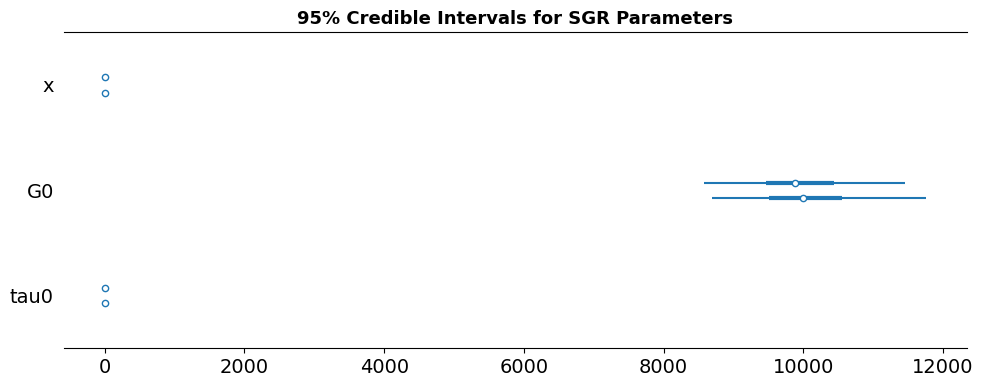

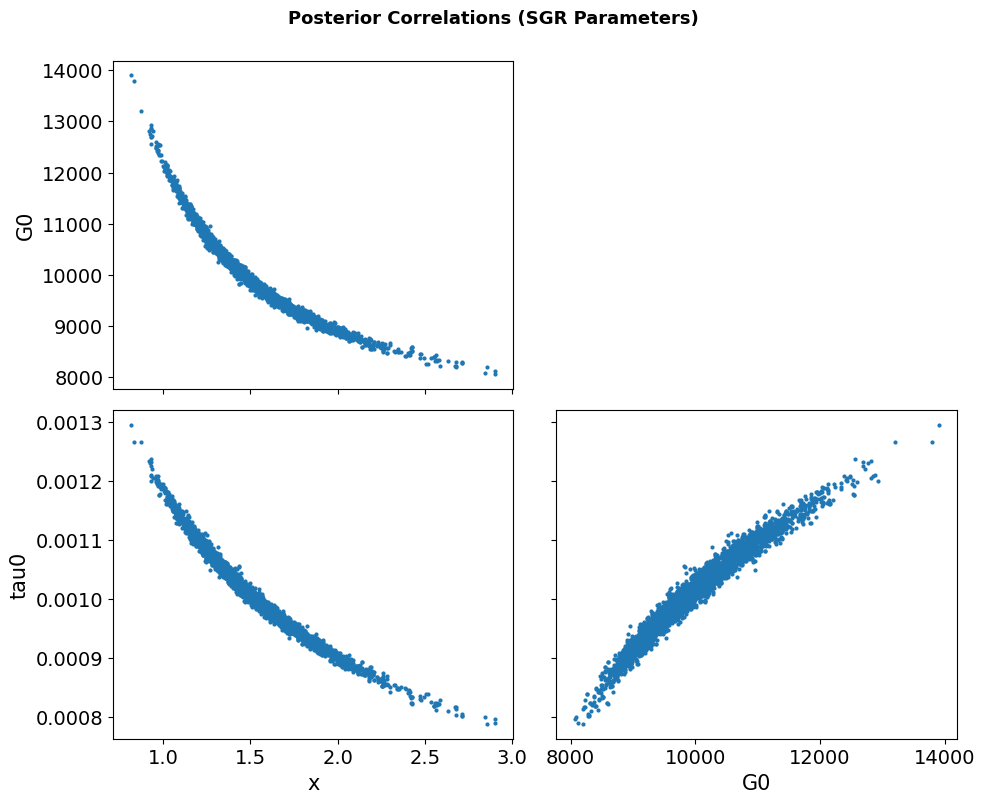

Interpretation:
  - Forest plot shows 95% credible intervals for each parameter
  - Pair plot reveals correlations between parameters
  - Blue dots in pair plot indicate divergent transitions (should be minimal)


In [11]:
# Plot posterior distributions
import arviz as az

# Convert to InferenceData
idata = result_bayes.to_inference_data()

# Forest plot (credible intervals)
az.plot_forest(idata, var_names=['x', 'G0', 'tau0'], hdi_prob=0.95, figsize=(10, 4))
plt.title('95% Credible Intervals for SGR Parameters', fontsize=13, fontweight='bold')
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

# Pair plot (correlations)
az.plot_pair(
    idata, 
    var_names=['x', 'G0', 'tau0'], 
    divergences=True,
    figsize=(10, 8)
)
plt.suptitle('Posterior Correlations (SGR Parameters)', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Interpretation:")
print("  - Forest plot shows 95% credible intervals for each parameter")
print("  - Pair plot reveals correlations between parameters")
print("  - Blue dots in pair plot indicate divergent transitions (should be minimal)")

### Trace Plot: MCMC Chain Convergence

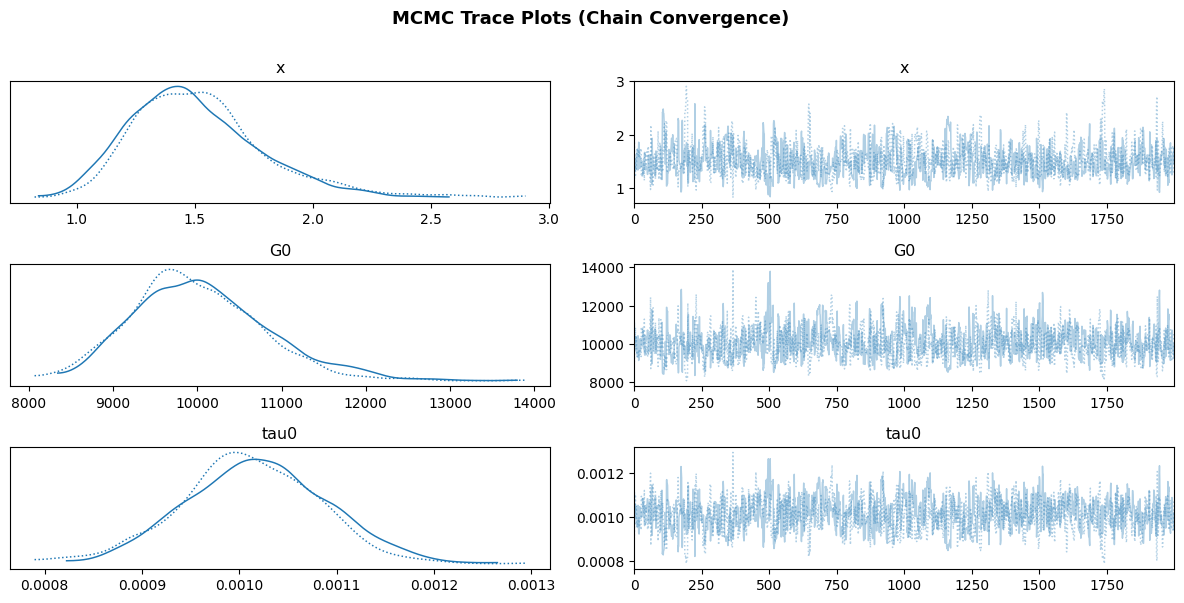

Trace plot interpretation:
  Left: Posterior distributions (should be smooth)
  Right: Chain traces (should mix well, no trends)
  Multiple chains (different colors) should overlap well (good convergence)


In [12]:
# Trace plot
az.plot_trace(idata, var_names=['x', 'G0', 'tau0'], figsize=(12, 6))
plt.suptitle('MCMC Trace Plots (Chain Convergence)', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Trace plot interpretation:")
print("  Left: Posterior distributions (should be smooth)")
print("  Right: Chain traces (should mix well, no trends)")
print("  Multiple chains (different colors) should overlap well (good convergence)")

## 8. Material Classification Based on Noise Temperature

Demonstrate how to classify materials based on fitted x value.

Material Classification from Fitted x:
Noise temperature x = 1.412

Category: Power-law fluid (balanced)
Properties: Strong power-law, balanced solid-liquid
Examples: Soft pastes, creams, emulsions


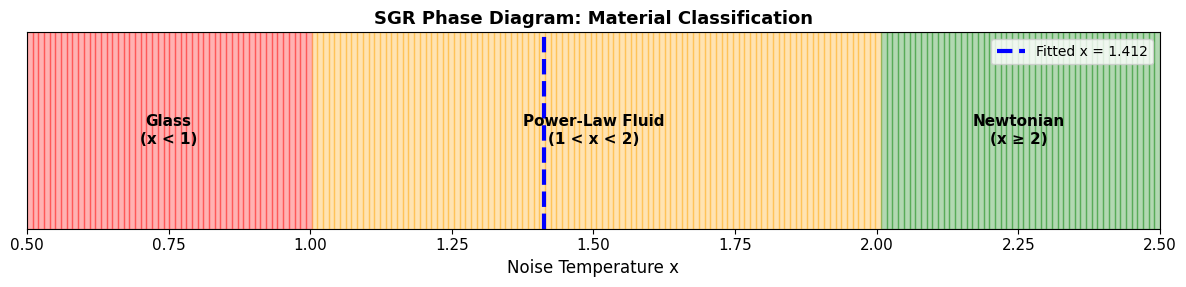

In [13]:
def classify_sgr_material(x_value):
    """Classify soft glassy material based on noise temperature."""
    if x_value < 0.8:
        category = "Strong glass"
        properties = "Yield stress, aging, non-ergodic, solid-like"
        examples = "Concentrated foams, jammed emulsions"
    elif 0.8 <= x_value < 1.0:
        category = "Weak glass (near transition)"
        properties = "Weak yield stress, slow aging, close to jamming"
        examples = "Dense colloidal suspensions"
    elif 1.0 <= x_value < 1.3:
        category = "Soft glass (low x power-law)"
        properties = "Weak power-law, slow relaxation, gel-like"
        examples = "Soft gels, weak pastes"
    elif 1.3 <= x_value < 1.7:
        category = "Power-law fluid (balanced)"
        properties = "Strong power-law, balanced solid-liquid"
        examples = "Soft pastes, creams, emulsions"
    elif 1.7 <= x_value < 2.0:
        category = "Power-law fluid (high x)"
        properties = "Approaching Newtonian, fast relaxation"
        examples = "Dilute pastes, weak emulsions"
    else:
        category = "Newtonian-like"
        properties = "Constant viscosity, liquid-like"
        examples = "Dilute suspensions, polymer solutions"
    
    return category, properties, examples

# Classify fitted material
category, properties, examples = classify_sgr_material(x_fit)

print("Material Classification from Fitted x:")
print("="*70)
print(f"Noise temperature x = {x_fit:.3f}")
print(f"\nCategory: {category}")
print(f"Properties: {properties}")
print(f"Examples: {examples}")
print("="*70)

# Create classification guide
x_range = np.linspace(0.5, 2.5, 200)
colors = []
for x_val in x_range:
    if x_val < 1.0:
        colors.append('red')  # Glass
    elif x_val < 2.0:
        colors.append('orange')  # Power-law
    else:
        colors.append('green')  # Newtonian

fig, ax = plt.subplots(figsize=(12, 3))
for i in range(len(x_range)-1):
    ax.axvspan(x_range[i], x_range[i+1], color=colors[i], alpha=0.3)

# Add phase labels
ax.text(0.75, 0.5, 'Glass\n(x < 1)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(1.5, 0.5, 'Power-Law Fluid\n(1 < x < 2)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(2.25, 0.5, 'Newtonian\n(x ≥ 2)', ha='center', va='center', fontsize=11, fontweight='bold')

# Mark fitted value
ax.axvline(x_fit, color='blue', linewidth=3, linestyle='--', label=f'Fitted x = {x_fit:.3f}')

ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Noise Temperature x', fontsize=12)
ax.set_yticks([])
ax.set_title('SGR Phase Diagram: Material Classification', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Interpretation and Insights

### Physical Meaning of SGR Parameters

**Noise Temperature (x):**
- Dimensionless ratio of thermal fluctuations to trap depth energy
- Controls glass transition at x = 1
- Power-law exponent: $G' \sim G'' \sim \omega^{x-1}$ for 1 < x < 2
- Directly measurable from oscillation data slope

**Modulus Scale (G0):**
- Sets absolute magnitude of elastic response
- Related to microscopic trap depth and element density
- Typical range: 10 Pa (soft gels) to 10 kPa (dense pastes)

**Attempt Time (tau0):**
- Microscopic timescale for trap hopping attempts
- Sets characteristic frequency: $\omega_c \sim 1/\tau_0$
- Typical range: nanoseconds (molecular) to milliseconds (colloidal)

### When to Use SGR Models

**SGR is appropriate when:**
1. Material exhibits power-law rheology over wide frequency range
2. Glass transition or jamming transition is relevant
3. Material is a soft glassy system (foam, emulsion, paste, colloid)
4. Classical viscoelastic models (Maxwell, Kelvin-Voigt) fail
5. Aging, yielding, or structural evolution is important

**Use alternative models when:**
1. Material shows narrow relaxation spectrum → Generalized Maxwell Model
2. Fractional power-law without jamming → Fractional models (SpringPot, FMG)
3. Exponential relaxation → Classical models (Maxwell, Kelvin-Voigt)
4. Polymers with entanglement → Tube models, Rolie-Poly

### SGRConventional vs SGRGeneric: When to Use Each

**Use SGRConventional when:**
- Standard rheological characterization (oscillation, relaxation, creep)
- Speed is important (simpler formulation)
- Fitting experimental data for material classification
- LAOS or steady shear analysis required

**Use SGRGeneric when:**
- Thermodynamic consistency is critical
- Studying nonequilibrium transitions
- Need entropy production tracking
- Coupling to other thermodynamic frameworks
- Theoretical analysis of dissipation

## Key Takeaways

1. **SGR Framework:** Statistical mechanics model for soft glassy materials based on trap model with exponential density of states

2. **Noise Temperature x:** Controls material phase transition:
   - x < 1: Glass (yield stress, solid-like)
   - 1 < x < 2: Power-law fluid (viscoelastic)
   - x ≥ 2: Newtonian (liquid-like)

3. **Three Parameters:** x (phase), G0 (magnitude), tau0 (timescale) fully characterize SGR response

4. **Two Implementations:**
   - SGRConventional: Fast, versatile (oscillation, relaxation, creep, LAOS)
   - SGRGeneric: Thermodynamically consistent, entropy production tracking

5. **Bayesian Inference:** Provides uncertainty quantification for SGR parameters, critical for noise temperature classification

6. **Material Classification:** Fitted x value directly determines material category and properties

7. **Applications:** Foams, emulsions, pastes, colloidal suspensions, and any soft glassy material with power-law rheology

## Next Steps

- Explore SRFS transform (`examples/transforms/srfs-strain-rate-superposition.ipynb`) for strain-rate frequency superposition with SGR
- Try fractional models (`examples/advanced/04-fractional-models-deep-dive.ipynb`) for comparison with power-law relaxation
- Study Generalized Maxwell Model (`examples/advanced/08-generalized_maxwell_fitting.ipynb`) for multi-mode exponential relaxation
- Apply to real experimental data from TRIOS, Anton Paar, or other rheometers

## References

1. P. Sollich, *Rheological constitutive equation for a model of soft glassy materials*, Physical Review E, 1998, 58(1), 738-759
2. P. Sollich et al., *Rheology of Soft Glassy Materials*, Physical Review Letters, 1997, 78(10), 2020-2023
3. I. Fuereder and P. Ilg, *GENERIC framework for the Fokker-Planck equation*, Physical Review E, 2013, 88, 042134
4. S.M. Fielding et al., *Aging and rheology in soft materials*, Journal of Rheology, 2000, 44(2), 323-369

## Session Information

In [14]:
import sys

import rheojax

print("Session Information:")
print(f"  Python version: {sys.version}")
print(f"  RheoJAX version: {rheojax.__version__}")
print(f"  JAX backend: {jax.default_backend()}")
print(f"  JAX devices: {jax.devices()}")
print(f"  NumPy version: {np.__version__}")

Session Information:
  Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
  RheoJAX version: 0.6.0
  JAX backend: cpu
  JAX devices: [CpuDevice(id=0)]
  NumPy version: 2.3.5
